<a href="https://colab.research.google.com/github/AndreiAf02/Transfer_Learning_Extension/blob/main/Credit_Default_Transductive_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Credit Default - Transductive TL stratified on Education

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C55S3H):

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# # fetch dataset
# cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)



{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [4]:
X['X3'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [5]:
## Cleaning up the 'unknown' education levels:

data_total = pd.concat([X, y], axis=1)
data_total = data_total[(data_total['X3'] != 5) & (data_total['X3'] != 6) & (data_total['X3'] != 0)]
data_total = data_total.reset_index(drop=True)
data_total

X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  ...    X15    X16    X17  \
0       20000   2   2   1  24   2   2  -1  -1   -2  ...      0      0      0   
1      120000   2   2   2  26  -1   2   0   0    0  ...   3272   3455   3261   
2       90000   2   2   2  34   0   0   0   0    0  ...  14331  14948  15549   
3       50000   2   2   1  37   0   0   0   0    0  ...  28314  28959  29547   
4       50000   1   2   1  57  -1   0  -1   0    0  ...  20940  19146  19131   
...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...    ...    ...    ...   
29650  220000   1   3   1  39   0   0   0   0    0  ...  88004  31237  15980   
29651  150000   1   3   2  43  -1  -1  -1  -1    0  ...   8979   5190      0   
29652   30000   1   2   2  37   4   3   2  -1    0  ...  20878  20582  19357   
29653   80000   1   3   1  41   1  -1   0   0    0  ...  52774  11855  48944   
29654   50000   1   2   1  46   0   0   0   0    0  ...  36535  32428  15313   

         X18    X19    X20   X21    X22   X23  Y  
0          0    689      0     0      0     0  1  
1          0   1000   1000  1000      0  2000  1  
2       1518   1500   1000  1000   1000  5000  0  
3       2000   2019   1200  1100   1069  1000  0  
4       2000  36681  10000  9000    689   679  0  
...      ...    ...    ...   ...    ...   ... ..  
29650   8500  20000   5003  3047   5000  1000  0  
29651   1837   3526   8998   129      0     0  0  
29652      0      0  22000  4200   2000  3100  1  
29653  85900   3409   1178  1926  52964  1804  1  
29654   2078   1800   1430  1000   1000  1000  1  

[29655 rows x 24 columns]

In [6]:
X = data_total.iloc[:, :-1]
y = data_total.iloc[:,-1]
y

0        1
1        1
2        0
3        0
4        0
        ..
29650    0
29651    0
29652    1
29653    1
29654    1
Name: Y, Length: 29655, dtype: int64

In [7]:
X['X3'].unique()

array([2, 1, 3, 4])

In [8]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [9]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.4  0.1  0.1  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.1  0.4  0.2  0.2  0.2   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.1  0.2  0.1  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
29650  0.212121  0.0  0.666667  0.333333  0.310345  0.2  0.2  0.2  0.2  0.2   
29651  0.141414  0.0  0.666667  0.666667  0.379310  0.1  0.1  0.1  0.1  0.2   
29652  0.020202  0.0  0.333333  0.666667  0.275862  0.6  0.5  0.4  0.1  0.2   
29653  0.070707  0.0  0.666667  0.333333  0.344828  0.3  0.1  0.2  0.2  0.2   
29654  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        14        15        16        17        18        19  \
0      ...  0.160138  0.080648  0.260979  0.000000  0.000409  0.000000   
1      ...  0.163220  0.084074  0.263485  0.000000  0.000594  0.001116   
2      ...  0.173637  0.095470  0.272928  0.001738  0.000891  0.001116   
3      ...  0.186809  0.109363  0.283685  0.002290  0.001199  0.001339   
4      ...  0.179863  0.099633  0.275681  0.002290  0.021779  0.011160   
...    ...       ...       ...       ...       ...       ...       ...   
29650  ...  0.243036  0.111622  0.273259  0.009730  0.011875  0.005583   
29651  ...  0.168596  0.085794  0.260979  0.002103  0.002094  0.010042   
29652  ...  0.179805  0.101057  0.275854  0.000000  0.000000  0.024552   
29653  ...  0.209850  0.092403  0.298591  0.098334  0.002024  0.001315   
29654  ...  0.194553  0.112803  0.272746  0.002379  0.001069  0.001596   

             20        21        22  Y  
0      0.000000  0.000000  0.000000  1  
1      0.001610  0.000000  0.003783  1  
2      0.001610  0.002345  0.009458  0  
3      0.001771  0.002506  0.001892  0  
4      0.014493  0.001615  0.001284  0  
...         ...       ...       ... ..  
29650  0.004907  0.011723  0.001892  0  
29651  0.000208  0.000000  0.000000  0  
29652  0.006763  0.004689  0.005864  1  
29653  0.003101  0.124174  0.003412  1  
29654  0.001610  0.002345  0.001892  1  

[29655 rows x 24 columns]

In [10]:
y.value_counts()

Y
0    23045
1     6610
Name: count, dtype: int64

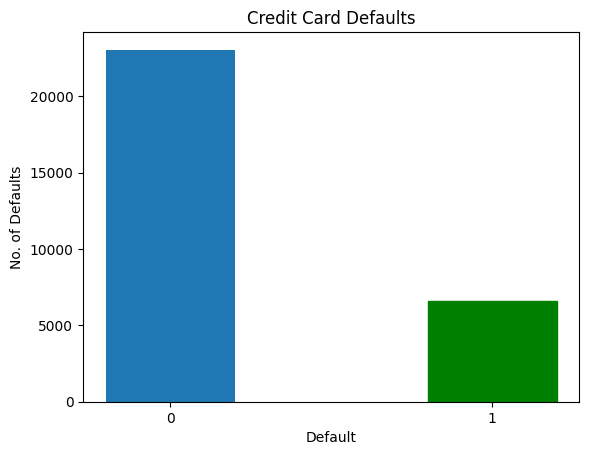

In [11]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Default")
plt.ylabel("No. of Defaults")
plt.title("Credit Card Defaults")
plt.show()

In [13]:
data_total['X3'].value_counts()

X3
2    14030
1    10585
3     4917
4      123
Name: count, dtype: int64

In [12]:
data2.iloc[:, 2].value_counts()

2
0.333333    14030
0.000000    10585
0.666667     4917
1.000000      123
Name: count, dtype: int64

# Splitting for Source and Target Domains:


# Full Dataset:

In [14]:
data_S = data2[data2.iloc[:,2] <= 0.5]  ## Source domain and classification - University or higher
data_T = data2[data2.iloc[:,2] > 0.5]  ## Target domain and classification - High school or other

In [15]:
data_S

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.4  0.1  0.1  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.1  0.4  0.2  0.2  0.2   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.1  0.2  0.1  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
29646  0.202020  0.0  0.333333  0.333333  0.224138  0.5  0.4  0.4  0.4  0.4   
29648  0.090909  0.0  0.000000  0.666667  0.293103  0.2  0.1  0.1  0.2  0.2   
29649  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
29652  0.020202  0.0  0.333333  0.666667  0.275862  0.6  0.5  0.4  0.1  0.2   
29654  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        14        15        16        17        18        19  \
0      ...  0.160138  0.080648  0.260979  0.000000  0.000409  0.000000   
1      ...  0.163220  0.084074  0.263485  0.000000  0.000594  0.001116   
2      ...  0.173637  0.095470  0.272928  0.001738  0.000891  0.001116   
3      ...  0.186809  0.109363  0.283685  0.002290  0.001199  0.001339   
4      ...  0.179863  0.099633  0.275681  0.002290  0.021779  0.011160   
...    ...       ...       ...       ...       ...       ...       ...   
29646  ...  0.162493  0.083127  0.262900  0.000000  0.000000  0.000000   
29648  ...  0.226667  0.149535  0.303248  0.002290  0.066370  0.004464   
29649  ...  0.233160  0.162558  0.323347  0.008013  0.002078  0.000000   
29652  ...  0.179805  0.101057  0.275854  0.000000  0.000000  0.024552   
29654  ...  0.194553  0.112803  0.272746  0.002379  0.001069  0.001596   

             20        21        22  Y  
0      0.000000  0.000000  0.000000  1  
1      0.001610  0.000000  0.003783  1  
2      0.001610  0.002345  0.009458  0  
3      0.001771  0.002506  0.001892  0  
4      0.014493  0.001615  0.001284  0  
...         ...       ...       ... ..  
29646  0.000000  0.000000  0.000000  1  
29648  0.004831  0.004689  0.003783  0  
29649  0.011272  0.000000  0.007566  1  
29652  0.006763  0.004689  0.005864  1  
29654  0.001610  0.002345  0.001892  1  

[24615 rows x 24 columns]

In [16]:
data_T

0    1         2         3         4    5    6    7    8    9  \
8      0.131313  1.0  0.666667  0.333333  0.120690  0.2  0.2  0.4  0.2  0.2   
9      0.010101  0.0  0.666667  0.666667  0.241379  0.0  0.0  0.0  0.0  0.1   
10     0.191919  1.0  0.666667  0.666667  0.224138  0.2  0.2  0.4  0.2  0.2   
15     0.040404  1.0  0.666667  1.000000  0.034483  0.3  0.4  0.2  0.2  0.2   
20     0.121212  1.0  0.666667  0.666667  0.310345  0.2  0.2  0.2  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
29635  0.040404  0.0  0.666667  0.666667  0.362069  0.2  0.2  0.2  0.2  0.2   
29647  0.000000  0.0  0.666667  0.333333  0.379310  0.2  0.2  0.2  0.0  0.0   
29650  0.212121  0.0  0.666667  0.333333  0.310345  0.2  0.2  0.2  0.2  0.2   
29651  0.141414  0.0  0.666667  0.666667  0.379310  0.1  0.1  0.1  0.1  0.2   
29653  0.070707  0.0  0.666667  0.333333  0.344828  0.3  0.1  0.2  0.2  0.2   

       ...        14        15        16        17        18        19  \
8      ...  0.171640  0.092342  0.263837  0.003811  0.000000  0.000482   
9      ...  0.160138  0.093545  0.271670  0.000000  0.000000  0.000000   
10     ...  0.162505  0.082461  0.263846  0.002640  0.000007  0.000056   
15     ...  0.187240  0.109930  0.284195  0.000000  0.000891  0.001228   
20     ...  0.179558  0.092351  0.261693  0.003434  0.000913  0.001116   
...    ...       ...       ...       ...       ...       ...       ...   
29635  ...  0.207576  0.100451  0.276113  0.011448  0.002375  0.005580   
29647  ...  0.160138  0.080648  0.260979  0.002290  0.000000  0.000000   
29650  ...  0.243036  0.111622  0.273259  0.009730  0.011875  0.005583   
29651  ...  0.168596  0.085794  0.260979  0.002103  0.002094  0.010042   
29653  ...  0.209850  0.092403  0.298591  0.098334  0.002024  0.001315   

             20        21        22  Y  
8      0.001610  0.002345  0.001892  0  
9      0.020945  0.002631  0.000000  0  
10     0.000483  0.008764  0.000125  0  
15     0.001932  0.003048  0.002081  0  
20     0.003221  0.002180  0.063866  0  
...         ...       ...       ... ..  
29635  0.004831  0.010550  0.003783  0  
29647  0.000000  0.000000  0.000000  0  
29650  0.004907  0.011723  0.001892  0  
29651  0.000208  0.000000  0.000000  0  
29653  0.003101  0.124174  0.003412  1  

[5040 rows x 24 columns]

## Source domain and task labels:

In [17]:
X_S_full = data_S.iloc[:, :-1]
X_S_full       ## Source domain


y_S_full = data_S.iloc[:, -1]
y_S_full       ## Source classification (response)

0        1
1        1
2        0
3        0
4        0
        ..
29646    1
29648    0
29649    1
29652    1
29654    1
Name: Y, Length: 24615, dtype: int64

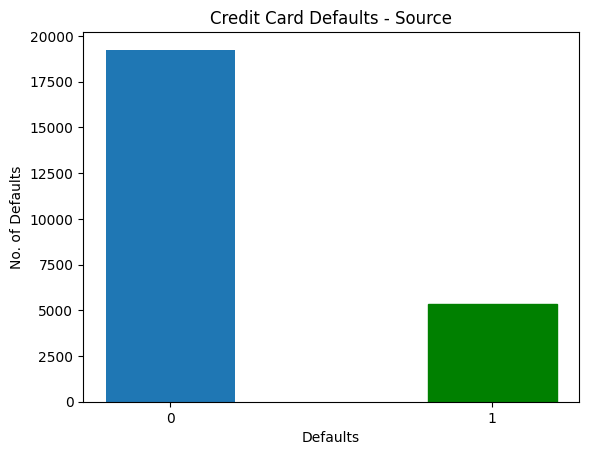

In [18]:
barlist_S = plt.bar([str(0),str(1)], y_S_full.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Defaults")
plt.ylabel("No. of Defaults")
plt.title("Credit Card Defaults - Source")
plt.show()

## Target domain and task labels:

In [19]:
X_T_full = data_T.iloc[:, :-1]
X_T_full       ## Target domain


y_T_full = data_T.iloc[:, -1]
y_T_full       ## Target classification (response)

8        0
9        0
10       0
15       0
20       0
        ..
29635    0
29647    0
29650    0
29651    0
29653    1
Name: Y, Length: 5040, dtype: int64

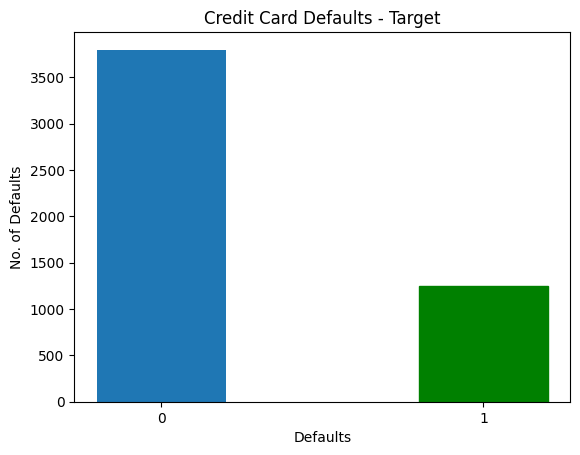

In [20]:
barlist_T = plt.bar([str(0),str(1)], y_T_full.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Defaults")
plt.ylabel("No. of Defaults")
plt.title("Credit Card Defaults - Target")
plt.show()

## Updated Code (Modified from Shreya's code):

In [21]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # # Confusion Matrix
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)
    return time_elapsed


In [22]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)

    return fpr, tnr, fnr, tpr, time_elapsed

In [23]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)

In [24]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (19692, 23)
y_S_train: (19692,)
X_S_test: (4923, 23)
y_S_test: (4923,)


In [25]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.6187 - loss: 0.5245 - val_AUC: 0.7264 - val_loss: 0.4618
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7332 - loss: 0.4533 - val_AUC: 0.7460 - val_loss: 0.4507
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7307 - loss: 0.4465 - val_AUC: 0.7536 - val_loss: 0.4479
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7443 - loss: 0.4449 - val_AUC: 0.7607 - val_loss: 0.4456
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7564 - loss: 0.4356 - val_AUC: 0.7669 - val_loss: 0.4496
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7571 - loss: 0.4396 - val_AUC: 0.7671 - val_loss: 0.4441
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7617 - loss: 0.4420 - val_AUC: 0.7709 - val_loss: 0.4414
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7658 - loss: 0.4374 - val_AUC: 0.7730 - val_loss: 0.4414
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AU

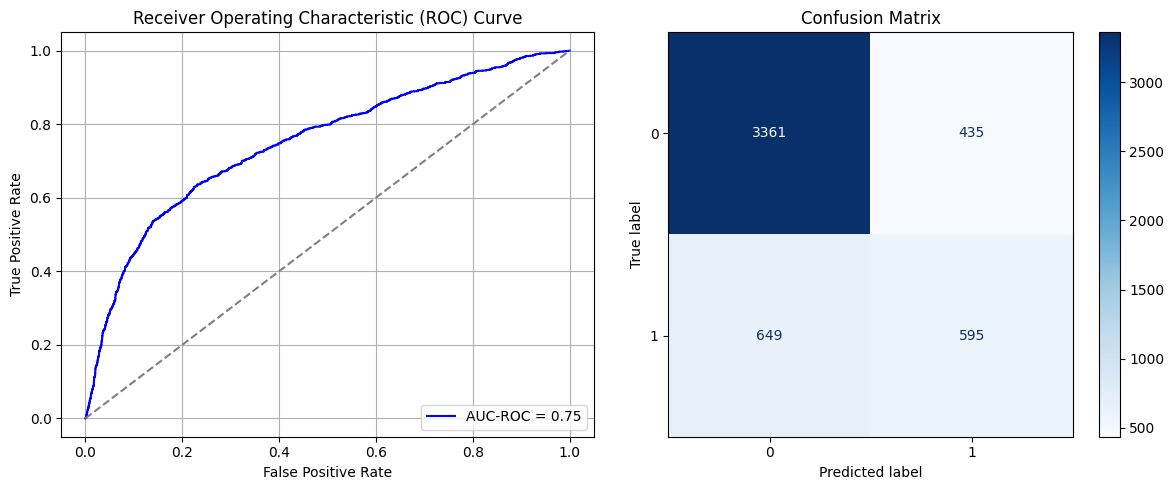

Best threshold based on F1-score: 0.9441880583763123
False Negative Rate: 0.5217041800643086
Time elapsed (performance): 0.8030951679999134
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6282 - loss: 0.5070 - val_AUC: 0.7194 - val_loss: 0.4699
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7183 - loss: 0.4665 - val_AUC: 0.7426 - val_loss: 0.4559
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7498 - loss: 0.4421 - val_AUC: 0.7514 - val_loss: 0.4597
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7531 - loss: 0.4378 - val_AUC: 0.7591 - val_loss: 0.4493
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7609 - loss: 0.4308 - val_AUC: 0.7679 - val_loss: 0.4413
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7662 - loss: 0.4305 - val_AUC: 0.7673 - val_loss: 0.4407
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7695 - loss: 0.4279 - val_AUC: 0.7719 - val_loss: 0.4437
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7651 - loss: 0.4361 - val_AUC: 0.7682 - val_loss: 0.4492
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7712 -

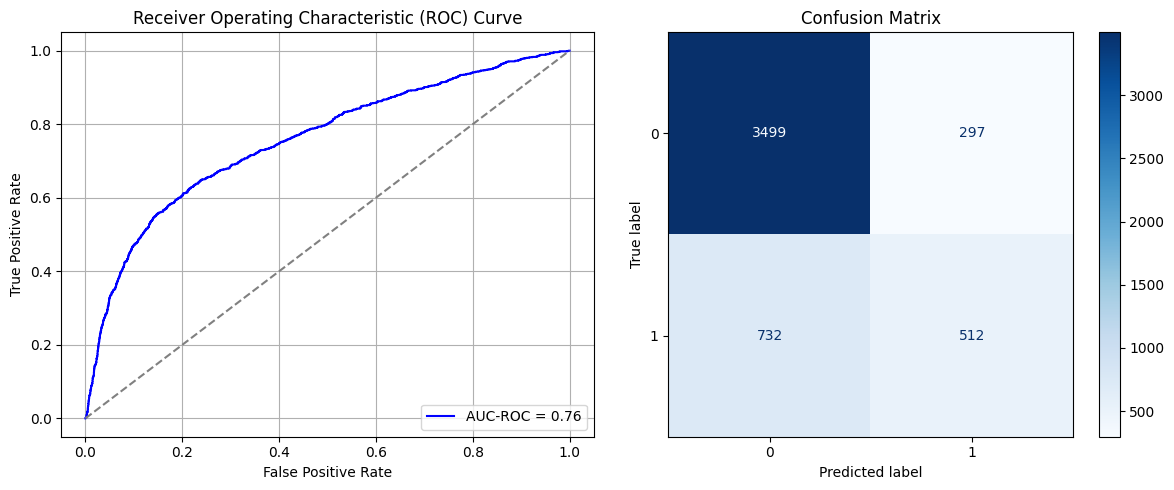

Best threshold based on F1-score: 0.9317471385002136
False Negative Rate: 0.5884244372990354
Time elapsed (performance): 0.7426889490000121
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6058 - loss: 0.5144 - val_AUC: 0.7295 - val_loss: 0.4682
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7353 - loss: 0.4525 - val_AUC: 0.7498 - val_loss: 0.4615
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7393 - loss: 0.4438 - val_AUC: 0.7573 - val_loss: 0.4467
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7476 - loss: 0.4456 - val_AUC: 0.7597 - val_loss: 0.4469
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7592 - loss: 0.4333 - val_AUC: 0.7690 - val_loss: 0.4454
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7506 - loss: 0.4499 - val_AUC: 0.7682 - val_loss: 0.4412
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7673 - loss: 0.4310 - val_AUC: 0.7719 - val_loss: 0.4389
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7783 - loss: 0.4245 - val_AUC: 0.7711 - val_loss: 0.4392
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7745 -

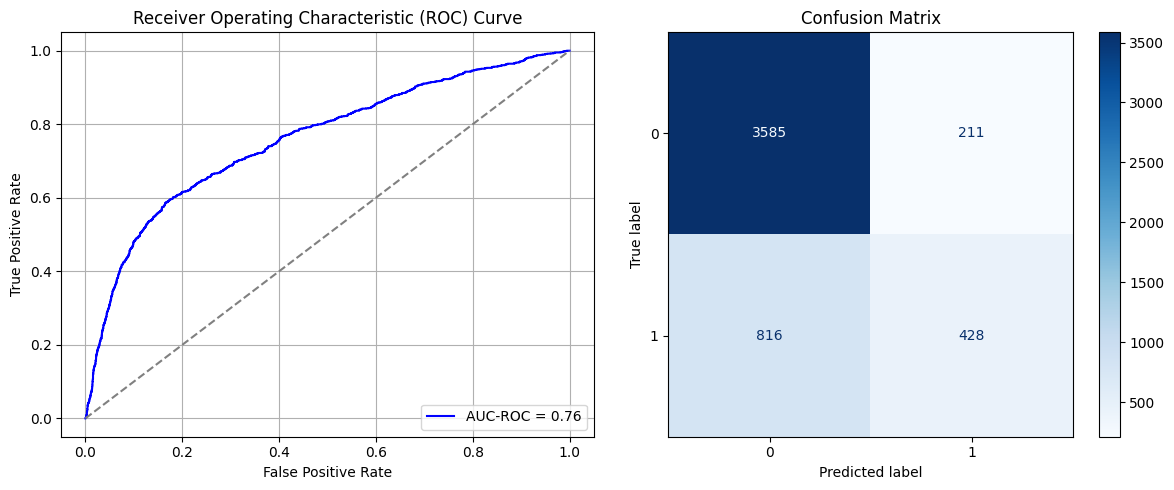

Best threshold based on F1-score: 0.9110255241394043
False Negative Rate: 0.6559485530546624
Time elapsed (performance): 1.103860839000049
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5773 - loss: 0.5359 - val_AUC: 0.7157 - val_loss: 0.4681
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7268 - loss: 0.4516 - val_AUC: 0.7444 - val_loss: 0.4595
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7399 - loss: 0.4447 - val_AUC: 0.7521 - val_loss: 0.4502
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7431 - loss: 0.4458 - val_AUC: 0.7533 - val_loss: 0.4486
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7519 - loss: 0.4402 - val_AUC: 0.7639 - val_loss: 0.4491
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7593 - loss: 0.4340 - val_AUC: 0.7624 - val_loss: 0.4492
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7616 - loss: 0.4323 - val_AUC: 0.7679 - val_loss: 0.4439
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7613 - loss: 0.4297 - val_AUC: 0.7696 - val_loss: 0.4441
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7662 -

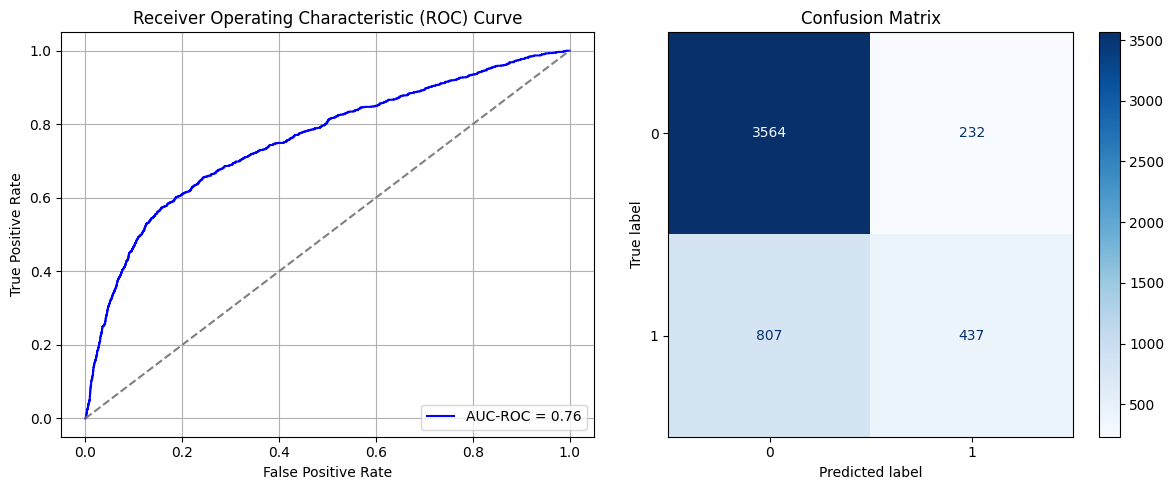

Best threshold based on F1-score: 0.8927029371261597
False Negative Rate: 0.6487138263665595
Time elapsed (performance): 1.2797319320000042
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6177 - loss: 0.5134 - val_AUC: 0.7325 - val_loss: 0.4608
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7377 - loss: 0.4529 - val_AUC: 0.7508 - val_loss: 0.4587
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7575 - loss: 0.4352 - val_AUC: 0.7577 - val_loss: 0.4518
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7563 - loss: 0.4331 - val_AUC: 0.7629 - val_loss: 0.4442
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7590 - loss: 0.4349 - val_AUC: 0.7662 - val_loss: 0.4481
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7606 - loss: 0.4317 - val_AUC: 0.7754 - val_loss: 0.4381
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7611 - loss: 0.4324 - val_AUC: 0.7764 - val_loss: 0.4433
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7715 - loss: 0.4356 - val_AUC: 0.7796 - val_loss: 0.4366
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7692 -

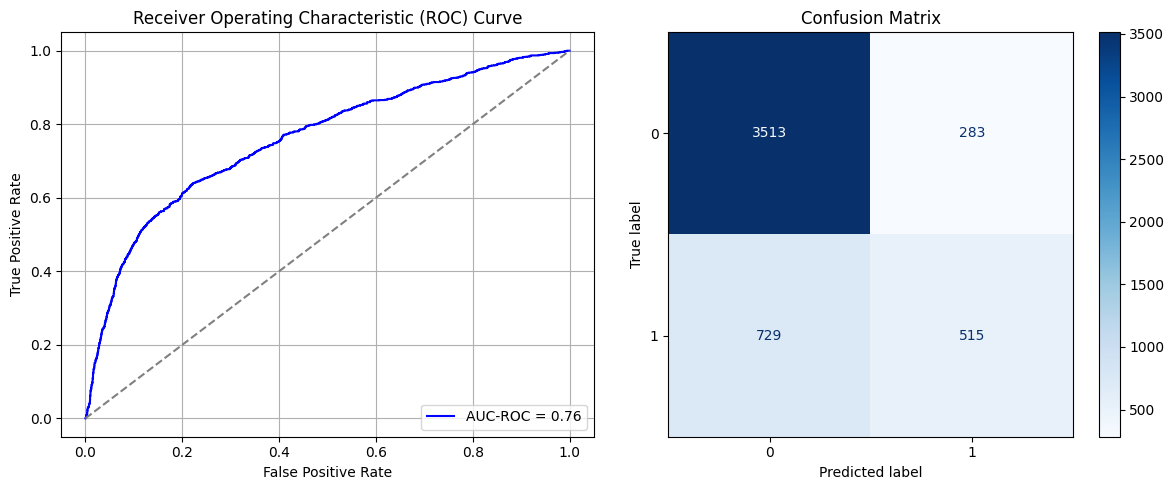

Best threshold based on F1-score: 0.9497454166412354
False Negative Rate: 0.5860128617363344
Time elapsed (performance): 0.7374167689999922
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6151 - loss: 0.5184 - val_AUC: 0.7305 - val_loss: 0.4624
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7258 - loss: 0.4577 - val_AUC: 0.7417 - val_loss: 0.4550
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7375 - loss: 0.4484 - val_AUC: 0.7540 - val_loss: 0.4490
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7442 - loss: 0.4417 - val_AUC: 0.7582 - val_loss: 0.4461
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7458 - loss: 0.4432 - val_AUC: 0.7694 - val_loss: 0.4417
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7625 - loss: 0.4327 - val_AUC: 0.7722 - val_loss: 0.4389
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7611 - loss: 0.4285 - val_AUC: 0.7732 - val_loss: 0.4377
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7698 - loss: 0.4261 - val_AUC: 0.7690 - val_loss: 0.4392
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7764 -

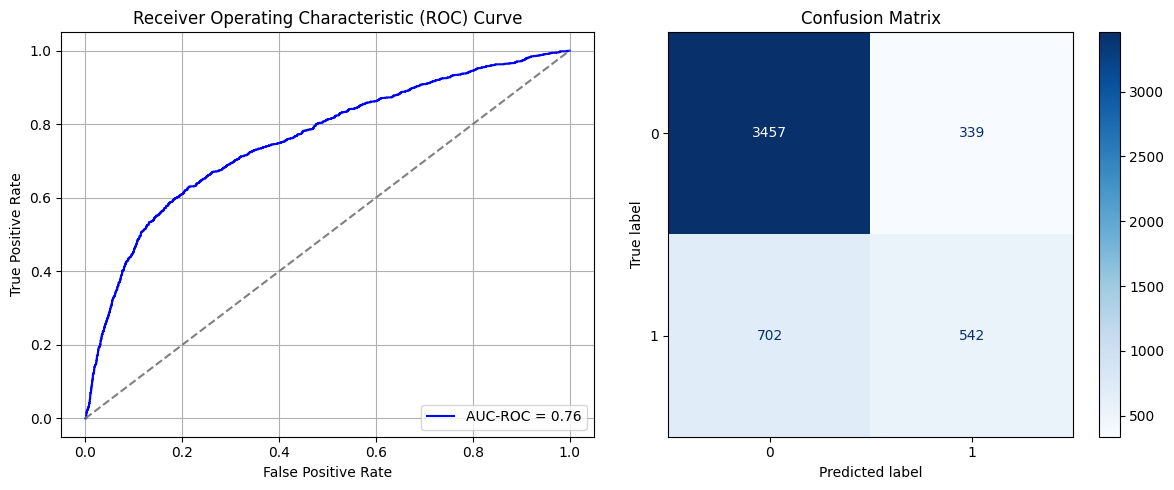

Best threshold based on F1-score: 0.9064176082611084
False Negative Rate: 0.5643086816720257
Time elapsed (performance): 0.7084506920000422
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6047 - loss: 0.5240 - val_AUC: 0.7282 - val_loss: 0.4652
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7373 - loss: 0.4499 - val_AUC: 0.7412 - val_loss: 0.4557
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7427 - loss: 0.4486 - val_AUC: 0.7499 - val_loss: 0.4506
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7490 - loss: 0.4458 - val_AUC: 0.7550 - val_loss: 0.4533
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7504 - loss: 0.4365 - val_AUC: 0.7566 - val_loss: 0.4499
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7508 - loss: 0.4391 - val_AUC: 0.7651 - val_loss: 0.4421
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7592 - loss: 0.4314 - val_AUC: 0.7672 - val_loss: 0.4440
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7628 - loss: 0.4311 - val_AUC: 0.7696 - val_loss: 0.4436
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7670 -

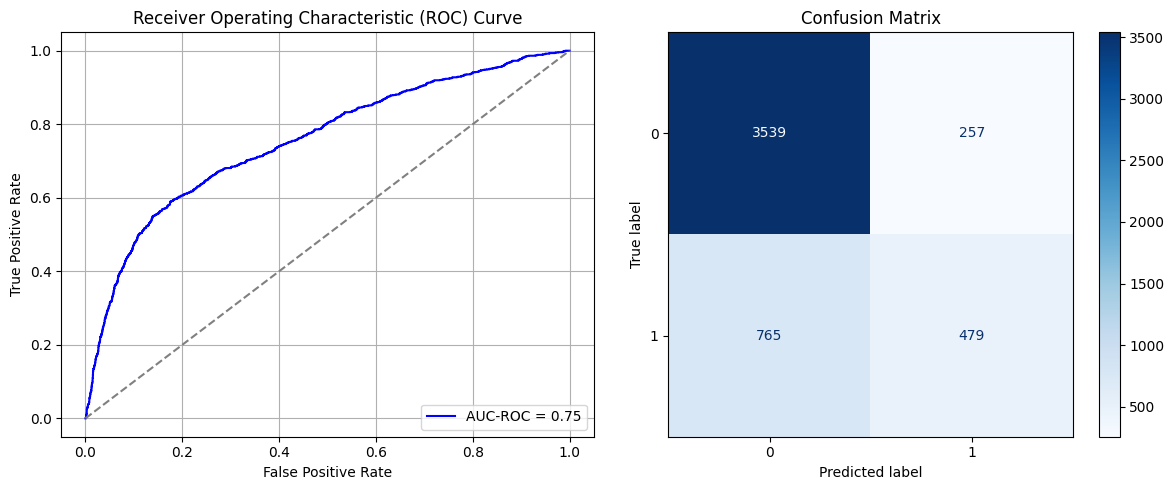

Best threshold based on F1-score: 0.9189420342445374
False Negative Rate: 0.614951768488746
Time elapsed (performance): 0.7451756340000202
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6013 - loss: 0.5251 - val_AUC: 0.7219 - val_loss: 0.4720
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7302 - loss: 0.4577 - val_AUC: 0.7447 - val_loss: 0.4673
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7452 - loss: 0.4461 - val_AUC: 0.7518 - val_loss: 0.4497
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7466 - loss: 0.4419 - val_AUC: 0.7602 - val_loss: 0.4493
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7606 - loss: 0.4375 - val_AUC: 0.7624 - val_loss: 0.4466
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7560 - loss: 0.4318 - val_AUC: 0.7681 - val_loss: 0.4425
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7676 - loss: 0.4240 - val_AUC: 0.7706 - val_loss: 0.4405
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7700 - loss: 0.4243 - val_AUC: 0.7716 - val_loss: 0.4423
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7661 -

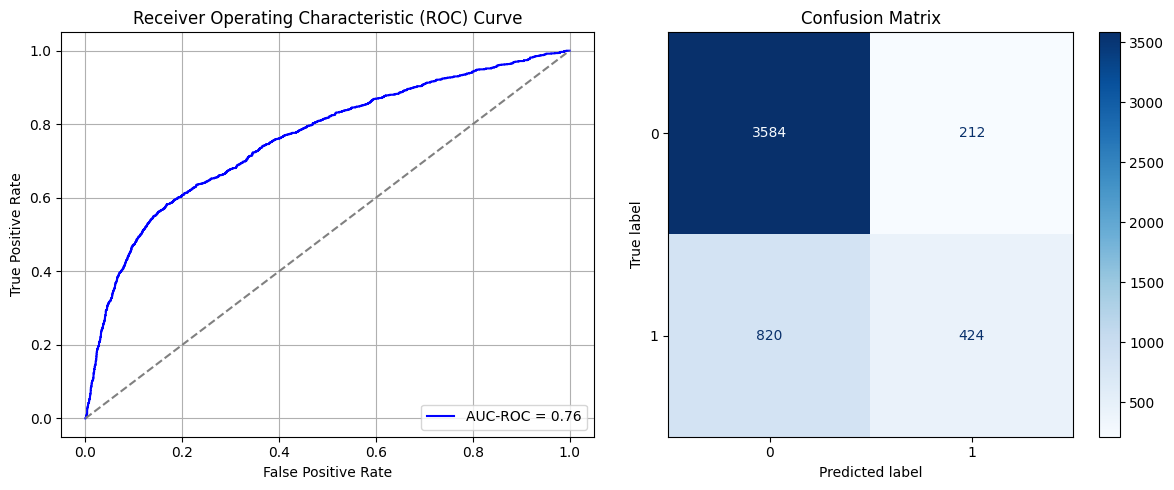

Best threshold based on F1-score: 0.9408971071243286
False Negative Rate: 0.6591639871382636
Time elapsed (performance): 0.7533443430000943
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6205 - loss: 0.5263 - val_AUC: 0.7198 - val_loss: 0.4653
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7330 - loss: 0.4523 - val_AUC: 0.7408 - val_loss: 0.4550
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7389 - loss: 0.4489 - val_AUC: 0.7523 - val_loss: 0.4520
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7491 - loss: 0.4384 - val_AUC: 0.7613 - val_loss: 0.4462
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7517 - loss: 0.4354 - val_AUC: 0.7639 - val_loss: 0.4430
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7647 - loss: 0.4366 - val_AUC: 0.7731 - val_loss: 0.4408
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7660 - loss: 0.4282 - val_AUC: 0.7725 - val_loss: 0.4458
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7659 - loss: 0.4283 - val_AUC: 0.7792 - val_loss: 0.4389
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7699 -

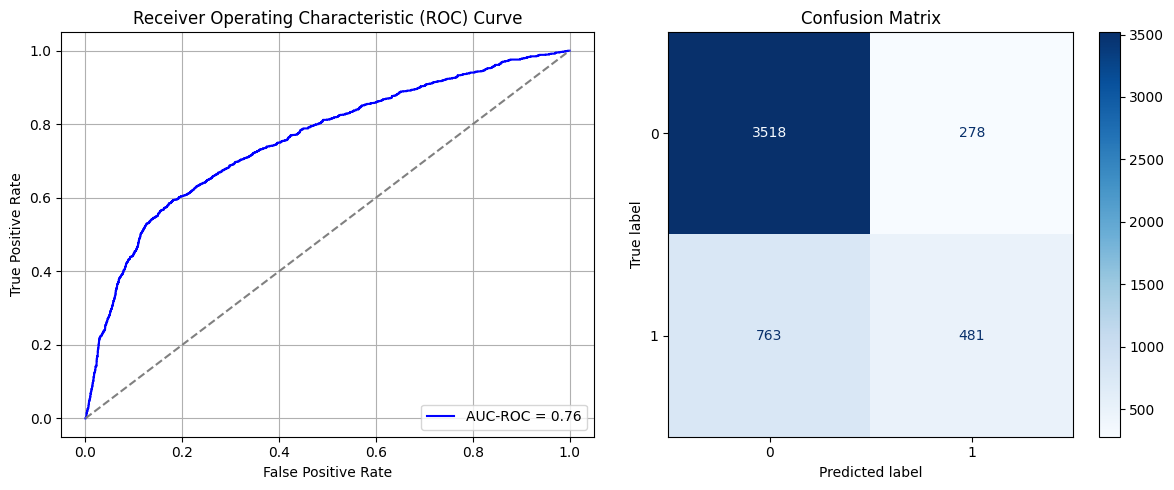

Best threshold based on F1-score: 0.8979798555374146
False Negative Rate: 0.6133440514469454
Time elapsed (performance): 0.7623402889998943
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6213 - loss: 0.5190 - val_AUC: 0.7241 - val_loss: 0.4657
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7193 - loss: 0.4593 - val_AUC: 0.7475 - val_loss: 0.4518
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7434 - loss: 0.4407 - val_AUC: 0.7568 - val_loss: 0.4480
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7561 - loss: 0.4335 - val_AUC: 0.7656 - val_loss: 0.4467
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7531 - loss: 0.4373 - val_AUC: 0.7677 - val_loss: 0.4513
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7555 - loss: 0.4393 - val_AUC: 0.7716 - val_loss: 0.4396
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7656 - loss: 0.4334 - val_AUC: 0.7700 - val_loss: 0.4396
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7631 - loss: 0.4285 - val_AUC: 0.7774 - val_loss: 0.4358
Epoch 9/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7732 -

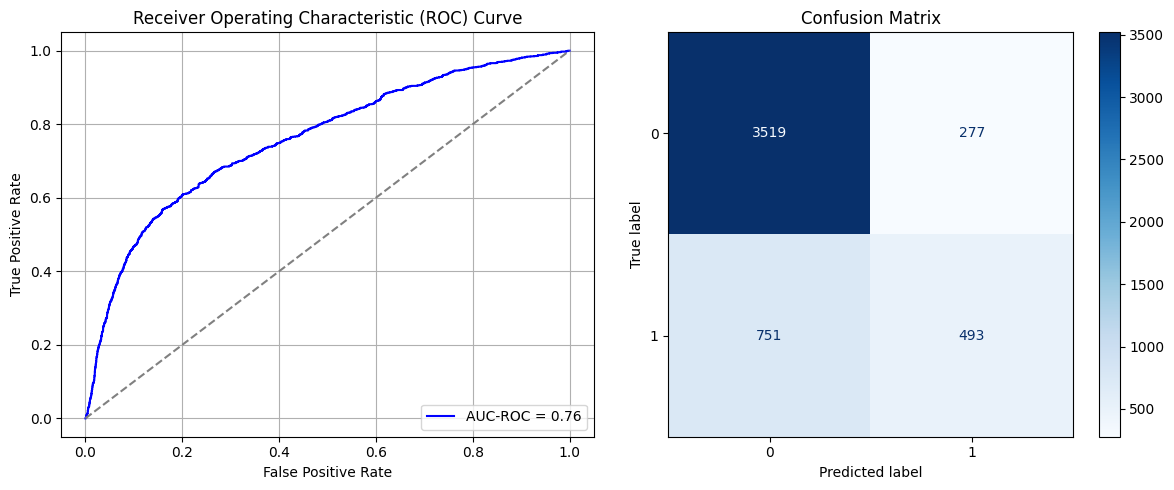

Best threshold based on F1-score: 0.9159455895423889
False Negative Rate: 0.6036977491961415
Time elapsed (performance): 0.7434195319999617


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [26]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)
    model_source = create_dnn_model(X_S_train.shape[1])
    result_imbalanced = train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_imbalanced = Transductive_TL(model_source, X_T_full, y_T_full, "Target")

    Training_time.append(result_imbalanced)
    FPR.append(result_TL_imbalanced[0])
    TPR.append(result_TL_imbalanced[1])
    FNR.append(result_TL_imbalanced[2])
    TNR.append(result_TL_imbalanced[3])
    TL_time.append(result_TL_imbalanced[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

In [27]:
print(ParamFit)
ParamFit.to_csv('Imbalanced.csv')

   Source time       FPR       TPR       FNR       TNR  Target time
0    27.933834  0.114594  0.885406  0.521704  0.478296     0.803095
1    24.285893  0.078240  0.921760  0.588424  0.411576     0.742689
2    22.835509  0.055585  0.944415  0.655949  0.344051     1.103861
3    23.040702  0.061117  0.938883  0.648714  0.351286     1.279732
4    24.655571  0.074552  0.925448  0.586013  0.413987     0.737417
5    24.814499  0.089305  0.910695  0.564309  0.435691     0.708451
6    27.069981  0.067703  0.932297  0.614952  0.385048     0.745176
7    28.366494  0.055848  0.944152  0.659164  0.340836     0.753344
8    23.783373  0.073235  0.926765  0.613344  0.386656     0.762340
9    23.144413  0.072972  0.927028  0.603698  0.396302     0.743420


# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [28]:
data_S

0    1         2         3         4    5    6    7    8    9  \
0      0.010101  1.0  0.333333  0.333333  0.051724  0.4  0.4  0.1  0.1  0.0   
1      0.111111  1.0  0.333333  0.666667  0.086207  0.1  0.4  0.2  0.2  0.2   
2      0.080808  1.0  0.333333  0.666667  0.224138  0.2  0.2  0.2  0.2  0.2   
3      0.040404  1.0  0.333333  0.333333  0.275862  0.2  0.2  0.2  0.2  0.2   
4      0.040404  0.0  0.333333  0.333333  0.620690  0.1  0.2  0.1  0.2  0.2   
...         ...  ...       ...       ...       ...  ...  ...  ...  ...  ...   
29646  0.202020  0.0  0.333333  0.333333  0.224138  0.5  0.4  0.4  0.4  0.4   
29648  0.090909  0.0  0.000000  0.666667  0.293103  0.2  0.1  0.1  0.2  0.2   
29649  0.070707  0.0  0.333333  0.666667  0.224138  0.4  0.4  0.4  0.4  0.4   
29652  0.020202  0.0  0.333333  0.666667  0.275862  0.6  0.5  0.4  0.1  0.2   
29654  0.040404  0.0  0.333333  0.333333  0.431034  0.2  0.2  0.2  0.2  0.2   

       ...        14        15        16        17        18        19  \
0      ...  0.160138  0.080648  0.260979  0.000000  0.000409  0.000000   
1      ...  0.163220  0.084074  0.263485  0.000000  0.000594  0.001116   
2      ...  0.173637  0.095470  0.272928  0.001738  0.000891  0.001116   
3      ...  0.186809  0.109363  0.283685  0.002290  0.001199  0.001339   
4      ...  0.179863  0.099633  0.275681  0.002290  0.021779  0.011160   
...    ...       ...       ...       ...       ...       ...       ...   
29646  ...  0.162493  0.083127  0.262900  0.000000  0.000000  0.000000   
29648  ...  0.226667  0.149535  0.303248  0.002290  0.066370  0.004464   
29649  ...  0.233160  0.162558  0.323347  0.008013  0.002078  0.000000   
29652  ...  0.179805  0.101057  0.275854  0.000000  0.000000  0.024552   
29654  ...  0.194553  0.112803  0.272746  0.002379  0.001069  0.001596   

             20        21        22  Y  
0      0.000000  0.000000  0.000000  1  
1      0.001610  0.000000  0.003783  1  
2      0.001610  0.002345  0.009458  0  
3      0.001771  0.002506  0.001892  0  
4      0.014493  0.001615  0.001284  0  
...         ...       ...       ... ..  
29646  0.000000  0.000000  0.000000  1  
29648  0.004831  0.004689  0.003783  0  
29649  0.011272  0.000000  0.007566  1  
29652  0.006763  0.004689  0.005864  1  
29654  0.001610  0.002345  0.001892  1  

[24615 rows x 24 columns]

In [29]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

5366
19249


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6560 - loss: 0.6625 - val_AUC: 0.7167 - val_loss: 0.6138
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7152 - loss: 0.6120 - val_AUC: 0.7429 - val_loss: 0.6007
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7360 - loss: 0.5946 - val_AUC: 0.7508 - val_loss: 0.5905
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7309 - loss: 0.5995 - val_AUC: 0.7546 - val_loss: 0.5812
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7435 - loss: 0.5870 - val_AUC: 0.7564 - val_loss: 0.5808
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7407 - loss: 0.5910 - val_AUC: 0.7596 - val_loss: 0.5790
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7581 - loss: 0.5752 - val_AUC: 0.7603 - val_loss: 0.5846
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7626 - loss: 0.5772 - val_AUC: 0.7625 - val_loss: 0.5753
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7622 -

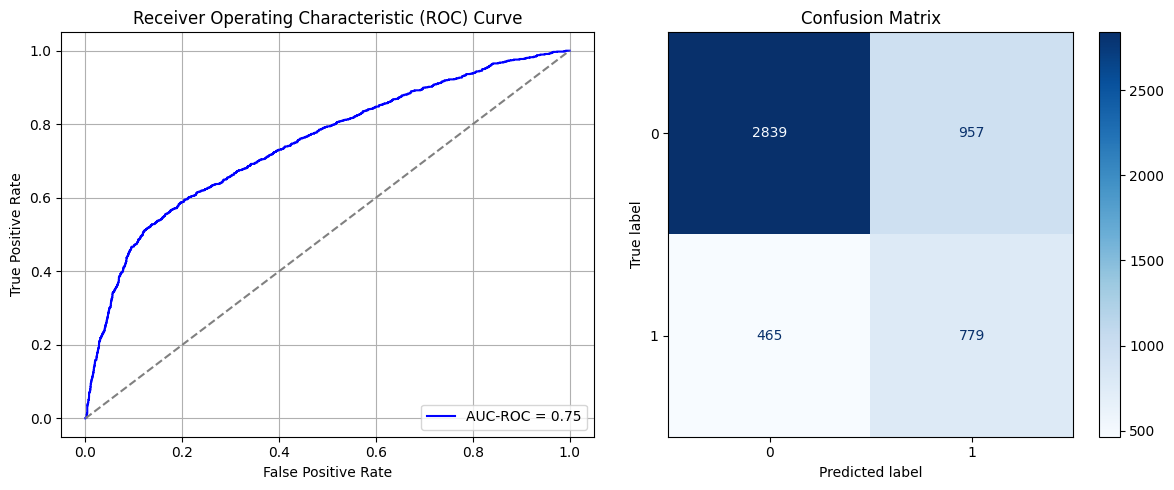

Best threshold based on F1-score: 0.9989688396453857
False Negative Rate: 0.3737942122186495
Time elapsed (performance): 0.7189766290000534
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6183 - loss: 0.6728 - val_AUC: 0.7031 - val_loss: 0.6188
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7079 - loss: 0.6149 - val_AUC: 0.7353 - val_loss: 0.5913
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7257 - loss: 0.6009 - val_AUC: 0.7500 - val_loss: 0.5835
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7401 - loss: 0.5913 - val_AUC: 0.7619 - val_loss: 0.5773
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7447 - loss: 0.5876 - val_AUC: 0.7614 - val_loss: 0.5723
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7412 - loss: 0.5914 - val_AUC: 0.7596 - val_loss: 0.5827
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7541 - loss: 0.5795 - val_AUC: 0.7647 - val_loss: 0.5679
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7470 - loss: 0.5846 - val_AUC: 0.7680 - val_loss: 0.5681
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7444 -

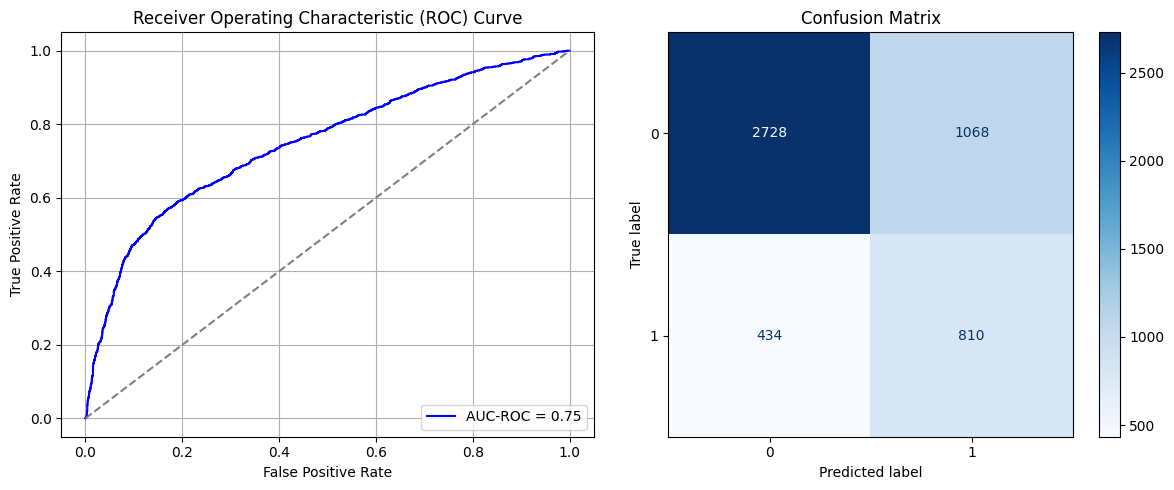

Best threshold based on F1-score: 0.9993370175361633
False Negative Rate: 0.34887459807073956
Time elapsed (performance): 0.7200791999999865
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6732 - loss: 0.6595 - val_AUC: 0.7054 - val_loss: 0.6177
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7214 - loss: 0.5999 - val_AUC: 0.7276 - val_loss: 0.6027
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7276 - loss: 0.5919 - val_AUC: 0.7406 - val_loss: 0.5945
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7380 - loss: 0.5877 - val_AUC: 0.7483 - val_loss: 0.5893
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7413 - loss: 0.5801 - val_AUC: 0.7510 - val_loss: 0.5867
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7483 - loss: 0.5833 - val_AUC: 0.7518 - val_loss: 0.5866
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7485 - loss: 0.5828 - val_AUC: 0.7540 - val_loss: 0.5873
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7473 - loss: 0.5823 - val_AUC: 0.7596 - val_loss: 0.5837
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7559 -

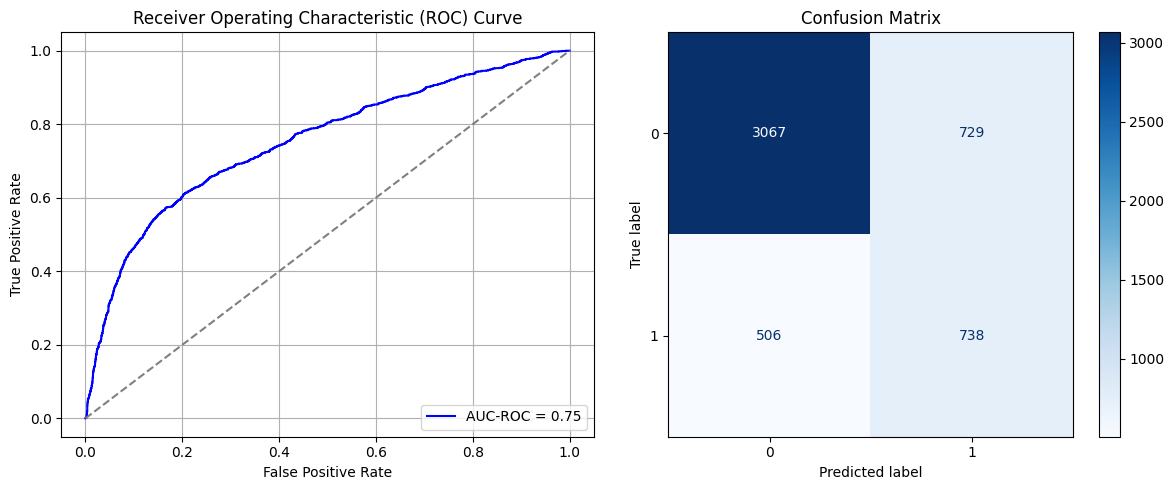

Best threshold based on F1-score: 0.997412919998169
False Negative Rate: 0.4067524115755627
Time elapsed (performance): 0.7336915639999688
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6619 - loss: 0.6640 - val_AUC: 0.7045 - val_loss: 0.6233
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7047 - loss: 0.6220 - val_AUC: 0.7314 - val_loss: 0.6066
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7382 - loss: 0.5973 - val_AUC: 0.7455 - val_loss: 0.5914
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7362 - loss: 0.5993 - val_AUC: 0.7495 - val_loss: 0.5990
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7347 - loss: 0.5991 - val_AUC: 0.7586 - val_loss: 0.5773
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7540 - loss: 0.5841 - val_AUC: 0.7604 - val_loss: 0.5772
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7393 - loss: 0.5928 - val_AUC: 0.7625 - val_loss: 0.5769
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7499 - loss: 0.5868 - val_AUC: 0.7630 - val_loss: 0.5700
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7453 -

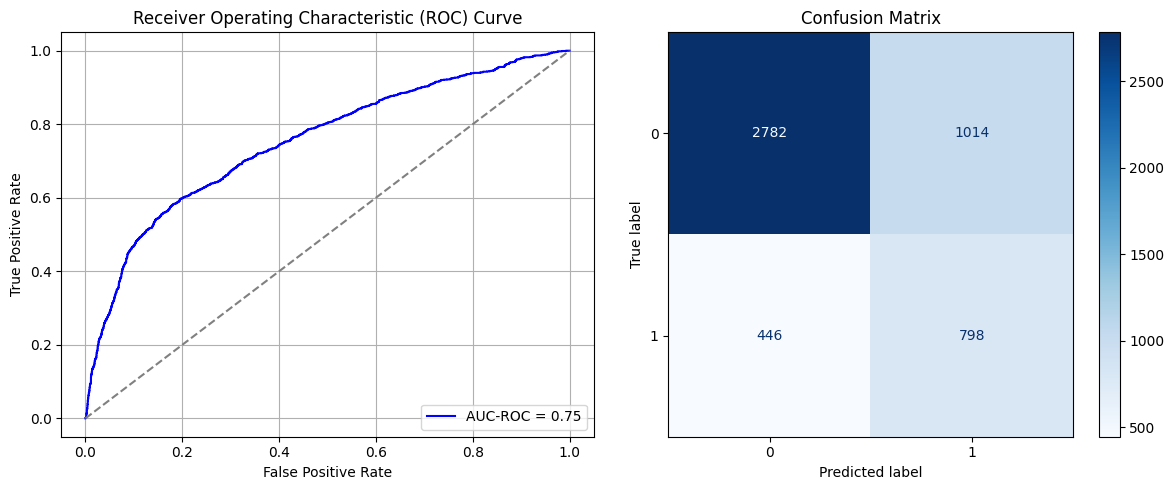

Best threshold based on F1-score: 0.9923234581947327
False Negative Rate: 0.35852090032154343
Time elapsed (performance): 0.7477442749999454
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6397 - loss: 0.6654 - val_AUC: 0.7081 - val_loss: 0.6188
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7063 - loss: 0.6170 - val_AUC: 0.7292 - val_loss: 0.5999
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7195 - loss: 0.6083 - val_AUC: 0.7351 - val_loss: 0.5934
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7383 - loss: 0.5923 - val_AUC: 0.7425 - val_loss: 0.5902
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7442 - loss: 0.5866 - val_AUC: 0.7449 - val_loss: 0.5876
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7562 - loss: 0.5785 - val_AUC: 0.7478 - val_loss: 0.5861
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7445 - loss: 0.5860 - val_AUC: 0.7480 - val_loss: 0.5849
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7518 - loss: 0.5804 - val_AUC: 0.7494 - val_loss: 0.5841
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7534 -

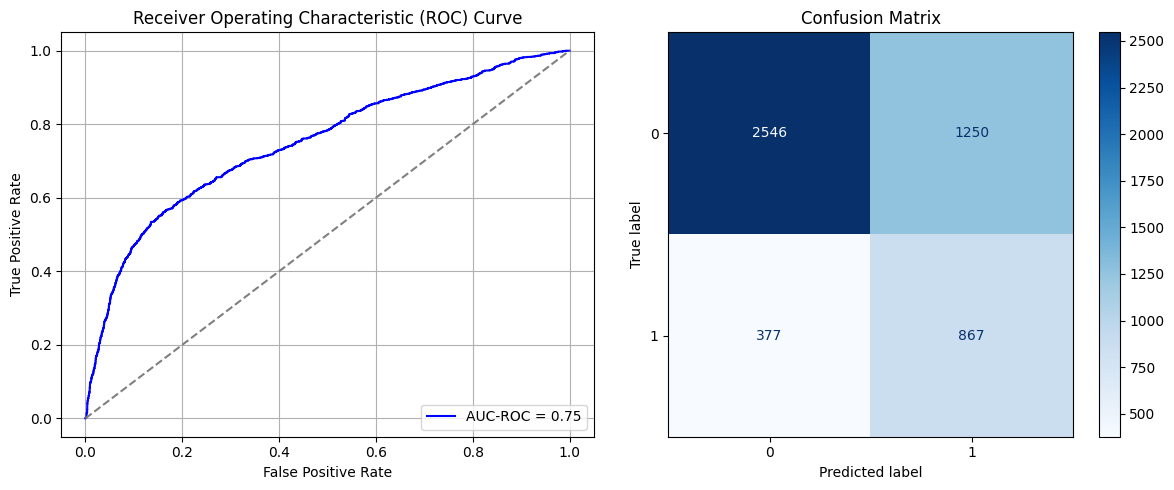

Best threshold based on F1-score: 0.9993811249732971
False Negative Rate: 0.30305466237942125
Time elapsed (performance): 1.294443028000046
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6290 - loss: 0.6687 - val_AUC: 0.7157 - val_loss: 0.6130
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7154 - loss: 0.6138 - val_AUC: 0.7436 - val_loss: 0.5904
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7414 - loss: 0.5930 - val_AUC: 0.7566 - val_loss: 0.5789
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7385 - loss: 0.5933 - val_AUC: 0.7487 - val_loss: 0.5824
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7452 - loss: 0.5903 - val_AUC: 0.7584 - val_loss: 0.5823
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7523 - loss: 0.5809 - val_AUC: 0.7644 - val_loss: 0.5699
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7448 - loss: 0.5895 - val_AUC: 0.7630 - val_loss: 0.5697
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7600 - loss: 0.5787 - val_AUC: 0.7605 - val_loss: 0.5703
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7570 -

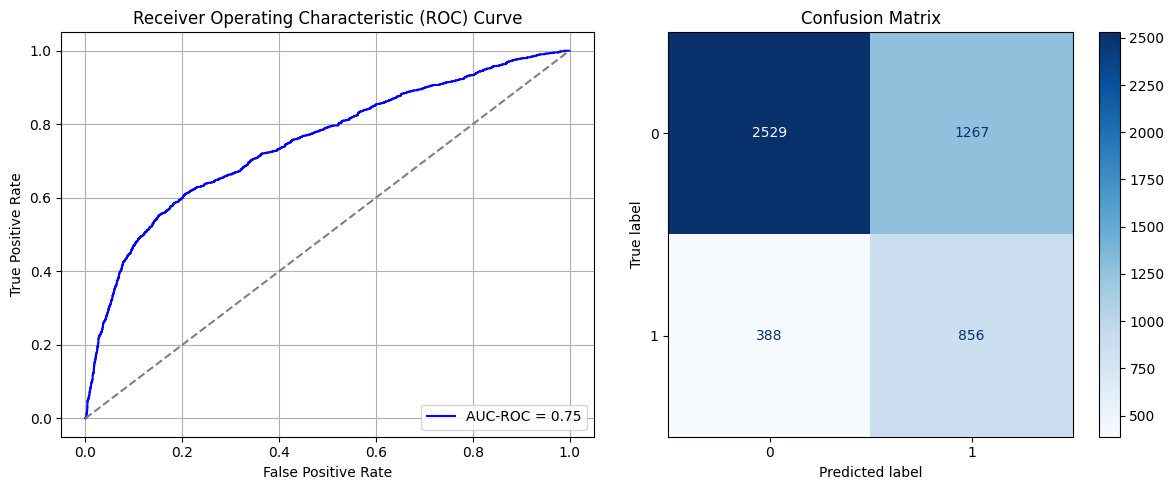

Best threshold based on F1-score: 0.9980911612510681
False Negative Rate: 0.31189710610932475
Time elapsed (performance): 0.7266494479999892
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6535 - loss: 0.6611 - val_AUC: 0.7009 - val_loss: 0.6246
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7175 - loss: 0.6106 - val_AUC: 0.7142 - val_loss: 0.6131
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7316 - loss: 0.6011 - val_AUC: 0.7252 - val_loss: 0.6075
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7359 - loss: 0.5940 - val_AUC: 0.7309 - val_loss: 0.6055
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7548 - loss: 0.5792 - val_AUC: 0.7396 - val_loss: 0.5995
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7488 - loss: 0.5793 - val_AUC: 0.7379 - val_loss: 0.5985
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7380 - loss: 0.5904 - val_AUC: 0.7361 - val_loss: 0.6050
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7534 - loss: 0.5832 - val_AUC: 0.7419 - val_loss: 0.5937
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7498 -

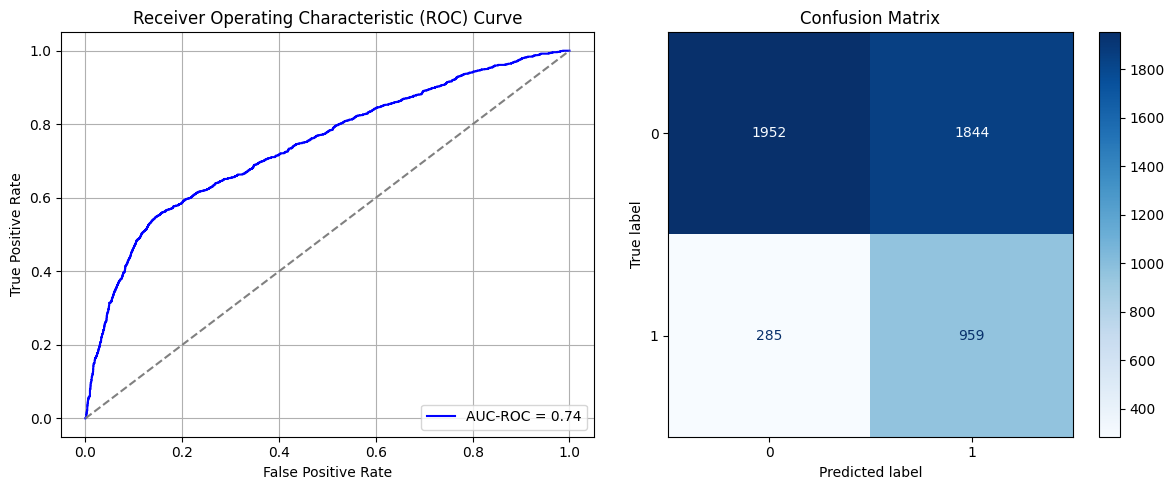

Best threshold based on F1-score: 0.9972561597824097
False Negative Rate: 0.22909967845659163
Time elapsed (performance): 0.7421142020000389
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6227 - loss: 0.6725 - val_AUC: 0.6979 - val_loss: 0.6262
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7138 - loss: 0.6160 - val_AUC: 0.7279 - val_loss: 0.6036
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7408 - loss: 0.5937 - val_AUC: 0.7433 - val_loss: 0.5942
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7334 - loss: 0.5946 - val_AUC: 0.7471 - val_loss: 0.5889
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7402 - loss: 0.5914 - val_AUC: 0.7509 - val_loss: 0.5879
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7441 - loss: 0.5859 - val_AUC: 0.7510 - val_loss: 0.5904
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7386 - loss: 0.5908 - val_AUC: 0.7526 - val_loss: 0.5864
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7552 - loss: 0.5766 - val_AUC: 0.7595 - val_loss: 0.5841
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7603 -

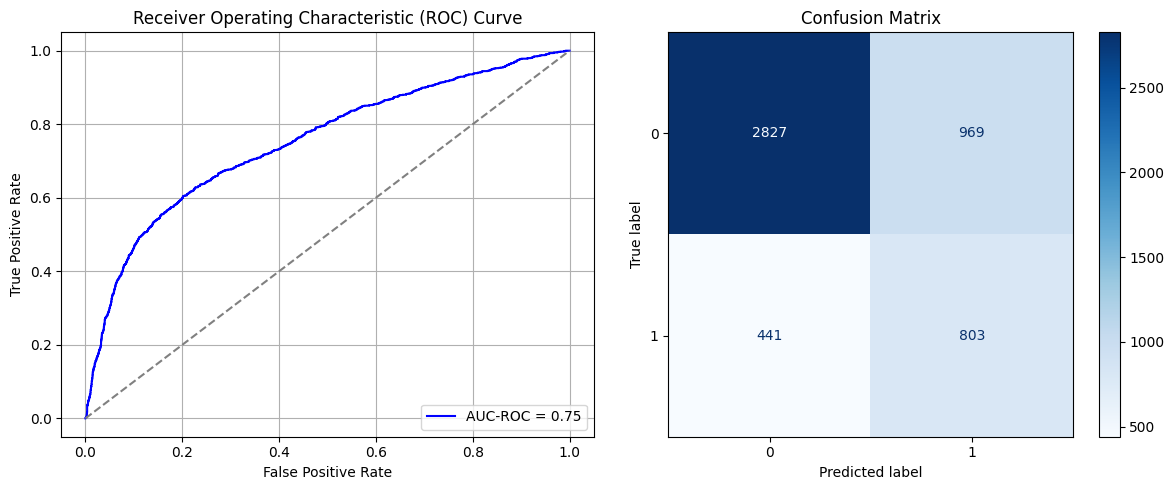

Best threshold based on F1-score: 0.9958078265190125
False Negative Rate: 0.3545016077170418
Time elapsed (performance): 0.7186869240000533
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5945 - loss: 0.6764 - val_AUC: 0.7060 - val_loss: 0.6136
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6975 - loss: 0.6175 - val_AUC: 0.7303 - val_loss: 0.5928
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7213 - loss: 0.6029 - val_AUC: 0.7475 - val_loss: 0.5859
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7356 - loss: 0.5892 - val_AUC: 0.7533 - val_loss: 0.5810
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7450 - loss: 0.5865 - val_AUC: 0.7584 - val_loss: 0.5758
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7360 - loss: 0.5899 - val_AUC: 0.7612 - val_loss: 0.5750
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7566 - loss: 0.5737 - val_AUC: 0.7640 - val_loss: 0.5729
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7516 - loss: 0.5753 - val_AUC: 0.7671 - val_loss: 0.5718
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7645 -

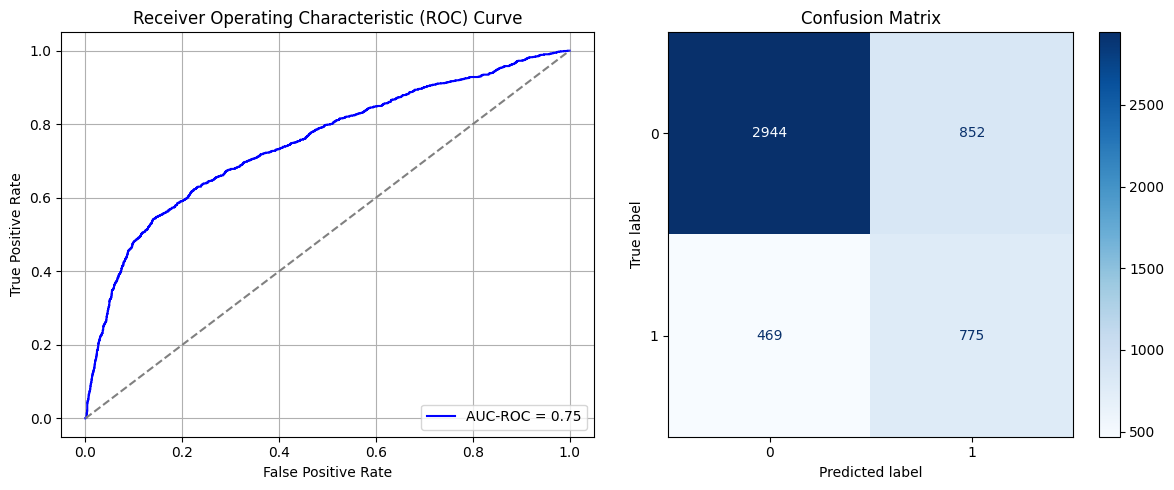

Best threshold based on F1-score: 0.9993294477462769
False Negative Rate: 0.3770096463022508
Time elapsed (performance): 1.4019937620000746
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.6298 - loss: 0.6683 - val_AUC: 0.7187 - val_loss: 0.6281
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7246 - loss: 0.6054 - val_AUC: 0.7324 - val_loss: 0.5990
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7248 - loss: 0.5997 - val_AUC: 0.7399 - val_loss: 0.5953
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7362 - loss: 0.5962 - val_AUC: 0.7408 - val_loss: 0.5922
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7450 - loss: 0.5861 - val_AUC: 0.7486 - val_loss: 0.5912
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7468 - loss: 0.5809 - val_AUC: 0.7497 - val_loss: 0.5863
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7515 - loss: 0.5839 - val_AUC: 0.7532 - val_loss: 0.5848
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7450 - loss: 0.5856 - val_AUC: 0.7506 - val_loss: 0.5851
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7545 -

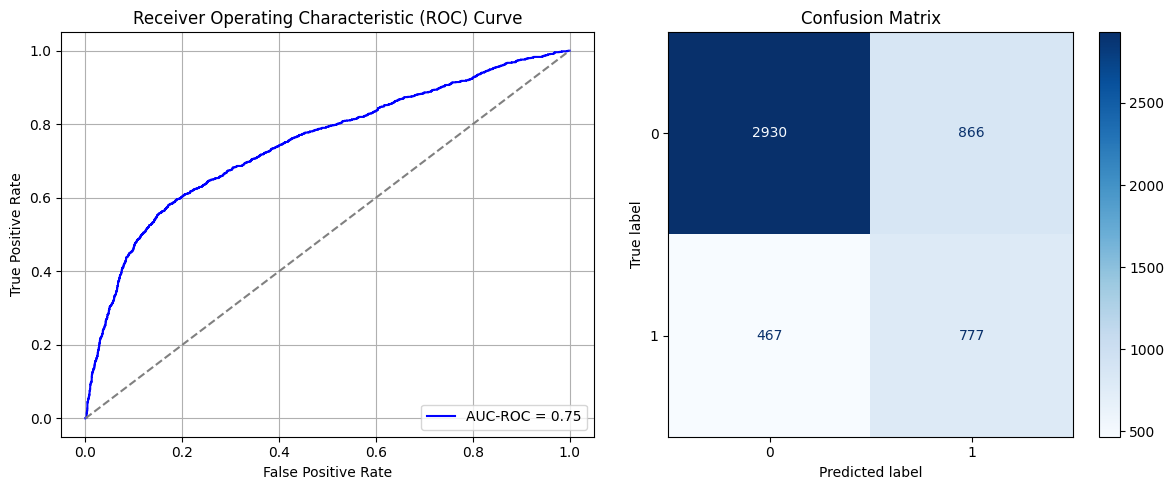

Best threshold based on F1-score: 0.9993863701820374
False Negative Rate: 0.3754019292604502
Time elapsed (performance): 0.9184318110001186


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [30]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=False)
    data_S_SRS_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRS = data_S_SRS_RUS.iloc[:, :-1]
    y_S_SRS = data_S_SRS_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
    model_SRS = create_dnn_model(X_S_train.shape[1])
    result_SRS = train_and_evaluate(model_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS = Transductive_TL(model_SRS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS)
    FPR.append(result_TL_SRS[0])
    TPR.append(result_TL_SRS[1])
    FNR.append(result_TL_SRS[2])
    TNR.append(result_TL_SRS[3])
    TL_time.append(result_TL_SRS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

In [31]:
print(ParamFit)
ParamFit.to_csv('SRS_RUS.csv')

   Source time       FPR       TPR       FNR       TNR  Target time
0    13.969765  0.252107  0.747893  0.373794  0.626206     0.718977
1    13.954535  0.281349  0.718651  0.348875  0.651125     0.720079
2    13.582563  0.192044  0.807956  0.406752  0.593248     0.733692
3    12.079729  0.267123  0.732877  0.358521  0.641479     0.747744
4    14.896344  0.329294  0.670706  0.303055  0.696945     1.294443
5    12.427044  0.333772  0.666228  0.311897  0.688103     0.726649
6    12.885079  0.485774  0.514226  0.229100  0.770900     0.742114
7    14.594298  0.255269  0.744731  0.354502  0.645498     0.718687
8    15.334066  0.224447  0.775553  0.377010  0.622990     1.401994
9    15.539282  0.228135  0.771865  0.375402  0.624598     0.918432


## Simple Random Sampling with Replacement:

In [32]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

5366
19249


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6136 - loss: 0.6702 - val_AUC: 0.7160 - val_loss: 0.6083
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7256 - loss: 0.6022 - val_AUC: 0.7439 - val_loss: 0.5942
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7364 - loss: 0.5979 - val_AUC: 0.7492 - val_loss: 0.5910
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7358 - loss: 0.5971 - val_AUC: 0.7541 - val_loss: 0.5854
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7457 - loss: 0.5860 - val_AUC: 0.7556 - val_loss: 0.5831
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7379 - loss: 0.5923 - val_AUC: 0.7541 - val_loss: 0.5838
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7496 - loss: 0.5818 - val_AUC: 0.7572 - val_loss: 0.5809
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7479 - loss: 0.5859 - val_AUC: 0.7618 - val_loss: 0.5784
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7629 -

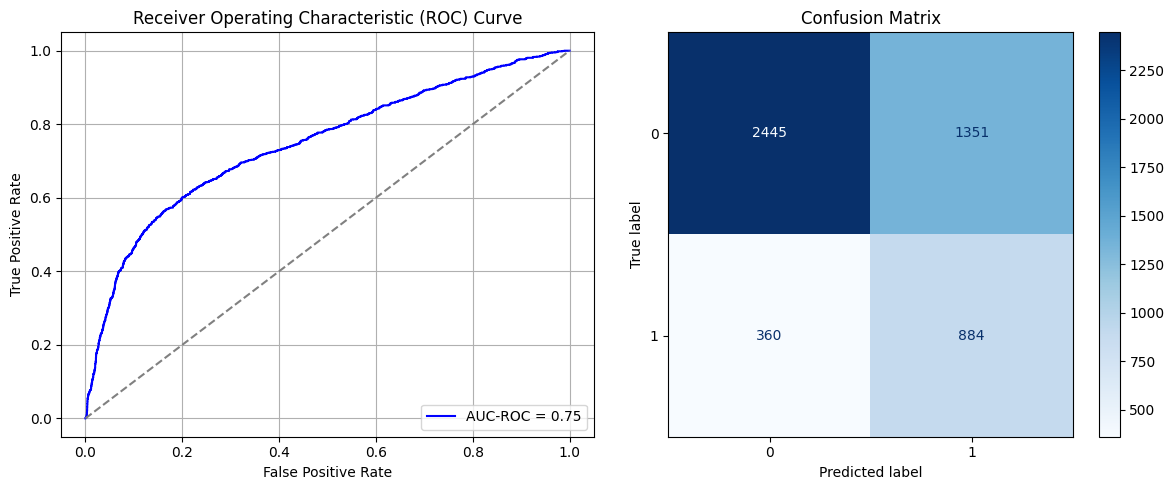

Best threshold based on F1-score: 0.9992853999137878
False Negative Rate: 0.28938906752411575
Time elapsed (performance): 0.7407111530001202
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6687 - loss: 0.6631 - val_AUC: 0.7225 - val_loss: 0.6199
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7117 - loss: 0.6122 - val_AUC: 0.7403 - val_loss: 0.5932
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7364 - loss: 0.5948 - val_AUC: 0.7514 - val_loss: 0.5829
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7302 - loss: 0.5983 - val_AUC: 0.7575 - val_loss: 0.5818
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7393 - loss: 0.5945 - val_AUC: 0.7571 - val_loss: 0.5748
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7608 - loss: 0.5744 - val_AUC: 0.7640 - val_loss: 0.5764
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7513 - loss: 0.5854 - val_AUC: 0.7630 - val_loss: 0.5730
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7461 - loss: 0.5825 - val_AUC: 0.7670 - val_loss: 0.5726
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7517 -

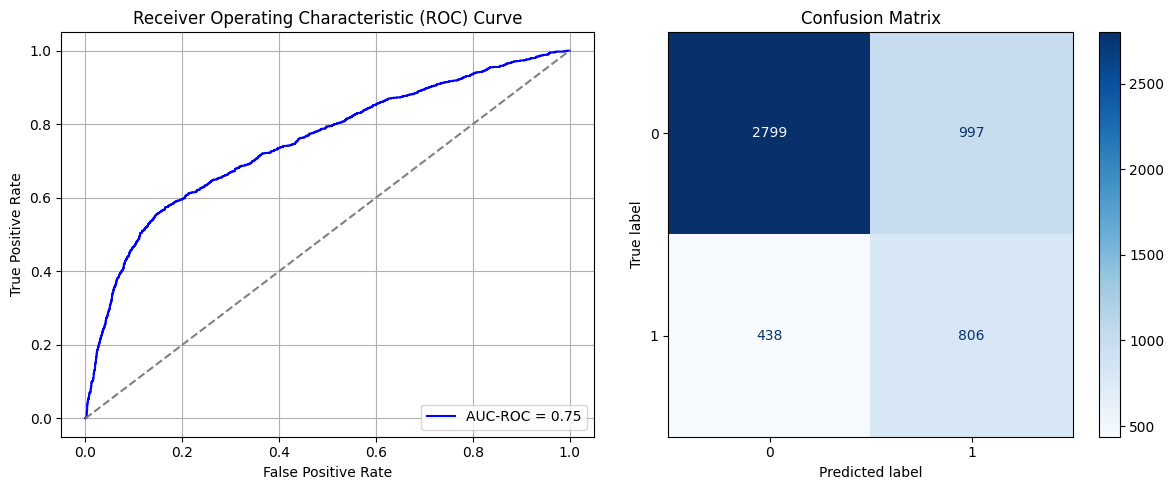

Best threshold based on F1-score: 0.9992607831954956
False Negative Rate: 0.3520900321543408
Time elapsed (performance): 0.7139915909999672
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6149 - loss: 0.6714 - val_AUC: 0.7237 - val_loss: 0.6181
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7022 - loss: 0.6187 - val_AUC: 0.7433 - val_loss: 0.5847
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7260 - loss: 0.6029 - val_AUC: 0.7634 - val_loss: 0.5861
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7341 - loss: 0.5992 - val_AUC: 0.7668 - val_loss: 0.5689
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7331 - loss: 0.5984 - val_AUC: 0.7698 - val_loss: 0.5658
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7450 - loss: 0.5882 - val_AUC: 0.7690 - val_loss: 0.5627
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7377 - loss: 0.5913 - val_AUC: 0.7646 - val_loss: 0.5636
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7435 - loss: 0.5846 - val_AUC: 0.7721 - val_loss: 0.5633
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7503 -

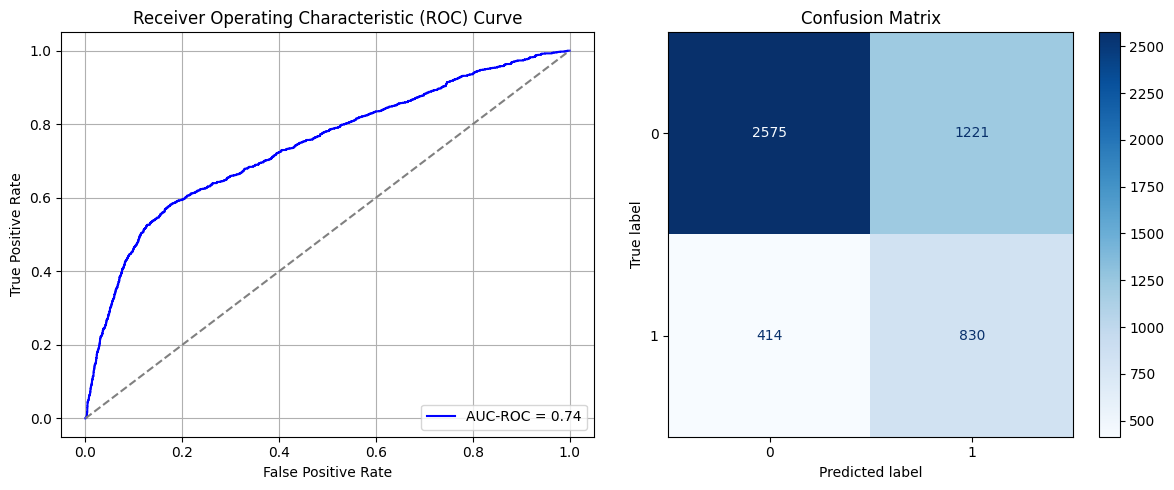

Best threshold based on F1-score: 0.9982591271400452
False Negative Rate: 0.3327974276527331
Time elapsed (performance): 0.7024358460000713
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6498 - loss: 0.6663 - val_AUC: 0.7092 - val_loss: 0.6108
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7197 - loss: 0.6040 - val_AUC: 0.7289 - val_loss: 0.5957
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7297 - loss: 0.5949 - val_AUC: 0.7398 - val_loss: 0.5903
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7353 - loss: 0.5909 - val_AUC: 0.7411 - val_loss: 0.5913
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7541 - loss: 0.5811 - val_AUC: 0.7500 - val_loss: 0.5828
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7564 - loss: 0.5741 - val_AUC: 0.7472 - val_loss: 0.5933
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7586 - loss: 0.5726 - val_AUC: 0.7549 - val_loss: 0.5779
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7518 - loss: 0.5798 - val_AUC: 0.7539 - val_loss: 0.5786
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7697 -

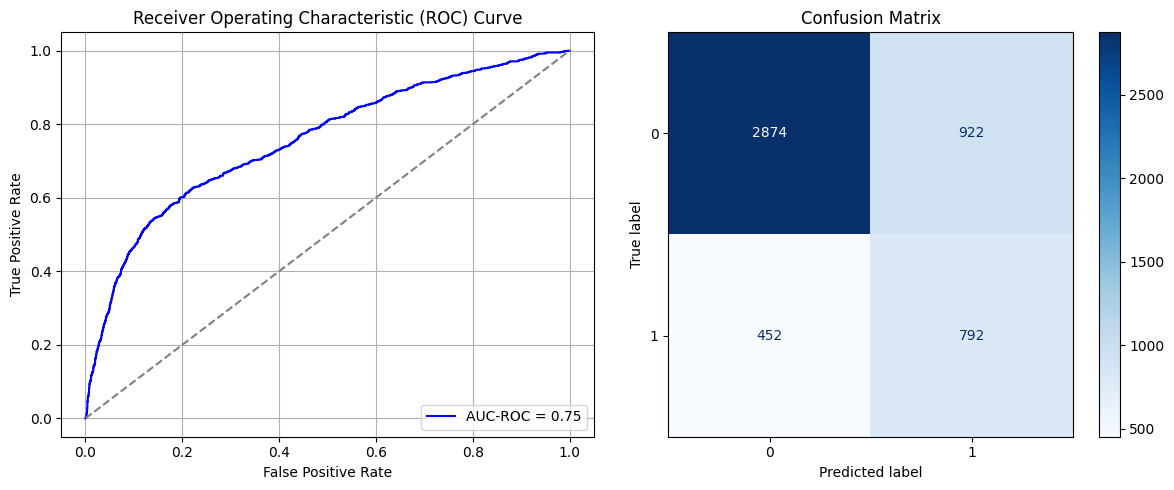

Best threshold based on F1-score: 0.9986268877983093
False Negative Rate: 0.3633440514469453
Time elapsed (performance): 0.7383499070001562
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6520 - loss: 0.6646 - val_AUC: 0.6919 - val_loss: 0.6566
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7150 - loss: 0.6117 - val_AUC: 0.7110 - val_loss: 0.6164
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7282 - loss: 0.5997 - val_AUC: 0.7362 - val_loss: 0.6008
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7438 - loss: 0.5838 - val_AUC: 0.7422 - val_loss: 0.5960
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7327 - loss: 0.5911 - val_AUC: 0.7421 - val_loss: 0.5977
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7460 - loss: 0.5818 - val_AUC: 0.7488 - val_loss: 0.5901
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7477 - loss: 0.5830 - val_AUC: 0.7450 - val_loss: 0.5999
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7534 - loss: 0.5784 - val_AUC: 0.7523 - val_loss: 0.5882
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7554 -

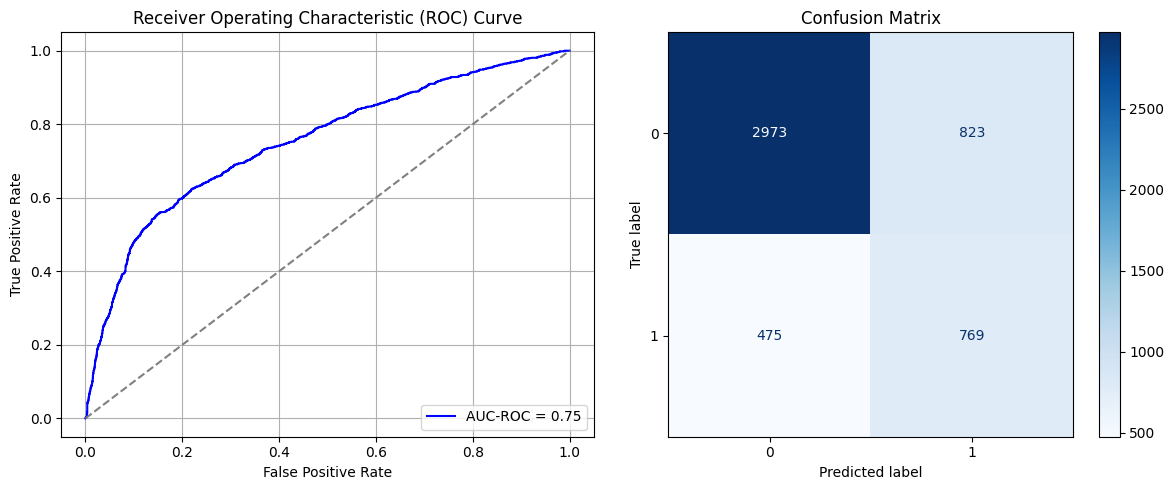

Best threshold based on F1-score: 0.9981105923652649
False Negative Rate: 0.38183279742765275
Time elapsed (performance): 0.7291362820001268
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6671 - loss: 0.6616 - val_AUC: 0.7095 - val_loss: 0.6146
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7071 - loss: 0.6136 - val_AUC: 0.7303 - val_loss: 0.5961
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7282 - loss: 0.5998 - val_AUC: 0.7384 - val_loss: 0.5916
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7425 - loss: 0.5832 - val_AUC: 0.7439 - val_loss: 0.5880
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7483 - loss: 0.5777 - val_AUC: 0.7450 - val_loss: 0.5863
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7542 - loss: 0.5734 - val_AUC: 0.7504 - val_loss: 0.5833
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7523 - loss: 0.5776 - val_AUC: 0.7506 - val_loss: 0.5834
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7600 - loss: 0.5732 - val_AUC: 0.7535 - val_loss: 0.5826
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7621 -

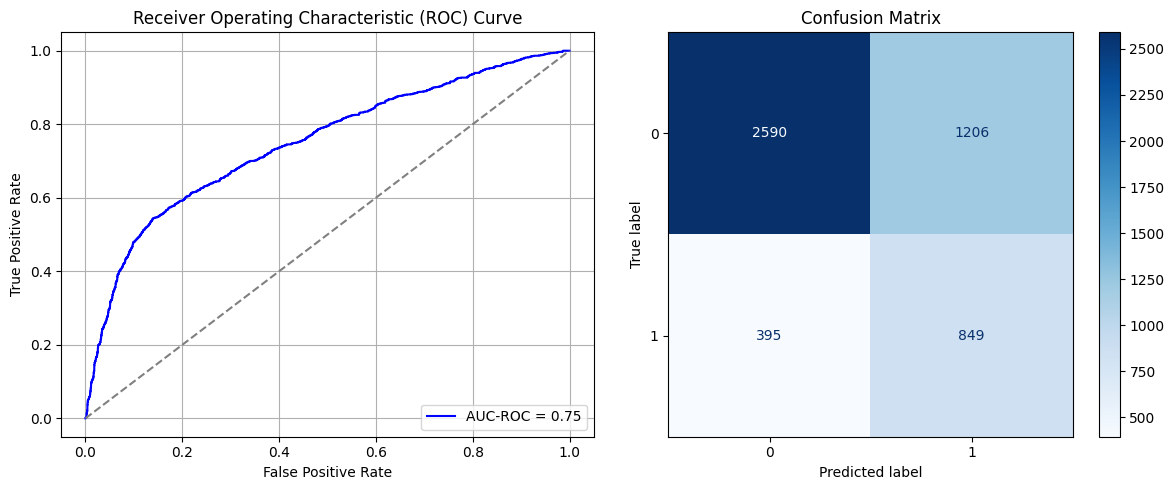

Best threshold based on F1-score: 0.9993399381637573
False Negative Rate: 0.317524115755627
Time elapsed (performance): 0.7448256060001768
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6033 - loss: 0.6744 - val_AUC: 0.7016 - val_loss: 0.6250
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7112 - loss: 0.6173 - val_AUC: 0.7374 - val_loss: 0.5971
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7326 - loss: 0.5964 - val_AUC: 0.7523 - val_loss: 0.5861
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7433 - loss: 0.5885 - val_AUC: 0.7547 - val_loss: 0.5820
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7472 - loss: 0.5830 - val_AUC: 0.7571 - val_loss: 0.5790
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7508 - loss: 0.5816 - val_AUC: 0.7604 - val_loss: 0.5756
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7532 - loss: 0.5812 - val_AUC: 0.7603 - val_loss: 0.5754
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7515 - loss: 0.5800 - val_AUC: 0.7638 - val_loss: 0.5737
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7637 -

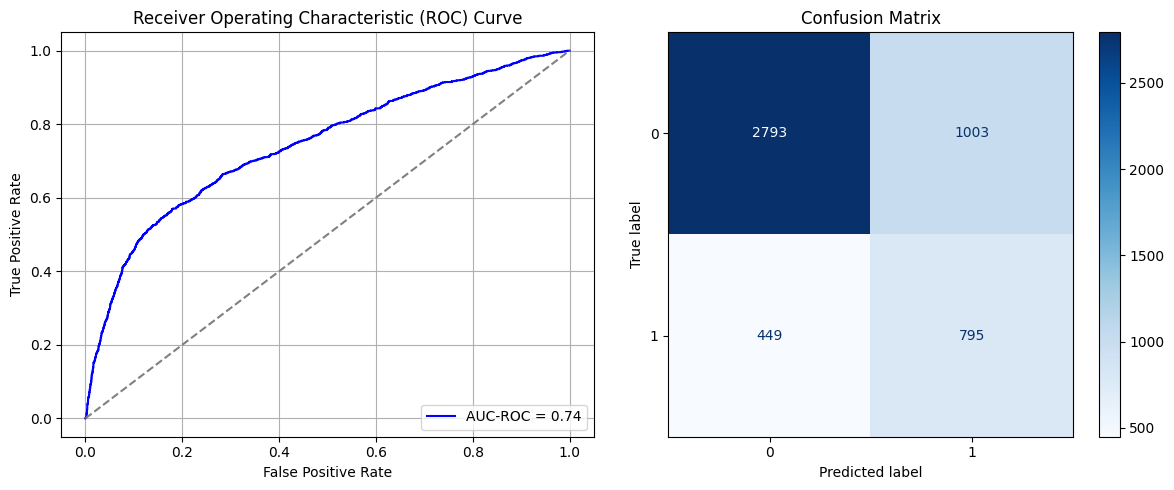

Best threshold based on F1-score: 0.9976093769073486
False Negative Rate: 0.3609324758842444
Time elapsed (performance): 1.099213797999937
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6522 - loss: 0.6604 - val_AUC: 0.7417 - val_loss: 0.5825
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7172 - loss: 0.6034 - val_AUC: 0.7621 - val_loss: 0.5668
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7331 - loss: 0.5930 - val_AUC: 0.7738 - val_loss: 0.5565
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7481 - loss: 0.5803 - val_AUC: 0.7766 - val_loss: 0.5501
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7423 - loss: 0.5846 - val_AUC: 0.7767 - val_loss: 0.5586
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7581 - loss: 0.5717 - val_AUC: 0.7815 - val_loss: 0.5487
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7436 - loss: 0.5849 - val_AUC: 0.7862 - val_loss: 0.5471
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7605 - loss: 0.5615 - val_AUC: 0.7876 - val_loss: 0.5520
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7594 -

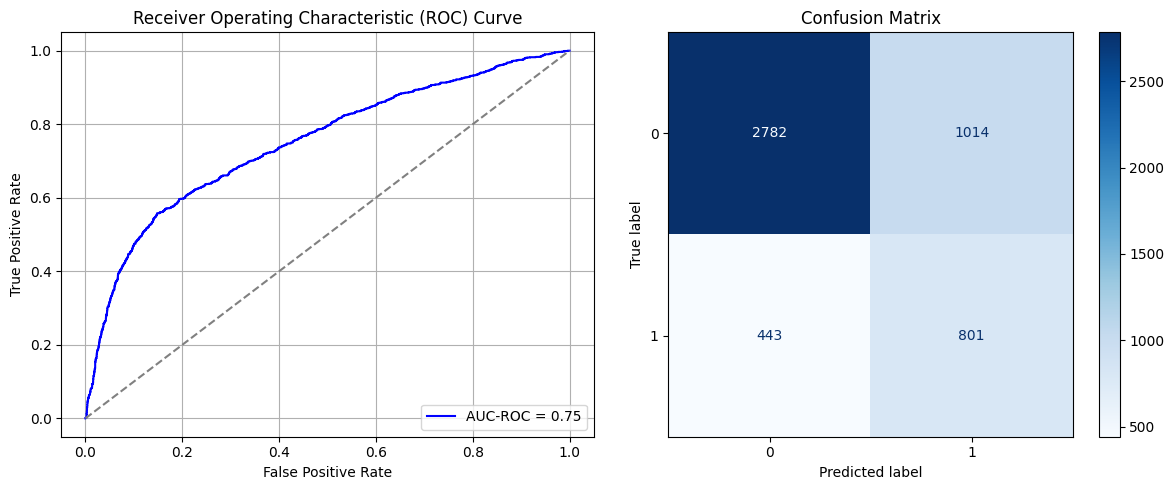

Best threshold based on F1-score: 0.9992765188217163
False Negative Rate: 0.35610932475884244
Time elapsed (performance): 0.7528812350001317
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6440 - loss: 0.6604 - val_AUC: 0.7068 - val_loss: 0.6101
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7306 - loss: 0.5969 - val_AUC: 0.7309 - val_loss: 0.5960
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7429 - loss: 0.5900 - val_AUC: 0.7424 - val_loss: 0.5878
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7582 - loss: 0.5764 - val_AUC: 0.7432 - val_loss: 0.5856
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7587 - loss: 0.5761 - val_AUC: 0.7473 - val_loss: 0.5833
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7590 - loss: 0.5719 - val_AUC: 0.7542 - val_loss: 0.5802
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7425 - loss: 0.5823 - val_AUC: 0.7529 - val_loss: 0.5809
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7587 - loss: 0.5749 - val_AUC: 0.7539 - val_loss: 0.5846
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7721 -

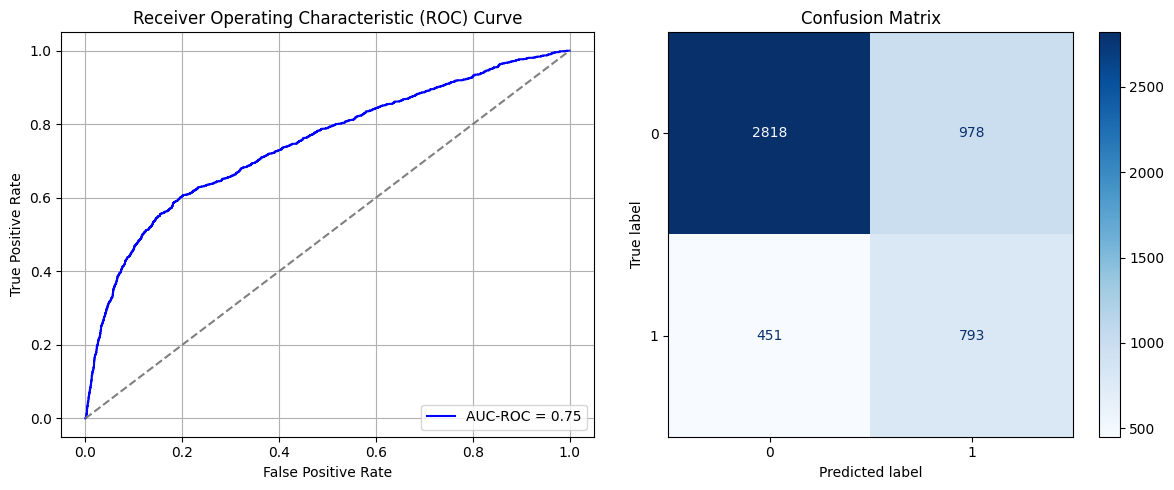

Best threshold based on F1-score: 0.9991881251335144
False Negative Rate: 0.362540192926045
Time elapsed (performance): 0.7372520110000096
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6587 - loss: 0.6632 - val_AUC: 0.7064 - val_loss: 0.6184
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7130 - loss: 0.6115 - val_AUC: 0.7404 - val_loss: 0.6034
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7470 - loss: 0.5861 - val_AUC: 0.7472 - val_loss: 0.5938
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7447 - loss: 0.5833 - val_AUC: 0.7469 - val_loss: 0.6066
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7429 - loss: 0.5882 - val_AUC: 0.7509 - val_loss: 0.5898
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7577 - loss: 0.5722 - val_AUC: 0.7584 - val_loss: 0.5881
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7520 - loss: 0.5758 - val_AUC: 0.7561 - val_loss: 0.5896
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7491 - loss: 0.5850 - val_AUC: 0.7594 - val_loss: 0.5840
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7561 -

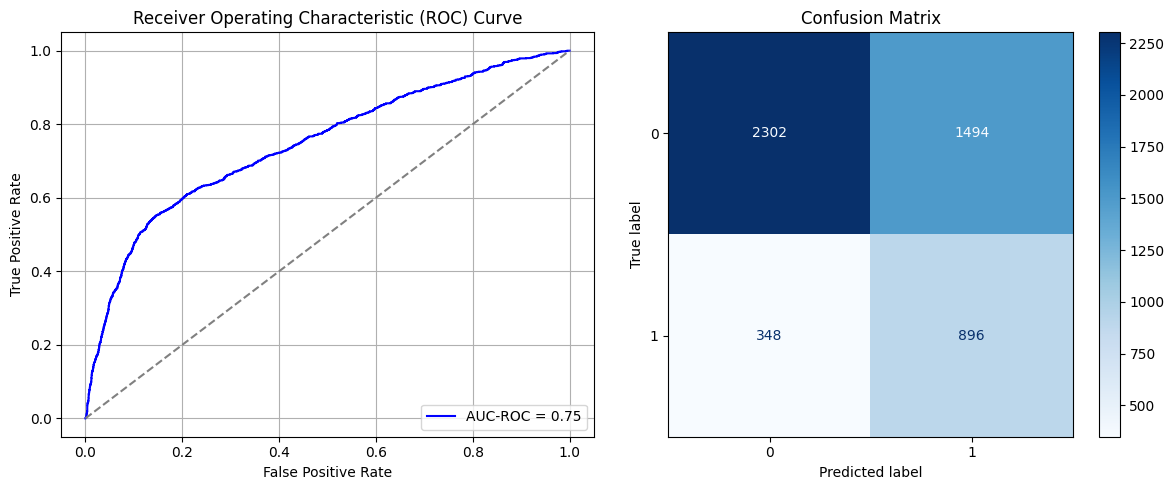

Best threshold based on F1-score: 0.9994028210639954
False Negative Rate: 0.2797427652733119
Time elapsed (performance): 1.0651520899998559


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [33]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=True)
    data_S_SRSwR_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRSwR = data_S_SRSwR_RUS.iloc[:, :-1]
    y_S_SRSwR = data_S_SRSwR_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
    model_SRSwR = create_dnn_model(X_S_train.shape[1])
    result_SRSwR = train_and_evaluate(model_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRSwR = Transductive_TL(model_SRSwR, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRSwR)
    FPR.append(result_TL_SRSwR[0])
    TNR.append(result_TL_SRSwR[1])
    FNR.append(result_TL_SRSwR[2])
    TPR.append(result_TL_SRSwR[3])
    TL_time.append(result_TL_SRSwR[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [34]:
print(ParamFit)
ParamFit.to_csv('SRSwR_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    14.656518  0.355901  0.644099  0.289389  0.710611     0.740711
1    12.765891  0.262645  0.737355  0.352090  0.647910     0.713992
2    12.678927  0.321654  0.678346  0.332797  0.667203     0.702436
3    12.886146  0.242887  0.757113  0.363344  0.636656     0.738350
4    12.523475  0.216807  0.783193  0.381833  0.618167     0.729136
5    13.342014  0.317703  0.682297  0.317524  0.682476     0.744826
6    14.350066  0.264226  0.735774  0.360932  0.639068     1.099214
7    13.661467  0.267123  0.732877  0.356109  0.643891     0.752881
8    13.006239  0.257640  0.742360  0.362540  0.637460     0.737252
9    13.439192  0.393572  0.606428  0.279743  0.720257     1.065152


## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

3.587215803205367
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6223 - loss: 0.6740 - val_AUC: 0.7006 - val_loss: 0.6241
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7047 - loss: 0.6180 - val_AUC: 0.7262 - val_loss: 0.6023
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7306 - loss: 0.5996 - val_AUC: 0.7407 - val_loss: 0.5968
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7262 - loss: 0.6024 - val_AUC: 0.7456 - val_loss: 0.5873
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7372 - loss: 0.5939 - val_AUC: 0.7551 - val_loss: 0.5835
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7397 - loss: 0.5899 - val_AUC: 0.7559 - val_loss: 0.5791
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7391 - loss: 0.5916 - val_AUC: 0.7628 - val_loss: 0.5787
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7407 - loss: 0.5916 - val_AUC: 0.7655 - val_loss: 0.5754
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7479 -

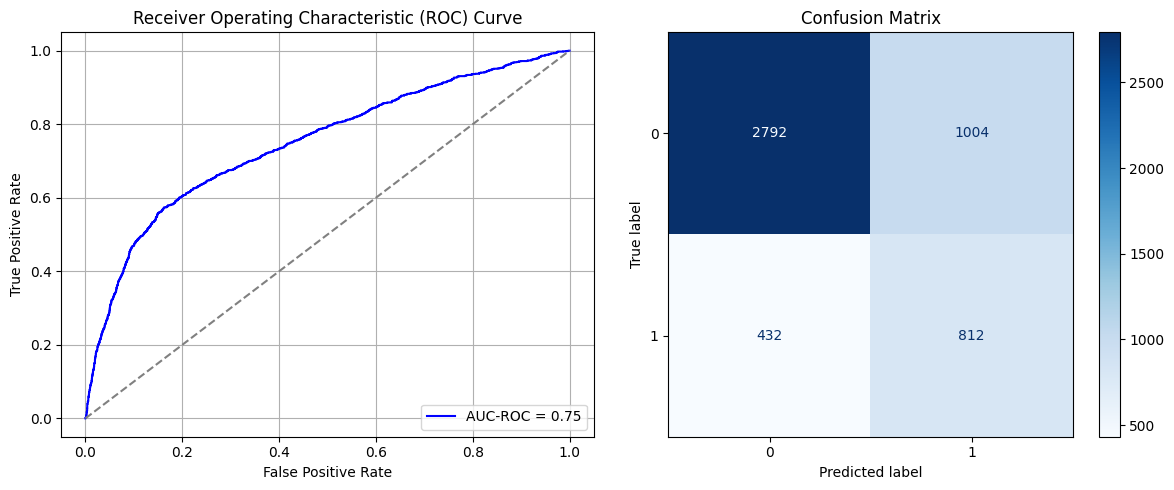

Best threshold based on F1-score: 0.9964427351951599
False Negative Rate: 0.34726688102893893
Time elapsed (performance): 0.7715524600000663
(np.float64(0.2644889357218124), np.float64(0.7355110642781876))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6464 - loss: 0.6665 - val_AUC: 0.7034 - val_loss: 0.6184
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7083 - loss: 0.6177 - val_AUC: 0.7400 - val_loss: 0.5969
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7221 - loss: 0.6073 - val_AUC: 0.7383 - val_loss: 0.5977
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7315 - loss: 0.5952 - val_AUC: 0.7571 - val_loss: 0.5821
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7393 - loss: 0.5913 - val_AUC: 0.7607 - val_loss: 0.5815
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7395 - loss: 0.5915 - val_AUC: 0.7652 - val_loss: 0.5756
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7379 - loss: 0.5944 - val_AUC: 0.7633 - val_loss: 0.5739
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7460 - loss: 0.5862 - val_AUC: 0.7680 - val_loss: 0.5712
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7473 -

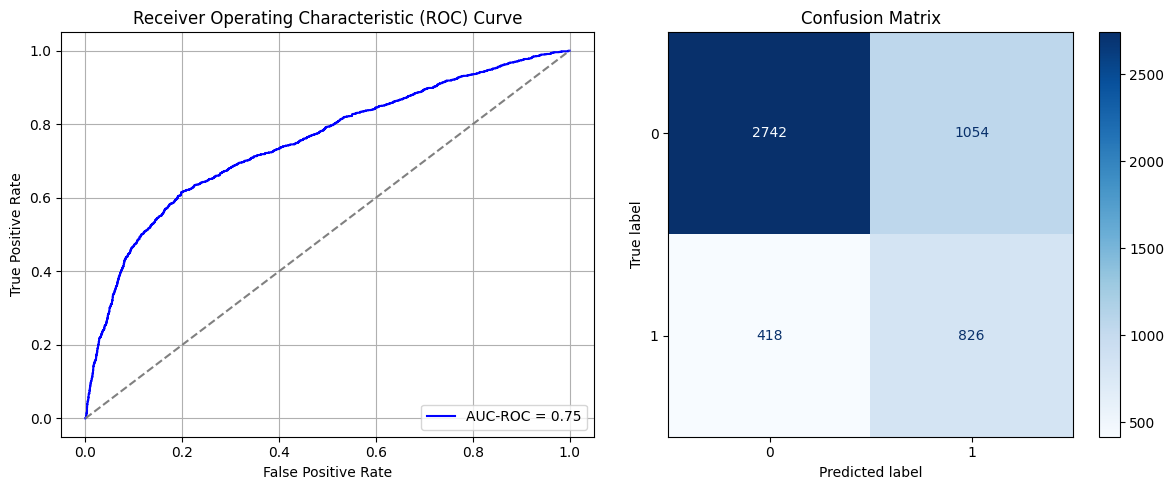

Best threshold based on F1-score: 0.9964821934700012
False Negative Rate: 0.3360128617363344
Time elapsed (performance): 0.7959442880001006
(np.float64(0.27766069546891464), np.float64(0.7223393045310853))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.6515 - loss: 0.6624 - val_AUC: 0.7062 - val_loss: 0.6172
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7057 - loss: 0.6194 - val_AUC: 0.7298 - val_loss: 0.6028
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7211 - loss: 0.6063 - val_AUC: 0.7496 - val_loss: 0.5885
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7277 - loss: 0.6003 - val_AUC: 0.7530 - val_loss: 0.5830
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7226 - loss: 0.6072 - val_AUC: 0.7535 - val_loss: 0.5813
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7435 - loss: 0.5883 - val_AUC: 0.7631 - val_loss: 0.5790
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7429 - loss: 0.5923 - val_AUC: 0.7623 - val_loss: 0.5752
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7363 - loss: 0.5954 - val_AUC: 0.7652 - val_loss: 0.5762
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7537 -

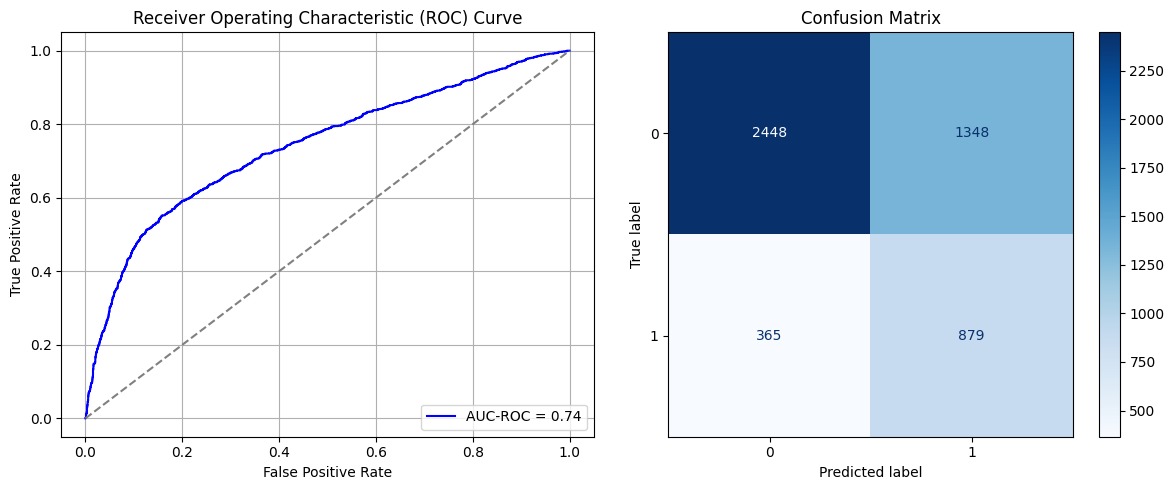

Best threshold based on F1-score: 0.9972108602523804
False Negative Rate: 0.2934083601286174
Time elapsed (performance): 0.7333004199999777
(np.float64(0.35511064278187565), np.float64(0.6448893572181243))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6397 - loss: 0.6637 - val_AUC: 0.7137 - val_loss: 0.6181
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7081 - loss: 0.6134 - val_AUC: 0.7408 - val_loss: 0.5964
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7235 - loss: 0.6009 - val_AUC: 0.7497 - val_loss: 0.5863
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7523 - loss: 0.5838 - val_AUC: 0.7539 - val_loss: 0.5911
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7537 - loss: 0.5775 - val_AUC: 0.7610 - val_loss: 0.5798
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7478 - loss: 0.5867 - val_AUC: 0.7633 - val_loss: 0.5780
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7494 - loss: 0.5844 - val_AUC: 0.7636 - val_loss: 0.5750
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7540 - loss: 0.5782 - val_AUC: 0.7630 - val_loss: 0.5746
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7573 -

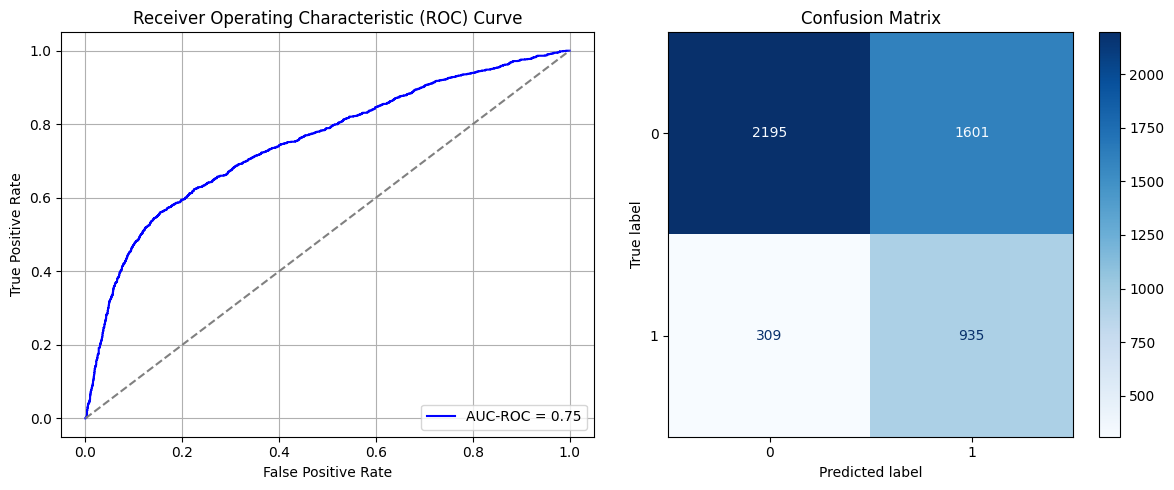

Best threshold based on F1-score: 0.9975029230117798
False Negative Rate: 0.24839228295819935
Time elapsed (performance): 1.072361944000022
(np.float64(0.42175974710221287), np.float64(0.5782402528977871))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6100 - loss: 0.6765 - val_AUC: 0.7037 - val_loss: 0.6236
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7248 - loss: 0.6078 - val_AUC: 0.7429 - val_loss: 0.5976
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7302 - loss: 0.5982 - val_AUC: 0.7531 - val_loss: 0.5894
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7501 - loss: 0.5844 - val_AUC: 0.7515 - val_loss: 0.5875
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7459 - loss: 0.5837 - val_AUC: 0.7529 - val_loss: 0.5825
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7307 - loss: 0.5966 - val_AUC: 0.7581 - val_loss: 0.5797
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7564 - loss: 0.5786 - val_AUC: 0.7647 - val_loss: 0.5833
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7495 - loss: 0.5845 - val_AUC: 0.7634 - val_loss: 0.5754
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7525 -

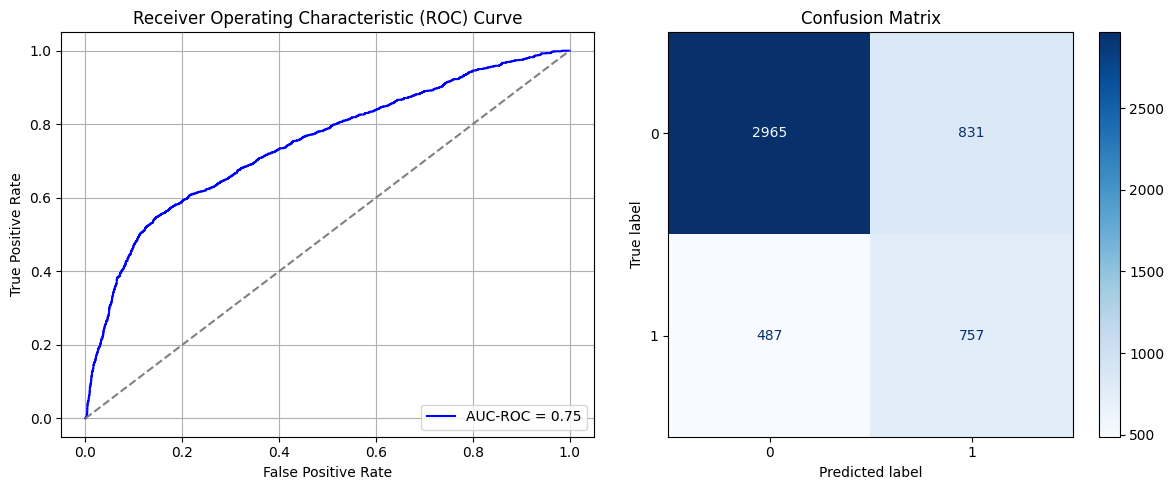

Best threshold based on F1-score: 0.9971665143966675
False Negative Rate: 0.39147909967845657
Time elapsed (performance): 2.053121112000099
(np.float64(0.21891464699683877), np.float64(0.7810853530031612))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6314 - loss: 0.6697 - val_AUC: 0.7061 - val_loss: 0.6211
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7089 - loss: 0.6186 - val_AUC: 0.7333 - val_loss: 0.6026
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7231 - loss: 0.6058 - val_AUC: 0.7449 - val_loss: 0.5905
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7236 - loss: 0.6027 - val_AUC: 0.7523 - val_loss: 0.5863
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7325 - loss: 0.5999 - val_AUC: 0.7541 - val_loss: 0.5875
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7382 - loss: 0.5933 - val_AUC: 0.7560 - val_loss: 0.5826
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7438 - loss: 0.5883 - val_AUC: 0.7549 - val_loss: 0.5796
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7400 - loss: 0.5959 - val_AUC: 0.7596 - val_loss: 0.5769
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7367 -

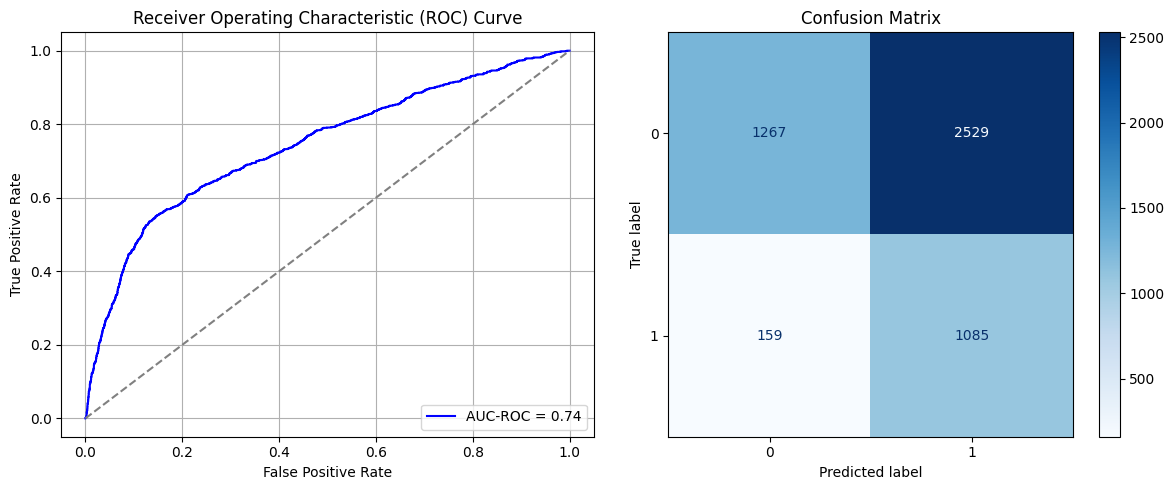

Best threshold based on F1-score: 0.9953934550285339
False Negative Rate: 0.12781350482315113
Time elapsed (performance): 0.7296962450000137
(np.float64(0.66622760800843), np.float64(0.33377239199157005))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6393 - loss: 0.6664 - val_AUC: 0.7026 - val_loss: 0.6193
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7180 - loss: 0.6041 - val_AUC: 0.7204 - val_loss: 0.6043
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7280 - loss: 0.5989 - val_AUC: 0.7286 - val_loss: 0.6004
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7335 - loss: 0.5924 - val_AUC: 0.7368 - val_loss: 0.5966
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7466 - loss: 0.5802 - val_AUC: 0.7421 - val_loss: 0.5924
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7471 - loss: 0.5828 - val_AUC: 0.7445 - val_loss: 0.5897
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7452 - loss: 0.5866 - val_AUC: 0.7473 - val_loss: 0.5904
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7537 - loss: 0.5748 - val_AUC: 0.7498 - val_loss: 0.5906
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7481 -

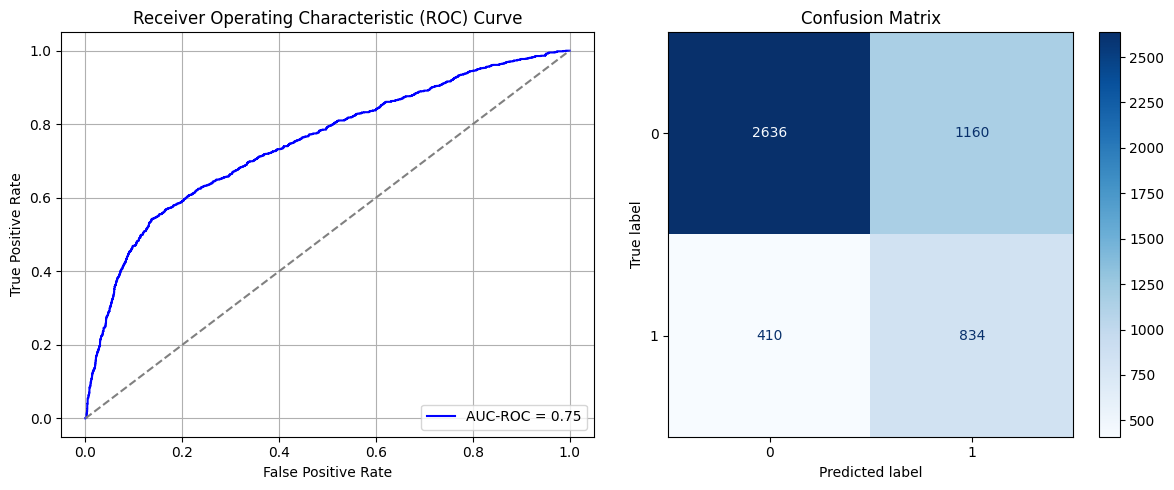

Best threshold based on F1-score: 0.9997377991676331
False Negative Rate: 0.3295819935691318
Time elapsed (performance): 0.7544481420000011
(np.float64(0.3055848261327713), np.float64(0.6944151738672286))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6510 - loss: 0.6646 - val_AUC: 0.7152 - val_loss: 0.6102
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7215 - loss: 0.6067 - val_AUC: 0.7362 - val_loss: 0.5952
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7331 - loss: 0.5963 - val_AUC: 0.7501 - val_loss: 0.5933
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7417 - loss: 0.5889 - val_AUC: 0.7545 - val_loss: 0.5832
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7388 - loss: 0.5922 - val_AUC: 0.7566 - val_loss: 0.5831
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7499 - loss: 0.5816 - val_AUC: 0.7546 - val_loss: 0.5854
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7609 - loss: 0.5733 - val_AUC: 0.7654 - val_loss: 0.5778
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7609 - loss: 0.5755 - val_AUC: 0.7652 - val_loss: 0.5762
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7525 -

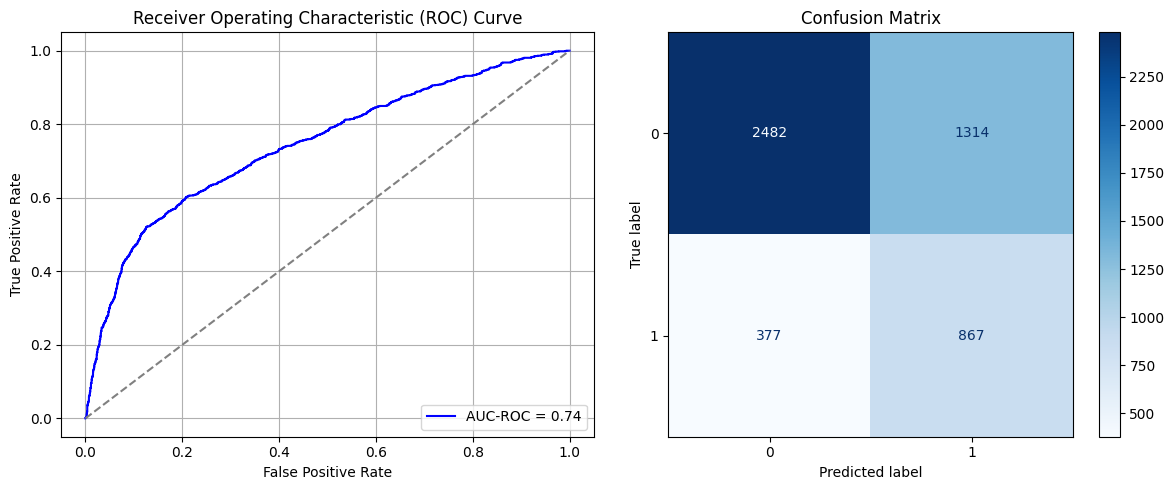

Best threshold based on F1-score: 0.9991893172264099
False Negative Rate: 0.30305466237942125
Time elapsed (performance): 0.7423123979999673
(np.float64(0.34615384615384615), np.float64(0.6538461538461539))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6493 - loss: 0.6660 - val_AUC: 0.6992 - val_loss: 0.6246
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7134 - loss: 0.6141 - val_AUC: 0.7288 - val_loss: 0.6022
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7135 - loss: 0.6091 - val_AUC: 0.7418 - val_loss: 0.5936
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7251 - loss: 0.6032 - val_AUC: 0.7423 - val_loss: 0.5940
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7414 - loss: 0.5946 - val_AUC: 0.7571 - val_loss: 0.5834
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7489 - loss: 0.5839 - val_AUC: 0.7556 - val_loss: 0.5790
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7395 - loss: 0.5904 - val_AUC: 0.7613 - val_loss: 0.5765
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7433 - loss: 0.5906 - val_AUC: 0.7625 - val_loss: 0.5723
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7467 -

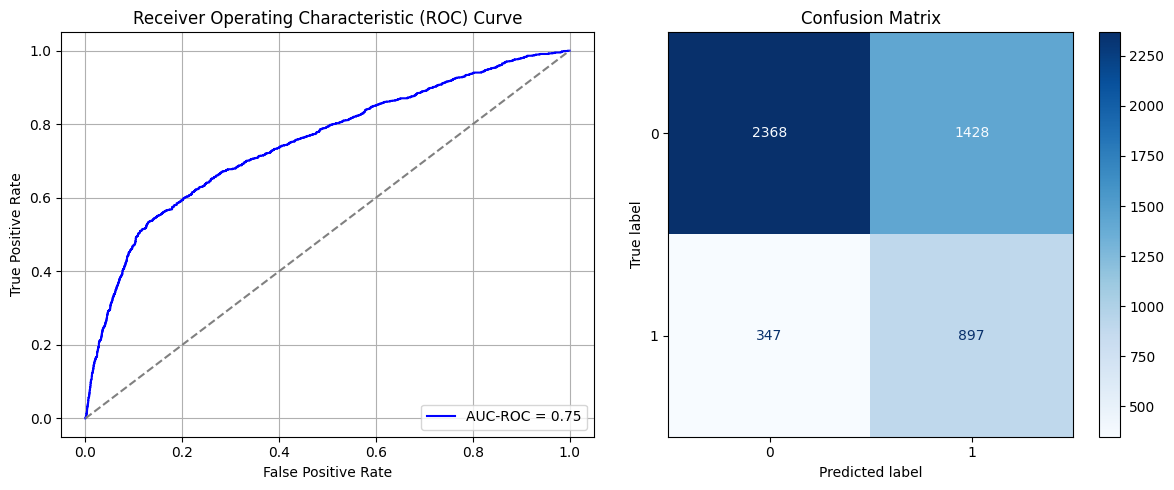

Best threshold based on F1-score: 0.9978954195976257
False Negative Rate: 0.27893890675241156
Time elapsed (performance): 0.7537922620001609
(np.float64(0.3761854583772392), np.float64(0.6238145416227607))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6181 - loss: 0.6685 - val_AUC: 0.7012 - val_loss: 0.6231
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7048 - loss: 0.6167 - val_AUC: 0.7155 - val_loss: 0.6058
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7219 - loss: 0.6032 - val_AUC: 0.7280 - val_loss: 0.6024
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7407 - loss: 0.5858 - val_AUC: 0.7373 - val_loss: 0.5970
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7433 - loss: 0.5852 - val_AUC: 0.7421 - val_loss: 0.6025
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7401 - loss: 0.5864 - val_AUC: 0.7447 - val_loss: 0.5923
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7481 - loss: 0.5809 - val_AUC: 0.7461 - val_loss: 0.5886
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7691 - loss: 0.5647 - val_AUC: 0.7484 - val_loss: 0.5892
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7652 -

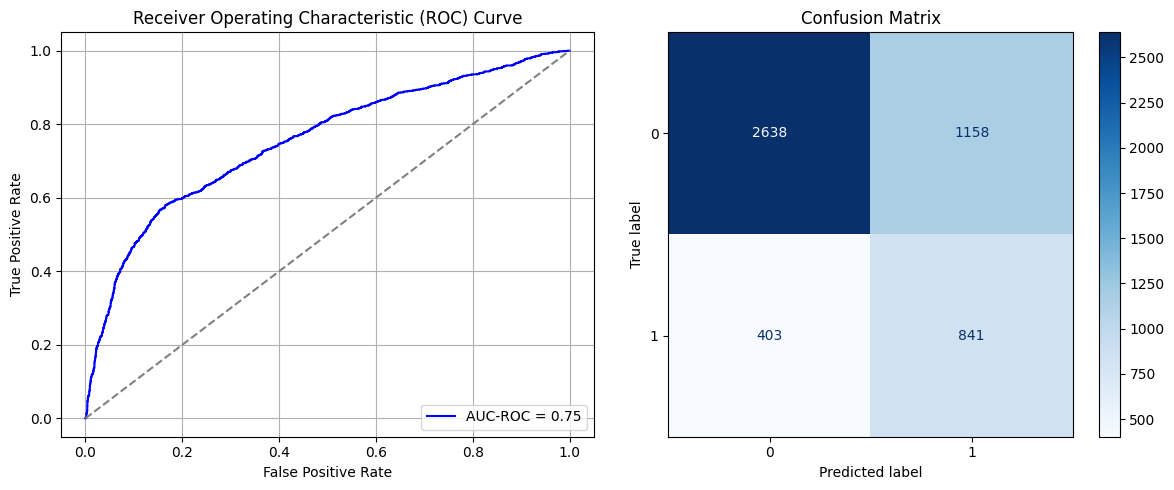

Best threshold based on F1-score: 0.9989049434661865
False Negative Rate: 0.32395498392282956
Time elapsed (performance): 0.7720025739999983
(np.float64(0.30505795574288724), np.float64(0.6949420442571128))
   Source time       FPR       TNR       FNR       TPR  Target time
0    13.218087  0.264489  0.735511  0.347267  0.652733     0.771552
1    12.804430  0.277661  0.722339  0.336013  0.663987     0.795944
2    14.238616  0.355111  0.644889  0.293408  0.706592     0.733300
3    14.896000  0.421760  0.578240  0.248392  0.751608     1.072362
4    14.584377  0.218915  0.781085  0.391479  0.608521     2.053121
5    13.508649  0.666228  0.333772  0.127814  0.872186     0.729696
6    11.383233  0.305585  0.694415  0.329582  0.670418     0.754448
7    15.148578  0.346154  0.653846  0.303055  0.696945     0.742312
8    15.322535  0.376185  0.623815  0.278939  0.721061     0.753792
9    15.863343  0.305058  0.694942  0.323955  0.676045     0.772003


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [35]:
import random

times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = oversample_size/undersample_size
print(k)

# np.random.seed(123)

for i in range(times):
    start = random.randint(1, int(k))
    # print(start)

    Row = []

    for j in range(undersample_size):
      row = start+int(k*j)-1
      Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :-1]
    y_S_Sy = data_S_Sy_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)


In [36]:
print(ParamFit)
ParamFit.to_csv('Sy_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    13.218087  0.264489  0.735511  0.347267  0.652733     0.771552
1    12.804430  0.277661  0.722339  0.336013  0.663987     0.795944
2    14.238616  0.355111  0.644889  0.293408  0.706592     0.733300
3    14.896000  0.421760  0.578240  0.248392  0.751608     1.072362
4    14.584377  0.218915  0.781085  0.391479  0.608521     2.053121
5    13.508649  0.666228  0.333772  0.127814  0.872186     0.729696
6    11.383233  0.305585  0.694415  0.329582  0.670418     0.754448
7    15.148578  0.346154  0.653846  0.303055  0.696945     0.742312
8    15.322535  0.376185  0.623815  0.278939  0.721061     0.753792
9    15.863343  0.305058  0.694942  0.323955  0.676045     0.772003


## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

35.87215803205367
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6259 - loss: 0.6745 - val_AUC: 0.7228 - val_loss: 0.6091
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7055 - loss: 0.6167 - val_AUC: 0.7341 - val_loss: 0.6002
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7274 - loss: 0.6000 - val_AUC: 0.7452 - val_loss: 0.5937
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7388 - loss: 0.5939 - val_AUC: 0.7491 - val_loss: 0.5882
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7414 - loss: 0.5922 - val_AUC: 0.7533 - val_loss: 0.5829
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7387 - loss: 0.5941 - val_AUC: 0.7553 - val_loss: 0.5825
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7547 - loss: 0.5785 - val_AUC: 0.7554 - val_loss: 0.5834
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7589 - loss: 0.5760 - val_AUC: 0.7534 - val_loss: 0.5841
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7449 -

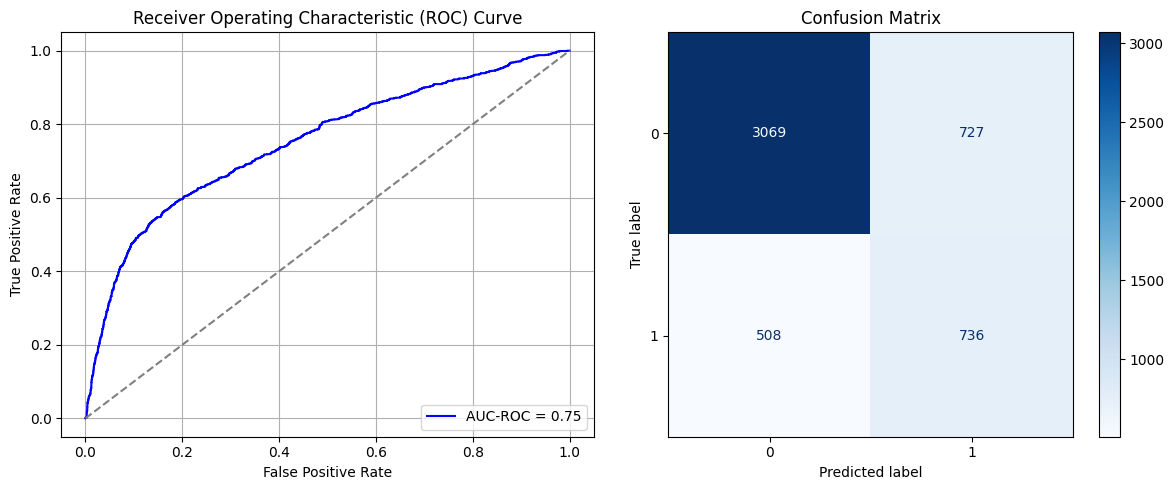

Best threshold based on F1-score: 0.9990628957748413
False Negative Rate: 0.40836012861736337
Time elapsed (performance): 1.2510148399999252
(np.float64(0.19151738672286617), np.float64(0.8084826132771339))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6653 - loss: 0.6603 - val_AUC: 0.7226 - val_loss: 0.6163
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7220 - loss: 0.6063 - val_AUC: 0.7412 - val_loss: 0.5921
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7361 - loss: 0.5986 - val_AUC: 0.7473 - val_loss: 0.5929
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7474 - loss: 0.5923 - val_AUC: 0.7514 - val_loss: 0.5829
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7572 - loss: 0.5809 - val_AUC: 0.7534 - val_loss: 0.5822
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7590 - loss: 0.5787 - val_AUC: 0.7504 - val_loss: 0.5854
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7597 - loss: 0.5782 - val_AUC: 0.7578 - val_loss: 0.5788
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7467 - loss: 0.5863 - val_AUC: 0.7560 - val_loss: 0.5790
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7505 -

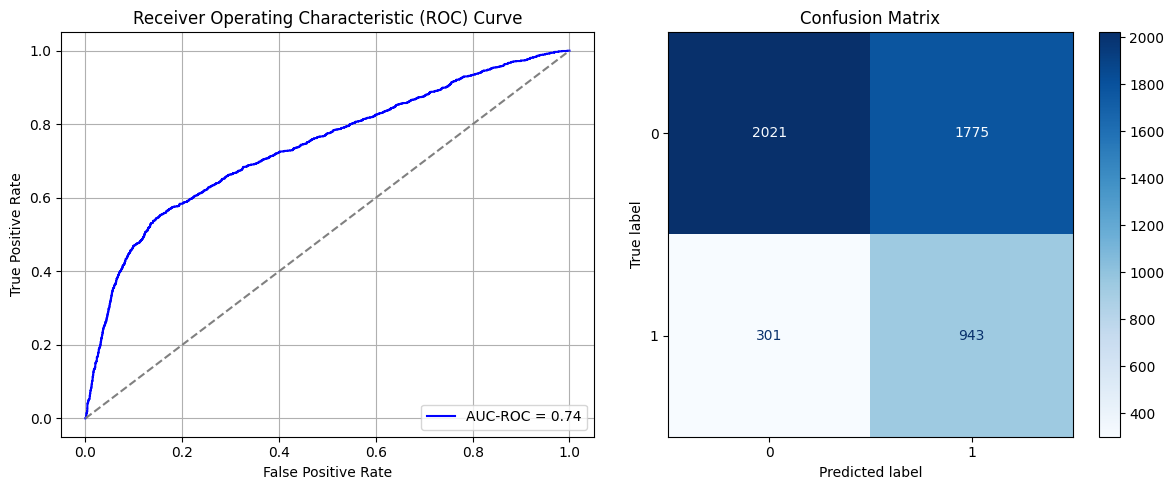

Best threshold based on F1-score: 0.9991990923881531
False Negative Rate: 0.24196141479099678
Time elapsed (performance): 0.7482325119999587
(np.float64(0.46759747102212856), np.float64(0.5324025289778714))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6425 - loss: 0.6618 - val_AUC: 0.7257 - val_loss: 0.6056
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7121 - loss: 0.6129 - val_AUC: 0.7366 - val_loss: 0.6010
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7281 - loss: 0.6027 - val_AUC: 0.7508 - val_loss: 0.5812
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7461 - loss: 0.5873 - val_AUC: 0.7541 - val_loss: 0.5789
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7393 - loss: 0.5913 - val_AUC: 0.7526 - val_loss: 0.5784
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7395 - loss: 0.5894 - val_AUC: 0.7570 - val_loss: 0.5751
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7505 - loss: 0.5856 - val_AUC: 0.7617 - val_loss: 0.5708
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7634 - loss: 0.5776 - val_AUC: 0.7658 - val_loss: 0.5714
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7633 -

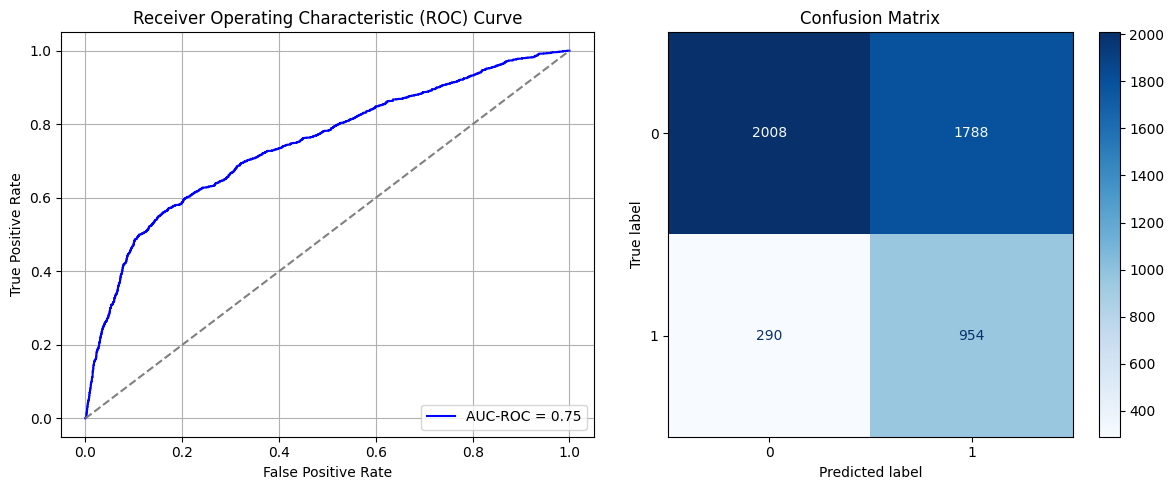

Best threshold based on F1-score: 0.9988278746604919
False Negative Rate: 0.23311897106109325
Time elapsed (performance): 0.7483280020001075
(np.float64(0.47102212855637515), np.float64(0.5289778714436248))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6369 - loss: 0.6645 - val_AUC: 0.7143 - val_loss: 0.6106
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7089 - loss: 0.6116 - val_AUC: 0.7289 - val_loss: 0.5987
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7267 - loss: 0.5967 - val_AUC: 0.7380 - val_loss: 0.5910
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7395 - loss: 0.5873 - val_AUC: 0.7447 - val_loss: 0.5866
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7489 - loss: 0.5828 - val_AUC: 0.7485 - val_loss: 0.5857
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7408 - loss: 0.5881 - val_AUC: 0.7543 - val_loss: 0.5816
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7504 - loss: 0.5800 - val_AUC: 0.7543 - val_loss: 0.5808
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7510 - loss: 0.5810 - val_AUC: 0.7602 - val_loss: 0.5773
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7430 -

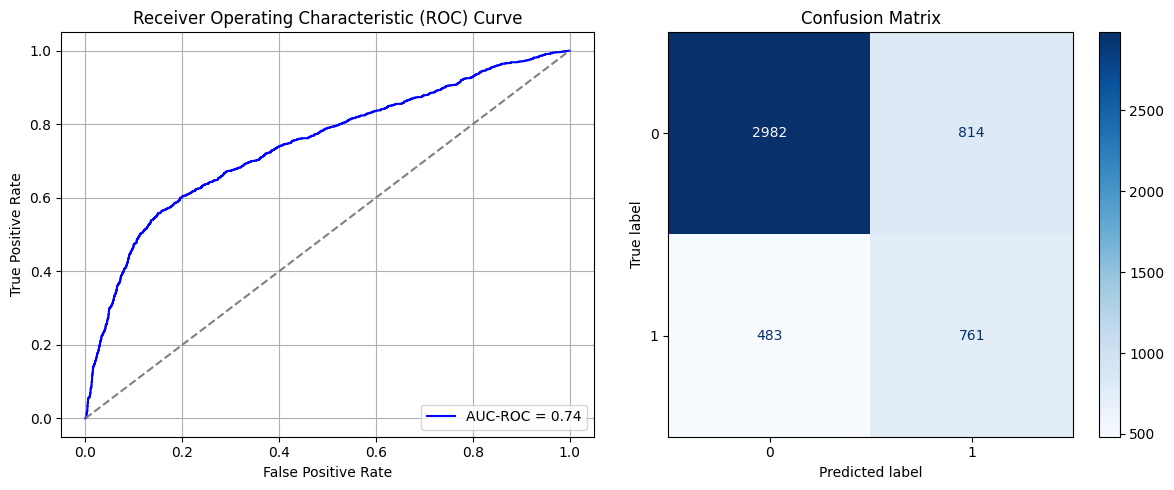

Best threshold based on F1-score: 0.9986605048179626
False Negative Rate: 0.3882636655948553
Time elapsed (performance): 0.7160606150000604
(np.float64(0.21443624868282402), np.float64(0.785563751317176))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6659 - loss: 0.6591 - val_AUC: 0.7255 - val_loss: 0.6039
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7203 - loss: 0.6102 - val_AUC: 0.7408 - val_loss: 0.5908
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7364 - loss: 0.5979 - val_AUC: 0.7498 - val_loss: 0.5862
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7519 - loss: 0.5869 - val_AUC: 0.7528 - val_loss: 0.5813
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7559 - loss: 0.5869 - val_AUC: 0.7570 - val_loss: 0.5799
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7558 - loss: 0.5803 - val_AUC: 0.7543 - val_loss: 0.5847
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7607 - loss: 0.5764 - val_AUC: 0.7590 - val_loss: 0.5793
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7559 - loss: 0.5782 - val_AUC: 0.7631 - val_loss: 0.5771
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7711 -

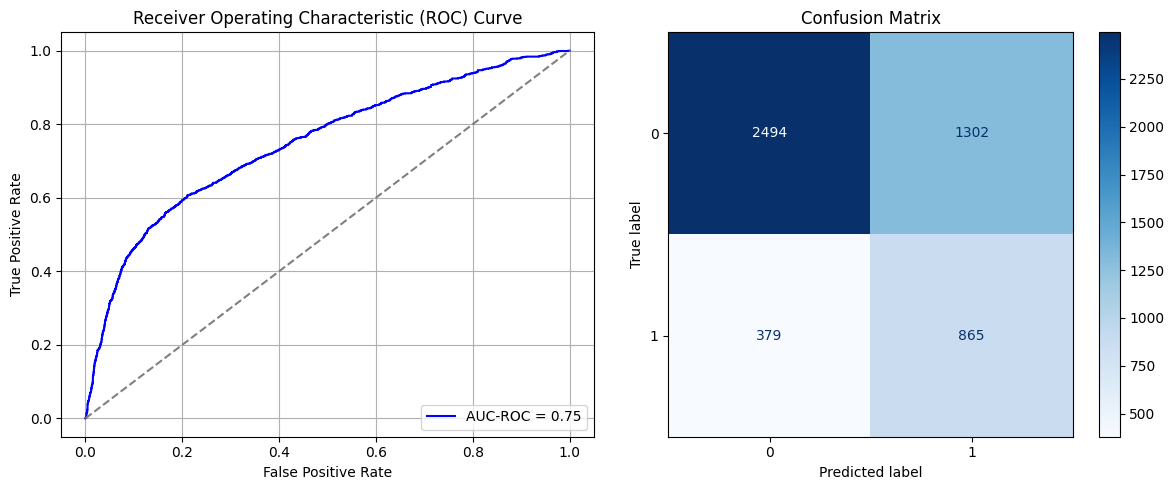

Best threshold based on F1-score: 0.9969552159309387
False Negative Rate: 0.3046623794212219
Time elapsed (performance): 0.7639594760000818
(np.float64(0.3429926238145416), np.float64(0.6570073761854585))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6448 - loss: 0.6637 - val_AUC: 0.7166 - val_loss: 0.6080
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7109 - loss: 0.6126 - val_AUC: 0.7319 - val_loss: 0.5921
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7232 - loss: 0.6001 - val_AUC: 0.7443 - val_loss: 0.5828
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7217 - loss: 0.6069 - val_AUC: 0.7515 - val_loss: 0.5785
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7324 - loss: 0.5934 - val_AUC: 0.7565 - val_loss: 0.5757
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7457 - loss: 0.5822 - val_AUC: 0.7590 - val_loss: 0.5711
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7352 - loss: 0.5894 - val_AUC: 0.7601 - val_loss: 0.5702
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7422 - loss: 0.5856 - val_AUC: 0.7623 - val_loss: 0.5688
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7333 -

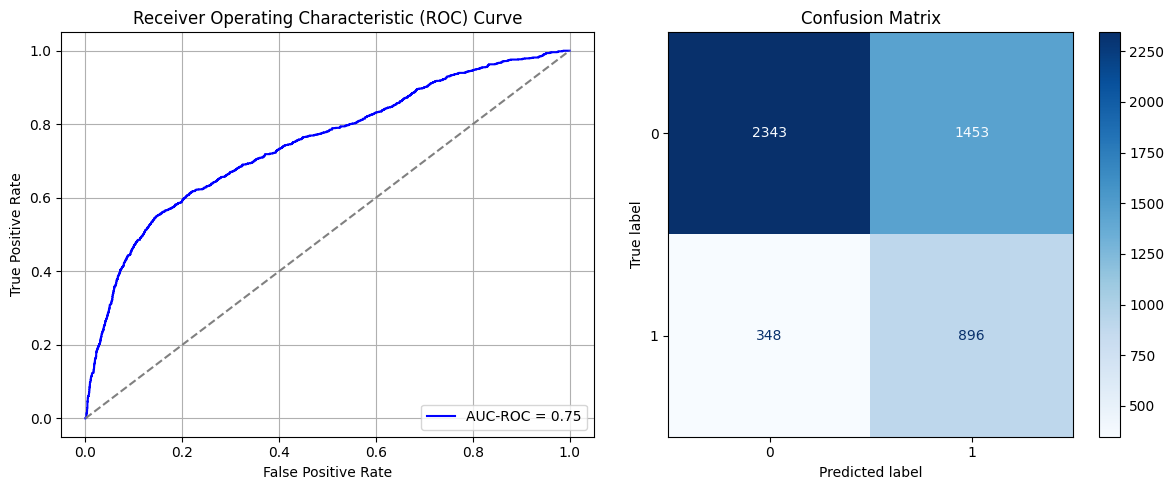

Best threshold based on F1-score: 0.9989431500434875
False Negative Rate: 0.2797427652733119
Time elapsed (performance): 1.299805306999815
(np.float64(0.3827713382507903), np.float64(0.6172286617492098))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5869 - loss: 0.6775 - val_AUC: 0.7111 - val_loss: 0.6177
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7068 - loss: 0.6168 - val_AUC: 0.7289 - val_loss: 0.5972
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7301 - loss: 0.5966 - val_AUC: 0.7405 - val_loss: 0.5906
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7400 - loss: 0.5891 - val_AUC: 0.7423 - val_loss: 0.5902
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7408 - loss: 0.5899 - val_AUC: 0.7441 - val_loss: 0.5967
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7356 - loss: 0.5948 - val_AUC: 0.7467 - val_loss: 0.5835
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7421 - loss: 0.5904 - val_AUC: 0.7476 - val_loss: 0.5894
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7557 - loss: 0.5787 - val_AUC: 0.7475 - val_loss: 0.5842
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7520 -

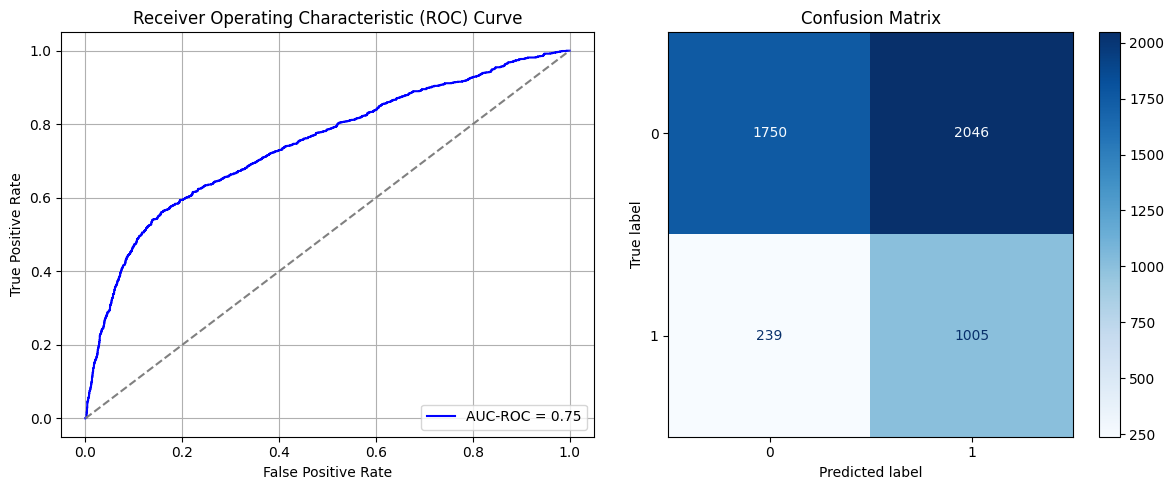

Best threshold based on F1-score: 0.9994697570800781
False Negative Rate: 0.19212218649517684
Time elapsed (performance): 0.8085129500000221
(np.float64(0.5389884088514225), np.float64(0.4610115911485775))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6259 - loss: 0.6652 - val_AUC: 0.7171 - val_loss: 0.6069
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7089 - loss: 0.6134 - val_AUC: 0.7338 - val_loss: 0.5932
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7338 - loss: 0.6006 - val_AUC: 0.7431 - val_loss: 0.5867
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7415 - loss: 0.5869 - val_AUC: 0.7515 - val_loss: 0.5816
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7543 - loss: 0.5850 - val_AUC: 0.7562 - val_loss: 0.5766
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7578 - loss: 0.5723 - val_AUC: 0.7614 - val_loss: 0.5740
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7543 - loss: 0.5794 - val_AUC: 0.7638 - val_loss: 0.5777
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7591 - loss: 0.5767 - val_AUC: 0.7640 - val_loss: 0.5711
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7505 -

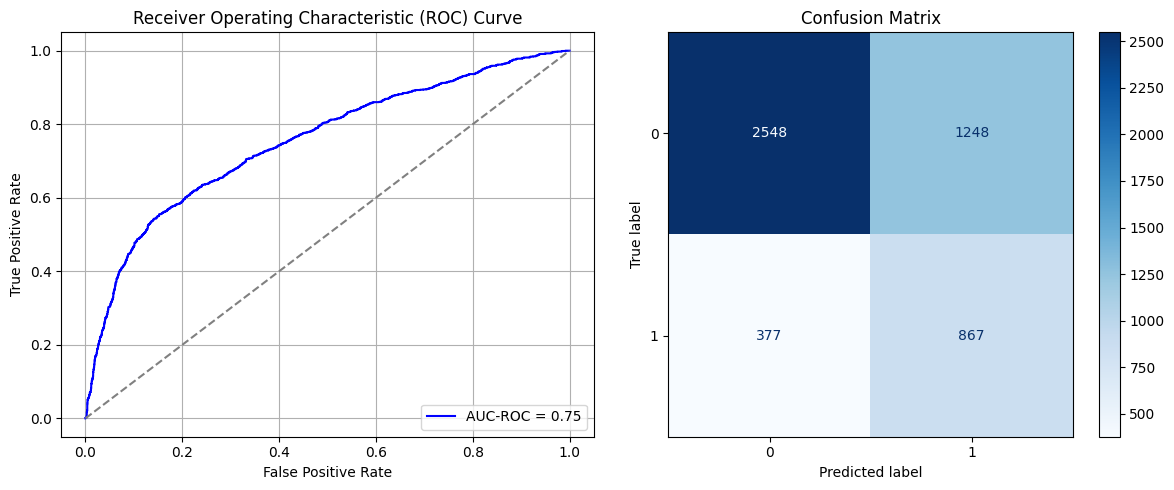

Best threshold based on F1-score: 0.9989147186279297
False Negative Rate: 0.30305466237942125
Time elapsed (performance): 0.7723958750000293
(np.float64(0.3287671232876712), np.float64(0.6712328767123288))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6310 - loss: 0.6693 - val_AUC: 0.7164 - val_loss: 0.6164
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7072 - loss: 0.6164 - val_AUC: 0.7322 - val_loss: 0.6009
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7293 - loss: 0.5994 - val_AUC: 0.7448 - val_loss: 0.5978
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7373 - loss: 0.5936 - val_AUC: 0.7527 - val_loss: 0.5876
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7480 - loss: 0.5884 - val_AUC: 0.7560 - val_loss: 0.5851
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7532 - loss: 0.5789 - val_AUC: 0.7596 - val_loss: 0.5810
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7514 - loss: 0.5762 - val_AUC: 0.7635 - val_loss: 0.5789
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7478 - loss: 0.5787 - val_AUC: 0.7622 - val_loss: 0.5846
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7523 -

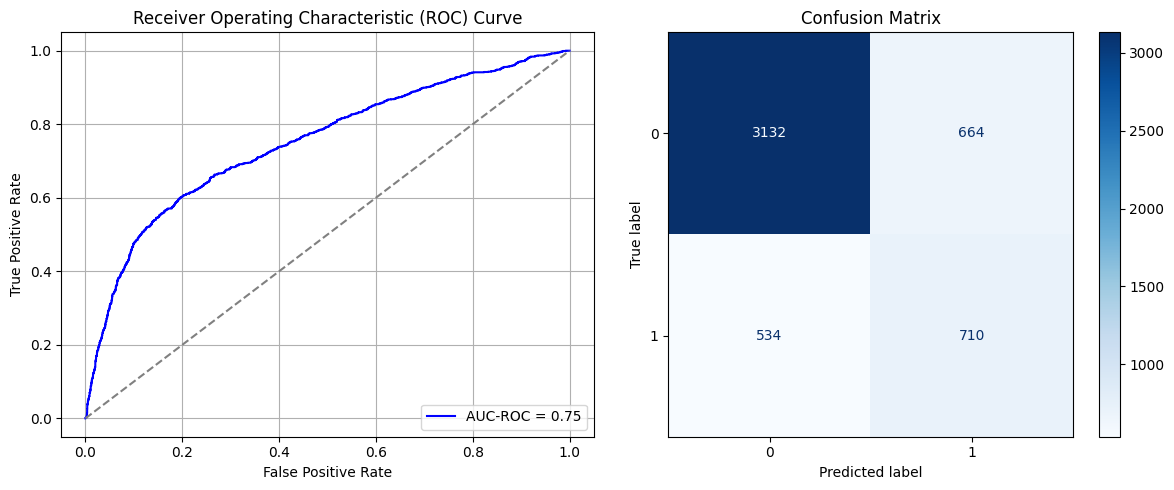

Best threshold based on F1-score: 0.9990110993385315
False Negative Rate: 0.4292604501607717
Time elapsed (performance): 1.1014476000000286
(np.float64(0.1749209694415174), np.float64(0.8250790305584826))
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6620 - loss: 0.6560 - val_AUC: 0.7171 - val_loss: 0.6130
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7175 - loss: 0.6078 - val_AUC: 0.7343 - val_loss: 0.5941
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7367 - loss: 0.5889 - val_AUC: 0.7439 - val_loss: 0.5957
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7467 - loss: 0.5824 - val_AUC: 0.7465 - val_loss: 0.5851
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7396 - loss: 0.5876 - val_AUC: 0.7516 - val_loss: 0.5819
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7499 - loss: 0.5786 - val_AUC: 0.7527 - val_loss: 0.5907
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7674 - loss: 0.5648 - val_AUC: 0.7496 - val_loss: 0.5808
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7470 - loss: 0.5796 - val_AUC: 0.7534 - val_loss: 0.5799
Epoch 9/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7633 -

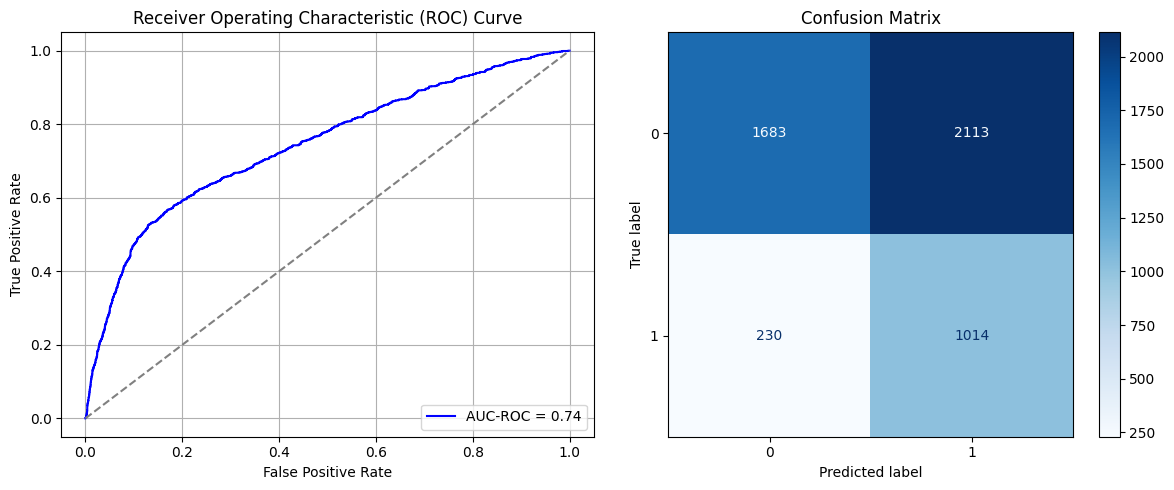

Best threshold based on F1-score: 0.9997738599777222
False Negative Rate: 0.18488745980707397
Time elapsed (performance): 1.279998274000036
(np.float64(0.5566385669125395), np.float64(0.44336143308746045))
   Source time       FPR       TNR       FNR       TPR  Target time
0    14.194840  0.191517  0.808483  0.408360  0.591640     1.251015
1    13.390486  0.467597  0.532403  0.241961  0.758039     0.748233
2    11.610997  0.471022  0.528978  0.233119  0.766881     0.748328
3    14.637294  0.214436  0.785564  0.388264  0.611736     0.716061
4    16.076445  0.342993  0.657007  0.304662  0.695338     0.763959
5    15.198523  0.382771  0.617229  0.279743  0.720257     1.299805
6    14.687610  0.538988  0.461012  0.192122  0.807878     0.808513
7    13.303847  0.328767  0.671233  0.303055  0.696945     0.772396
8    15.324313  0.174921  0.825079  0.429260  0.570740     1.101448
9    15.096722  0.556639  0.443361  0.184887  0.815113     1.279998


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [37]:
import random

times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

m = 10

k = oversample_size/undersample_size * m
print(k)

# np.random.seed(123)

for i in range(times):
    start = np.random.choice(int(k), 10)
    # print(start)

    Row = []

    Row = []

    for j in range(len(start)):
      for l in range(int(undersample_size/m)):
        row = start[j]+int(k*l)-1
        Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :-1]
    y_S_Sy = data_S_Sy_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)

In [38]:
print(ParamFit)
ParamFit.to_csv('Sy2_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    14.194840  0.191517  0.808483  0.408360  0.591640     1.251015
1    13.390486  0.467597  0.532403  0.241961  0.758039     0.748233
2    11.610997  0.471022  0.528978  0.233119  0.766881     0.748328
3    14.637294  0.214436  0.785564  0.388264  0.611736     0.716061
4    16.076445  0.342993  0.657007  0.304662  0.695338     0.763959
5    15.198523  0.382771  0.617229  0.279743  0.720257     1.299805
6    14.687610  0.538988  0.461012  0.192122  0.807878     0.808513
7    13.303847  0.328767  0.671233  0.303055  0.696945     0.772396
8    15.324313  0.174921  0.825079  0.429260  0.570740     1.101448
9    15.096722  0.556639  0.443361  0.184887  0.815113     1.279998


# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [39]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

5366
19249


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6821 - loss: 0.6380 - val_AUC: 0.7383 - val_loss: 0.5975
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7487 - loss: 0.5823 - val_AUC: 0.7490 - val_loss: 0.5832
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7563 - loss: 0.5791 - val_AUC: 0.7581 - val_loss: 0.5782
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7620 - loss: 0.5749 - val_AUC: 0.7667 - val_loss: 0.5722
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7716 - loss: 0.5668 - val_AUC: 0.7709 - val_loss: 0.5689
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7765 - loss: 0.5639 - val_AUC: 0.7727 - val_loss: 0.5665
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7822 - loss: 0.5589 - val_AUC: 0.7784 - val_loss: 0.5630
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7766 - loss: 0.5632 - val_AUC: 0.7757 - val_loss: 0.5660
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7810 -

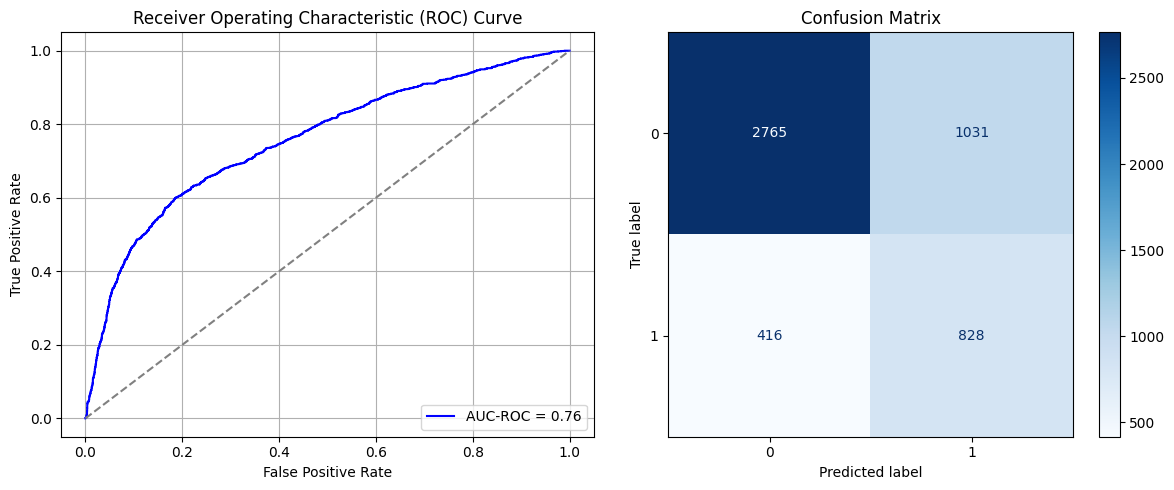

Best threshold based on F1-score: 0.9954740405082703
False Negative Rate: 0.33440514469453375
Time elapsed (performance): 1.2354684639999505
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6847 - loss: 0.6359 - val_AUC: 0.7411 - val_loss: 0.5915
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7497 - loss: 0.5814 - val_AUC: 0.7493 - val_loss: 0.5821
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7584 - loss: 0.5755 - val_AUC: 0.7575 - val_loss: 0.5781
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7646 - loss: 0.5723 - val_AUC: 0.7674 - val_loss: 0.5703
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7727 - loss: 0.5653 - val_AUC: 0.7702 - val_loss: 0.5686
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7778 - loss: 0.5582 - val_AUC: 0.7730 - val_loss: 0.5655
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7803 - loss: 0.5580 - val_AUC: 0.7785 - val_loss: 0.5670
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7814 - loss: 0.5563 - val_AUC: 0.7790 - val_loss: 0.5604
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7816 -

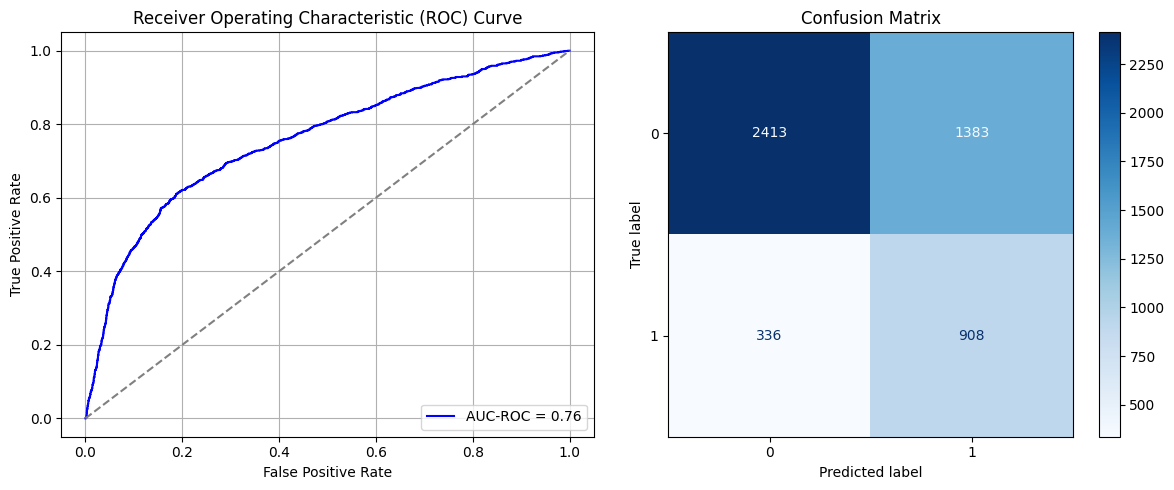

Best threshold based on F1-score: 0.6083518862724304
False Negative Rate: 0.27009646302250806
Time elapsed (performance): 0.6907632180000292
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6889 - loss: 0.6327 - val_AUC: 0.7387 - val_loss: 0.5901
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7474 - loss: 0.5839 - val_AUC: 0.7488 - val_loss: 0.5853
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7568 - loss: 0.5745 - val_AUC: 0.7558 - val_loss: 0.5797
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7608 - loss: 0.5756 - val_AUC: 0.7631 - val_loss: 0.5717
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7690 - loss: 0.5674 - val_AUC: 0.7642 - val_loss: 0.5714
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7725 - loss: 0.5638 - val_AUC: 0.7701 - val_loss: 0.5688
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7711 - loss: 0.5649 - val_AUC: 0.7731 - val_loss: 0.5649
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7772 - loss: 0.5606 - val_AUC: 0.7724 - val_loss: 0.5668
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7827 -

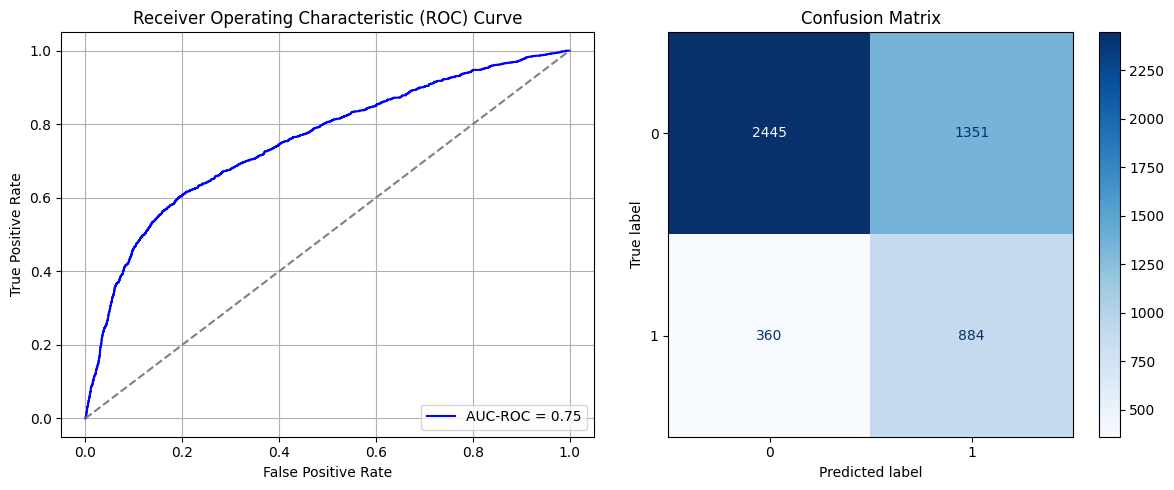

Best threshold based on F1-score: 0.6370738744735718
False Negative Rate: 0.28938906752411575
Time elapsed (performance): 0.694969637999975
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6654 - loss: 0.6432 - val_AUC: 0.7425 - val_loss: 0.5930
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7493 - loss: 0.5839 - val_AUC: 0.7532 - val_loss: 0.5808
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7576 - loss: 0.5770 - val_AUC: 0.7676 - val_loss: 0.5741
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7563 - loss: 0.5771 - val_AUC: 0.7741 - val_loss: 0.5673
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7730 - loss: 0.5644 - val_AUC: 0.7769 - val_loss: 0.5647
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7662 - loss: 0.5708 - val_AUC: 0.7810 - val_loss: 0.5620
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7820 - loss: 0.5578 - val_AUC: 0.7825 - val_loss: 0.5611
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7790 - loss: 0.5601 - val_AUC: 0.7841 - val_loss: 0.5589
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7821 -

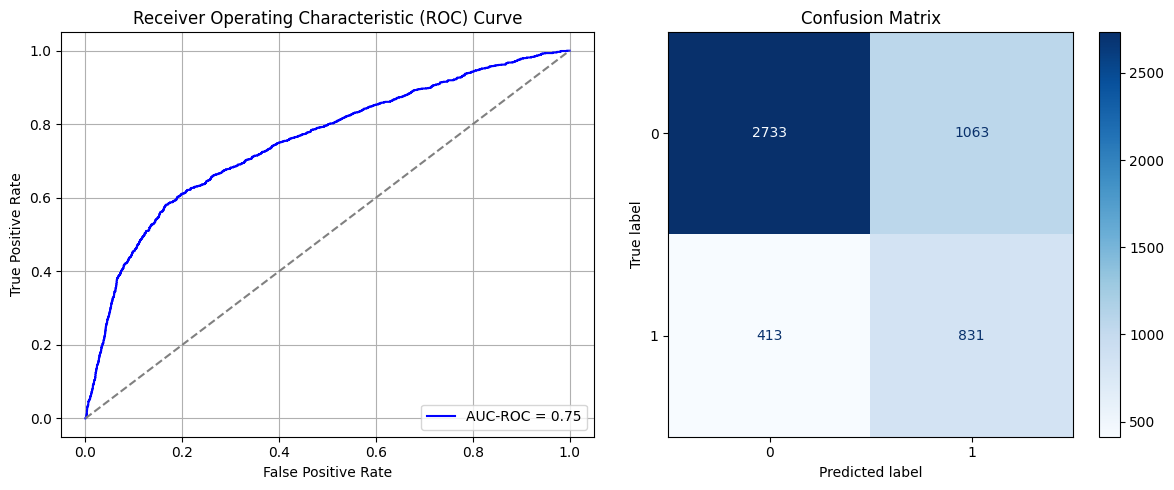

Best threshold based on F1-score: 0.9849992394447327
False Negative Rate: 0.3319935691318328
Time elapsed (performance): 0.7196786230001635
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6936 - loss: 0.6312 - val_AUC: 0.7455 - val_loss: 0.5909
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7422 - loss: 0.5916 - val_AUC: 0.7540 - val_loss: 0.5844
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7523 - loss: 0.5821 - val_AUC: 0.7606 - val_loss: 0.5788
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7623 - loss: 0.5747 - val_AUC: 0.7677 - val_loss: 0.5736
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7635 - loss: 0.5748 - val_AUC: 0.7720 - val_loss: 0.5726
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7701 - loss: 0.5649 - val_AUC: 0.7762 - val_loss: 0.5679
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7758 - loss: 0.5621 - val_AUC: 0.7817 - val_loss: 0.5628
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7798 - loss: 0.5569 - val_AUC: 0.7819 - val_loss: 0.5649
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7766 -

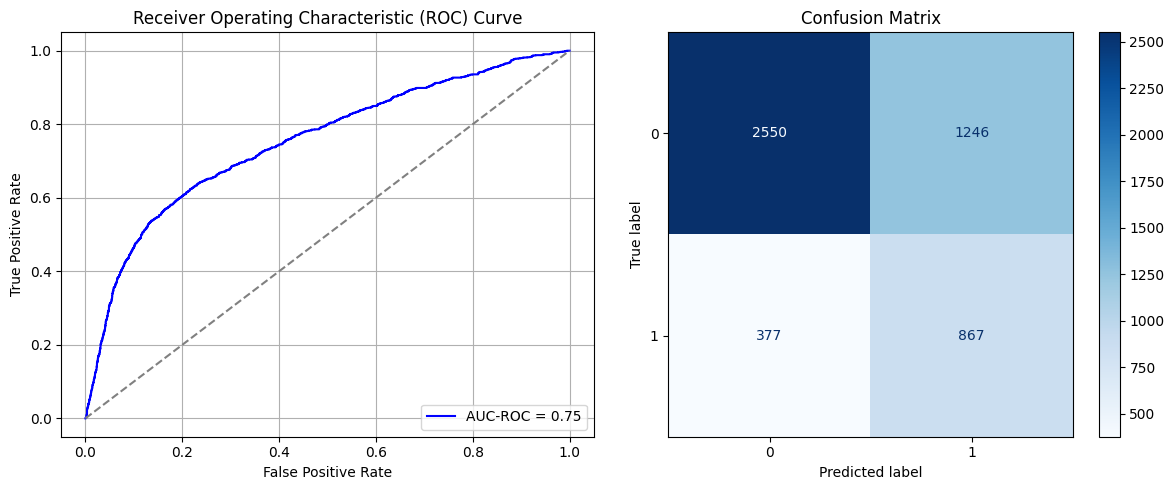

Best threshold based on F1-score: 0.9855257272720337
False Negative Rate: 0.30305466237942125
Time elapsed (performance): 1.9869270359999973
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6865 - loss: 0.6352 - val_AUC: 0.7486 - val_loss: 0.5889
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7475 - loss: 0.5868 - val_AUC: 0.7563 - val_loss: 0.5840
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7530 - loss: 0.5829 - val_AUC: 0.7645 - val_loss: 0.5780
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7572 - loss: 0.5769 - val_AUC: 0.7708 - val_loss: 0.5707
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7675 - loss: 0.5692 - val_AUC: 0.7741 - val_loss: 0.5728
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7702 - loss: 0.5679 - val_AUC: 0.7777 - val_loss: 0.5701
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7706 - loss: 0.5692 - val_AUC: 0.7796 - val_loss: 0.5691
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7711 - loss: 0.5680 - val_AUC: 0.7803 - val_loss: 0.5623
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7748 -

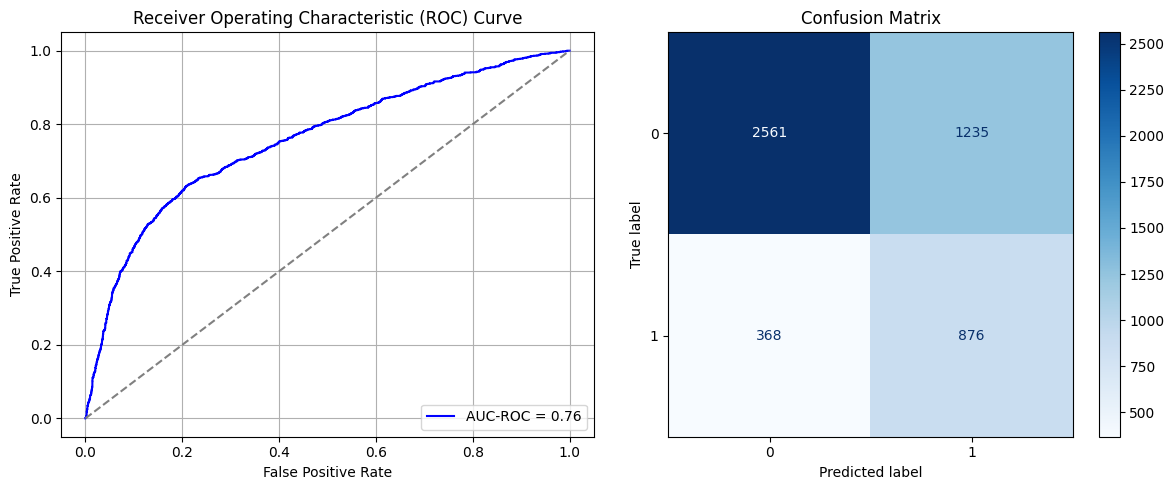

Best threshold based on F1-score: 0.9932451844215393
False Negative Rate: 0.2958199356913183
Time elapsed (performance): 0.8815521230001195
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6912 - loss: 0.6341 - val_AUC: 0.7403 - val_loss: 0.5947
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7328 - loss: 0.5955 - val_AUC: 0.7506 - val_loss: 0.5851
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7476 - loss: 0.5882 - val_AUC: 0.7624 - val_loss: 0.5759
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7634 - loss: 0.5731 - val_AUC: 0.7669 - val_loss: 0.5746
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7636 - loss: 0.5756 - val_AUC: 0.7735 - val_loss: 0.5699
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7740 - loss: 0.5657 - val_AUC: 0.7786 - val_loss: 0.5640
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7748 - loss: 0.5640 - val_AUC: 0.7816 - val_loss: 0.5614
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7759 - loss: 0.5638 - val_AUC: 0.7822 - val_loss: 0.5670
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7781 -

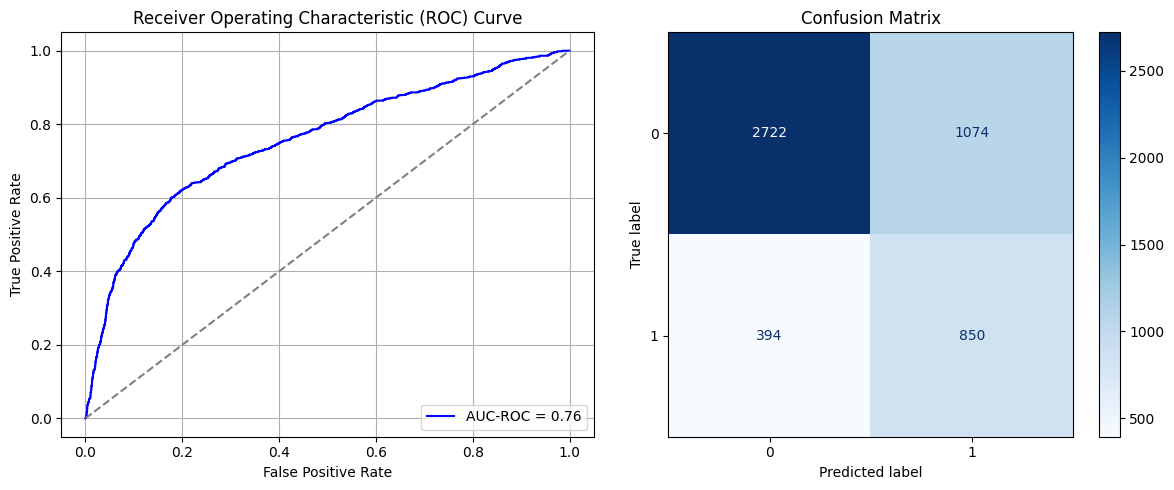

Best threshold based on F1-score: 0.995694100856781
False Negative Rate: 0.3167202572347267
Time elapsed (performance): 1.0808333790000688
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6951 - loss: 0.6299 - val_AUC: 0.7423 - val_loss: 0.5924
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7509 - loss: 0.5821 - val_AUC: 0.7561 - val_loss: 0.5795
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7539 - loss: 0.5795 - val_AUC: 0.7643 - val_loss: 0.5737
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7665 - loss: 0.5718 - val_AUC: 0.7690 - val_loss: 0.5697
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7718 - loss: 0.5646 - val_AUC: 0.7754 - val_loss: 0.5667
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7749 - loss: 0.5638 - val_AUC: 0.7784 - val_loss: 0.5641
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7827 - loss: 0.5565 - val_AUC: 0.7795 - val_loss: 0.5609
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7826 - loss: 0.5579 - val_AUC: 0.7837 - val_loss: 0.5578
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7837 -

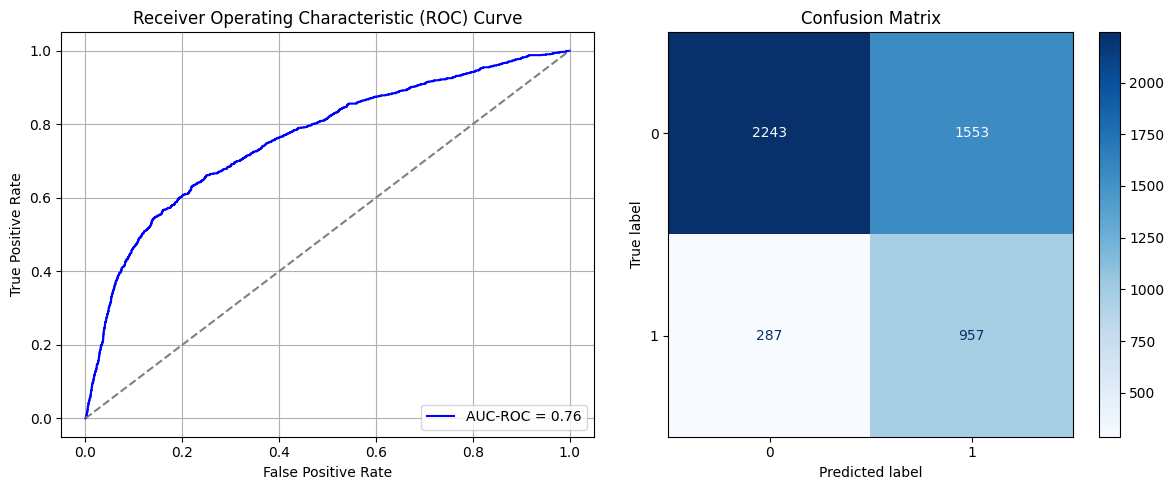

Best threshold based on F1-score: 0.9877768754959106
False Negative Rate: 0.23070739549839228
Time elapsed (performance): 0.7550121189999572
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6737 - loss: 0.6408 - val_AUC: 0.7428 - val_loss: 0.5896
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7410 - loss: 0.5882 - val_AUC: 0.7547 - val_loss: 0.5833
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7550 - loss: 0.5804 - val_AUC: 0.7649 - val_loss: 0.5759
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7586 - loss: 0.5766 - val_AUC: 0.7711 - val_loss: 0.5690
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7639 - loss: 0.5730 - val_AUC: 0.7740 - val_loss: 0.5667
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7734 - loss: 0.5656 - val_AUC: 0.7795 - val_loss: 0.5654
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7766 - loss: 0.5633 - val_AUC: 0.7777 - val_loss: 0.5628
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7798 - loss: 0.5583 - val_AUC: 0.7832 - val_loss: 0.5622
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7798 -

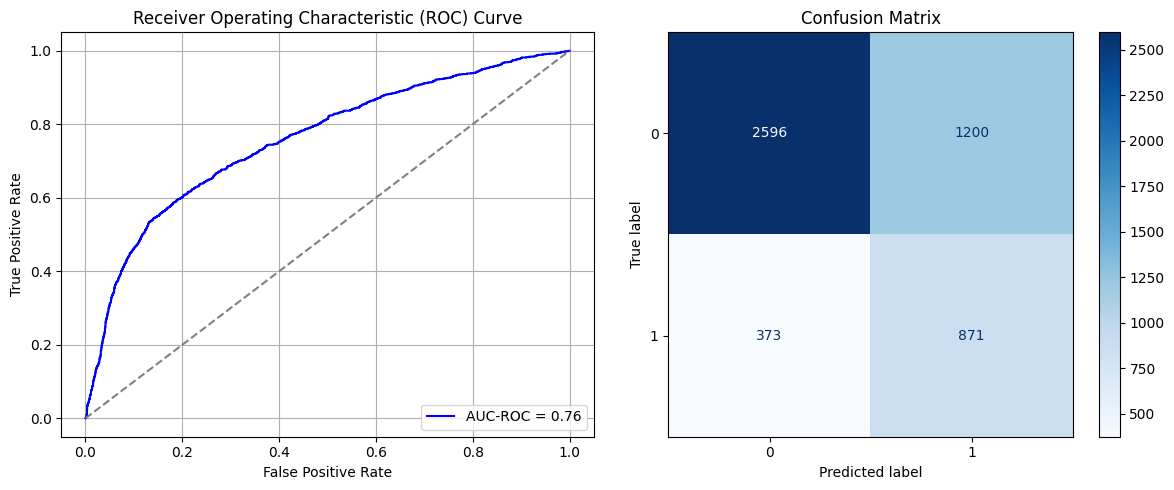

Best threshold based on F1-score: 0.6409619450569153
False Negative Rate: 0.29983922829581994
Time elapsed (performance): 0.7281726129999697
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


770/770 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6946 - loss: 0.6326 - val_AUC: 0.7419 - val_loss: 0.5896
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7463 - loss: 0.5850 - val_AUC: 0.7527 - val_loss: 0.5846
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7623 - loss: 0.5729 - val_AUC: 0.7655 - val_loss: 0.5756
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7644 - loss: 0.5724 - val_AUC: 0.7695 - val_loss: 0.5721
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7694 - loss: 0.5692 - val_AUC: 0.7745 - val_loss: 0.5726
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7792 - loss: 0.5602 - val_AUC: 0.7761 - val_loss: 0.5678
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7765 - loss: 0.5639 - val_AUC: 0.7769 - val_loss: 0.5626
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7817 - loss: 0.5563 - val_AUC: 0.7771 - val_loss: 0.5637
Epoch 9/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7792 -

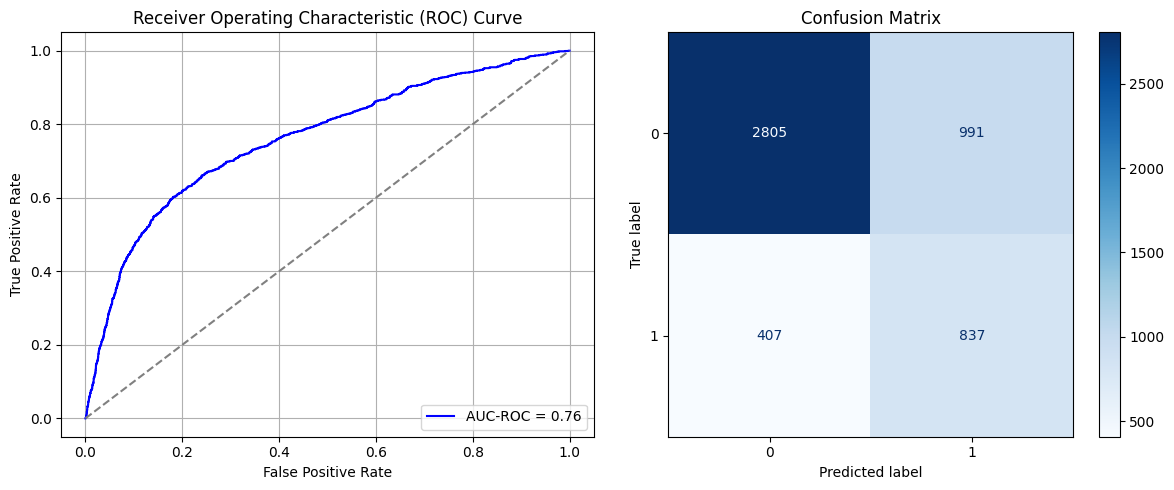

Best threshold based on F1-score: 0.9825630187988281
False Negative Rate: 0.3271704180064309
Time elapsed (performance): 1.2286750050000137


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [40]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_S_SRS_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_SRS_ROS = data_S_SRS_ROS.iloc[:, :-1]
    y_S_SRS_ROS = data_S_SRS_ROS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS_ROS, y_S_SRS_ROS, test_size=0.20, random_state=0)
    model_SRS_ROS = create_dnn_model(X_S_train.shape[1])
    result_SRS_ROS = train_and_evaluate(model_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS_ROS = Transductive_TL(model_SRS_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS_ROS)
    FPR.append(result_TL_SRS_ROS[0])
    TNR.append(result_TL_SRS_ROS[1])
    FNR.append(result_TL_SRS_ROS[2])
    TPR.append(result_TL_SRS_ROS[3])
    TL_time.append(result_TL_SRS_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [41]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS2.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    29.604868  0.271602  0.728398  0.334405  0.665595     1.235468
1    40.422499  0.364331  0.635669  0.270096  0.729904     0.690763
2    30.758375  0.355901  0.644099  0.289389  0.710611     0.694970
3    31.746346  0.280032  0.719968  0.331994  0.668006     0.719679
4    38.860173  0.328240  0.671760  0.303055  0.696945     1.986927
5    40.210622  0.325342  0.674658  0.295820  0.704180     0.881552
6    37.808853  0.282929  0.717071  0.316720  0.683280     1.080833
7    42.359467  0.409115  0.590885  0.230707  0.769293     0.755012
8    39.352592  0.316122  0.683878  0.299839  0.700161     0.728173
9    41.657770  0.261064  0.738936  0.327170  0.672830     1.228675


## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, we take $k=10$.

In [42]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

5366
19249


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6798 - loss: 0.6398 - val_AUC: 0.7533 - val_loss: 0.5829
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7400 - loss: 0.5893 - val_AUC: 0.7558 - val_loss: 0.5829
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7509 - loss: 0.5814 - val_AUC: 0.7665 - val_loss: 0.5693
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7591 - loss: 0.5756 - val_AUC: 0.7734 - val_loss: 0.5663
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7697 - loss: 0.5674 - val_AUC: 0.7740 - val_loss: 0.5669
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7716 - loss: 0.5671 - val_AUC: 0.7820 - val_loss: 0.5593
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7776 - loss: 0.5628 - val_AUC: 0.7806 - val_loss: 0.5598
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7724 - loss: 0.5673 - val_AUC: 0.7821 - val_loss: 0.5575
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7751 -

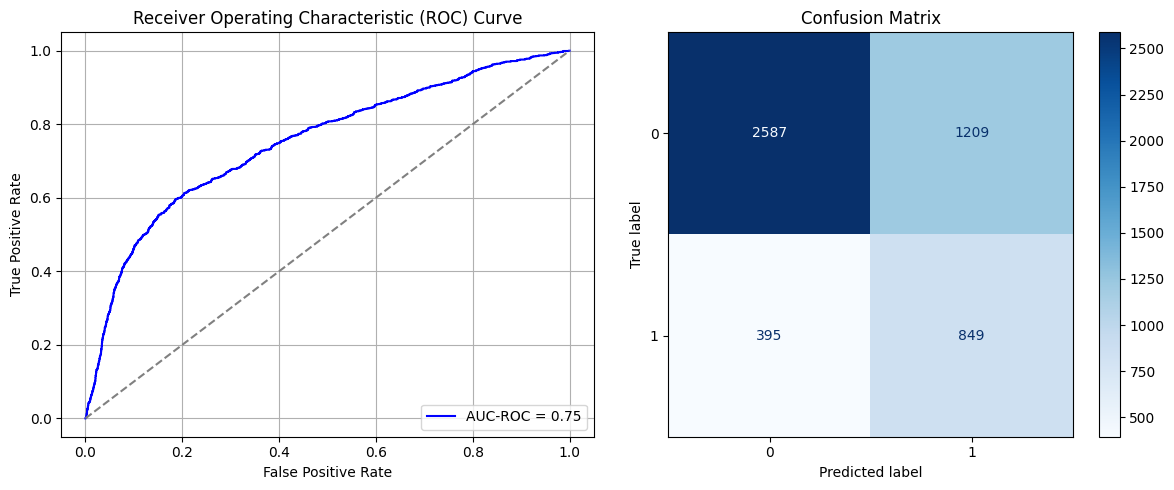

Best threshold based on F1-score: 0.9848379492759705
False Negative Rate: 0.317524115755627
Time elapsed (performance): 0.7303262870000253
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6715 - loss: 0.6390 - val_AUC: 0.7479 - val_loss: 0.5887
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7324 - loss: 0.5939 - val_AUC: 0.7553 - val_loss: 0.5796
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7535 - loss: 0.5796 - val_AUC: 0.7618 - val_loss: 0.5737
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7562 - loss: 0.5797 - val_AUC: 0.7657 - val_loss: 0.5694
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7650 - loss: 0.5708 - val_AUC: 0.7721 - val_loss: 0.5688
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7579 - loss: 0.5782 - val_AUC: 0.7738 - val_loss: 0.5660
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7725 - loss: 0.5651 - val_AUC: 0.7751 - val_loss: 0.5665
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7698 - loss: 0.5663 - val_AUC: 0.7688 - val_loss: 0.5685
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7734 -

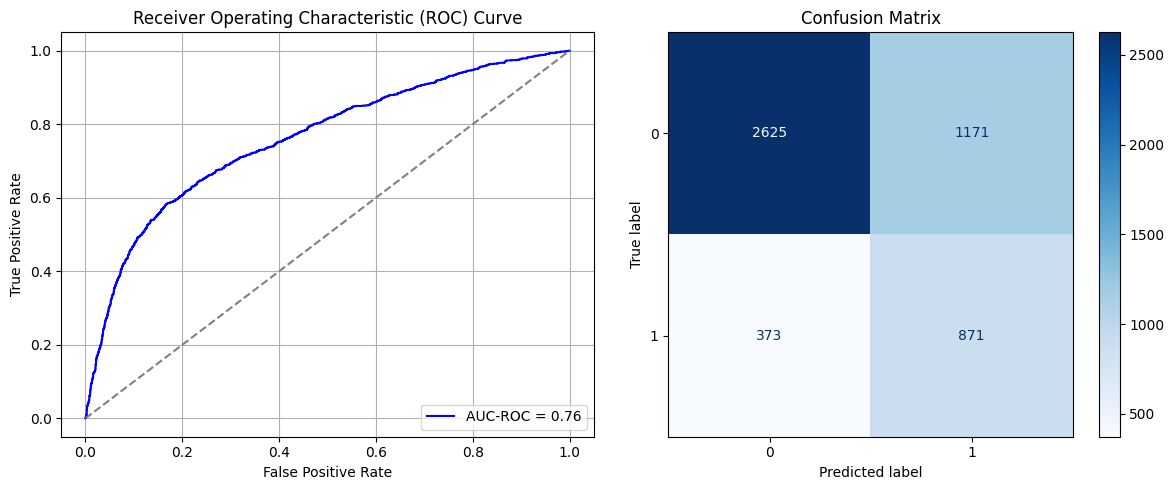

Best threshold based on F1-score: 0.9778860211372375
False Negative Rate: 0.29983922829581994
Time elapsed (performance): 0.7257098530003532
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6954 - loss: 0.6325 - val_AUC: 0.7444 - val_loss: 0.5897
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7468 - loss: 0.5861 - val_AUC: 0.7542 - val_loss: 0.5814
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7512 - loss: 0.5836 - val_AUC: 0.7574 - val_loss: 0.5805
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7621 - loss: 0.5757 - val_AUC: 0.7695 - val_loss: 0.5722
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7655 - loss: 0.5725 - val_AUC: 0.7708 - val_loss: 0.5709
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7688 - loss: 0.5696 - val_AUC: 0.7726 - val_loss: 0.5668
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7732 - loss: 0.5662 - val_AUC: 0.7677 - val_loss: 0.5742
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7789 - loss: 0.5602 - val_AUC: 0.7739 - val_loss: 0.5658
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7806 -

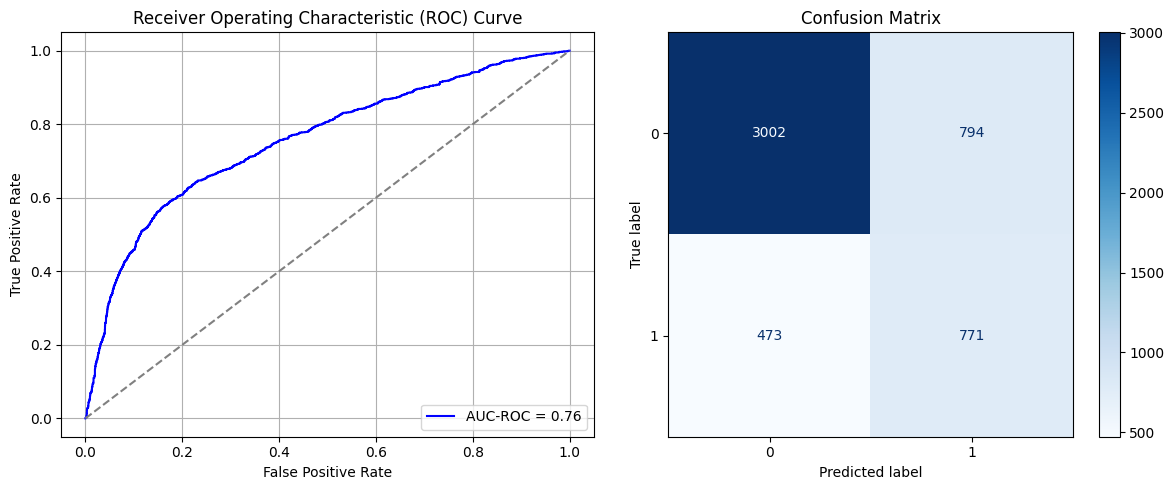

Best threshold based on F1-score: 0.9909375905990601
False Negative Rate: 0.38022508038585207
Time elapsed (performance): 0.7161295169998994
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6793 - loss: 0.6398 - val_AUC: 0.7512 - val_loss: 0.5856
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7391 - loss: 0.5906 - val_AUC: 0.7521 - val_loss: 0.5808
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7531 - loss: 0.5791 - val_AUC: 0.7634 - val_loss: 0.5782
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7589 - loss: 0.5773 - val_AUC: 0.7648 - val_loss: 0.5719
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7751 - loss: 0.5654 - val_AUC: 0.7727 - val_loss: 0.5693
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7745 - loss: 0.5616 - val_AUC: 0.7780 - val_loss: 0.5630
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7769 - loss: 0.5608 - val_AUC: 0.7818 - val_loss: 0.5606
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7819 - loss: 0.5570 - val_AUC: 0.7765 - val_loss: 0.5629
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7787 -

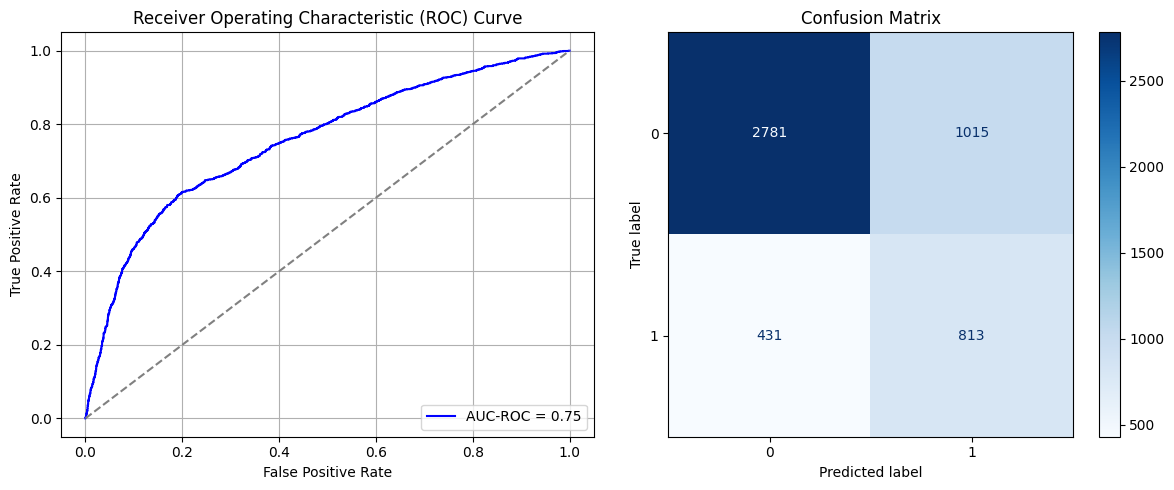

Best threshold based on F1-score: 0.9783198833465576
False Negative Rate: 0.34646302250803857
Time elapsed (performance): 0.7166605649999838
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6820 - loss: 0.6382 - val_AUC: 0.7512 - val_loss: 0.5824
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7399 - loss: 0.5909 - val_AUC: 0.7599 - val_loss: 0.5753
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7469 - loss: 0.5855 - val_AUC: 0.7670 - val_loss: 0.5700
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7547 - loss: 0.5778 - val_AUC: 0.7734 - val_loss: 0.5642
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7640 - loss: 0.5713 - val_AUC: 0.7788 - val_loss: 0.5620
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7721 - loss: 0.5680 - val_AUC: 0.7794 - val_loss: 0.5601
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7744 - loss: 0.5651 - val_AUC: 0.7845 - val_loss: 0.5572
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7771 - loss: 0.5626 - val_AUC: 0.7869 - val_loss: 0.5541
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7807 -

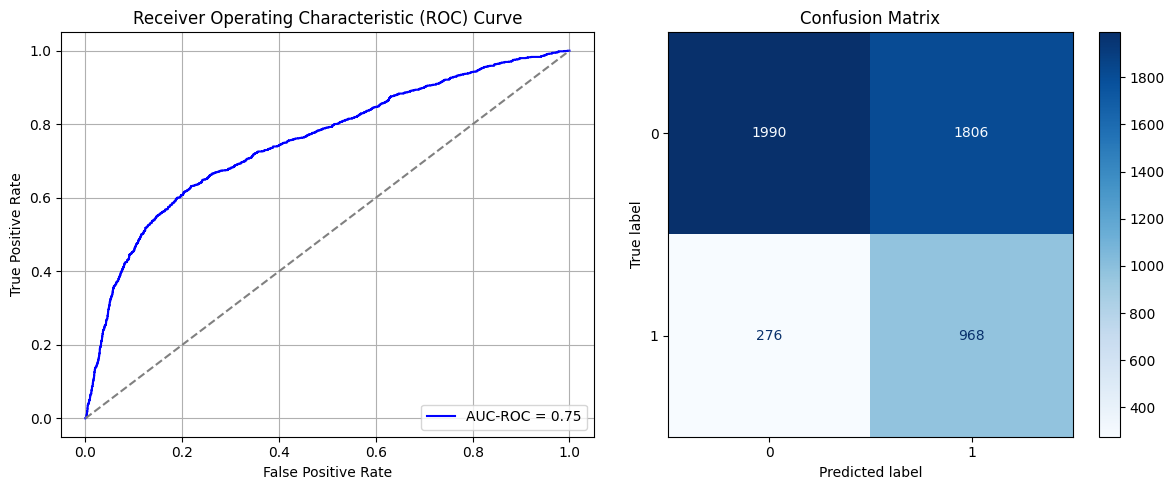

Best threshold based on F1-score: 0.9924089908599854
False Negative Rate: 0.22186495176848875
Time elapsed (performance): 0.7163266749998911
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6824 - loss: 0.6383 - val_AUC: 0.7520 - val_loss: 0.5850
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7383 - loss: 0.5924 - val_AUC: 0.7572 - val_loss: 0.5753
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7515 - loss: 0.5827 - val_AUC: 0.7645 - val_loss: 0.5725
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7652 - loss: 0.5711 - val_AUC: 0.7703 - val_loss: 0.5683
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7632 - loss: 0.5738 - val_AUC: 0.7763 - val_loss: 0.5642
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7691 - loss: 0.5679 - val_AUC: 0.7772 - val_loss: 0.5664
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7797 - loss: 0.5597 - val_AUC: 0.7773 - val_loss: 0.5633
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7737 - loss: 0.5668 - val_AUC: 0.7815 - val_loss: 0.5595
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7769 -

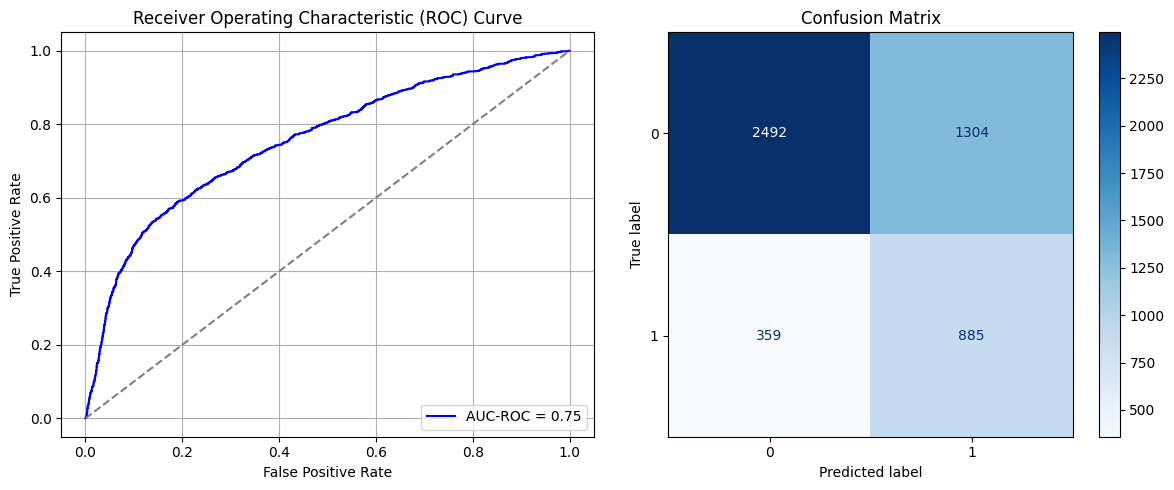

Best threshold based on F1-score: 0.9877593517303467
False Negative Rate: 0.28858520900321544
Time elapsed (performance): 2.7271374220003963
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6933 - loss: 0.6317 - val_AUC: 0.7567 - val_loss: 0.5821
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7531 - loss: 0.5833 - val_AUC: 0.7629 - val_loss: 0.5762
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7612 - loss: 0.5769 - val_AUC: 0.7737 - val_loss: 0.5657
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7723 - loss: 0.5680 - val_AUC: 0.7784 - val_loss: 0.5634
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7723 - loss: 0.5683 - val_AUC: 0.7777 - val_loss: 0.5643
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7725 - loss: 0.5669 - val_AUC: 0.7861 - val_loss: 0.5557
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7763 - loss: 0.5641 - val_AUC: 0.7850 - val_loss: 0.5586
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7796 - loss: 0.5586 - val_AUC: 0.7893 - val_loss: 0.5532
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7787 -

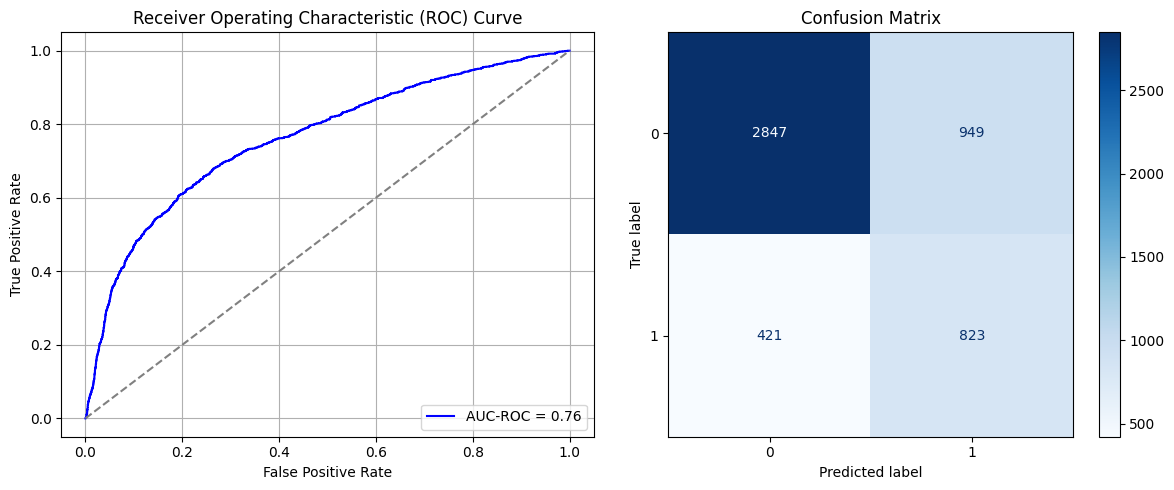

Best threshold based on F1-score: 0.993011474609375
False Negative Rate: 0.3384244372990354
Time elapsed (performance): 0.7335919869997269
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6744 - loss: 0.6397 - val_AUC: 0.7539 - val_loss: 0.5855
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7484 - loss: 0.5855 - val_AUC: 0.7612 - val_loss: 0.5766
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7537 - loss: 0.5808 - val_AUC: 0.7655 - val_loss: 0.5733
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7602 - loss: 0.5743 - val_AUC: 0.7709 - val_loss: 0.5701
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7640 - loss: 0.5728 - val_AUC: 0.7808 - val_loss: 0.5605
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7714 - loss: 0.5657 - val_AUC: 0.7813 - val_loss: 0.5647
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7720 - loss: 0.5660 - val_AUC: 0.7845 - val_loss: 0.5589
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7781 - loss: 0.5608 - val_AUC: 0.7874 - val_loss: 0.5574
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7816 -

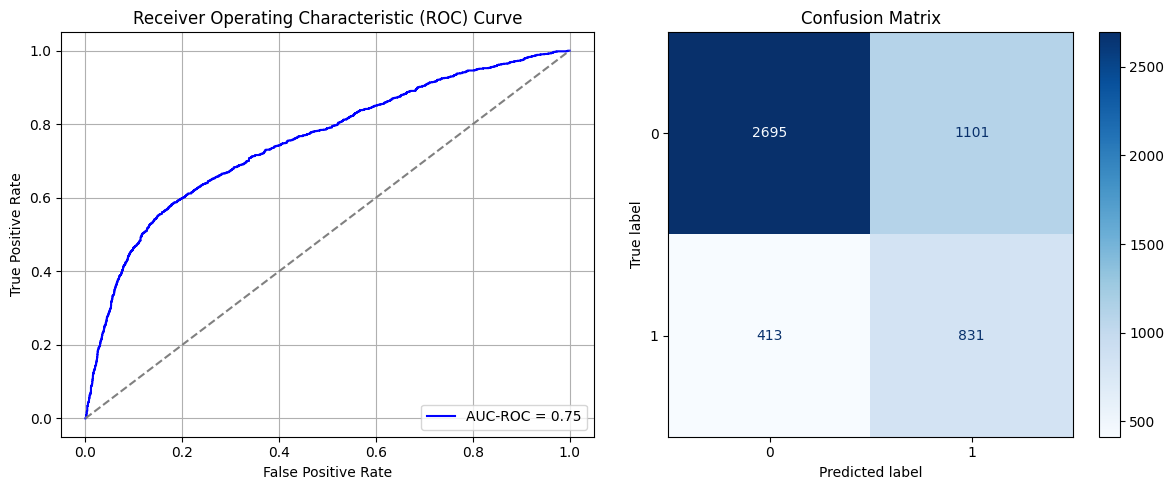

Best threshold based on F1-score: 0.9910764098167419
False Negative Rate: 0.3319935691318328
Time elapsed (performance): 0.7407871129998966
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6866 - loss: 0.6369 - val_AUC: 0.7475 - val_loss: 0.5844
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7448 - loss: 0.5840 - val_AUC: 0.7528 - val_loss: 0.5772
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7488 - loss: 0.5824 - val_AUC: 0.7633 - val_loss: 0.5717
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7544 - loss: 0.5795 - val_AUC: 0.7678 - val_loss: 0.5719
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7647 - loss: 0.5701 - val_AUC: 0.7704 - val_loss: 0.5664
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7698 - loss: 0.5675 - val_AUC: 0.7761 - val_loss: 0.5641
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7754 - loss: 0.5626 - val_AUC: 0.7781 - val_loss: 0.5602
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7722 - loss: 0.5655 - val_AUC: 0.7788 - val_loss: 0.5621
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7787 -

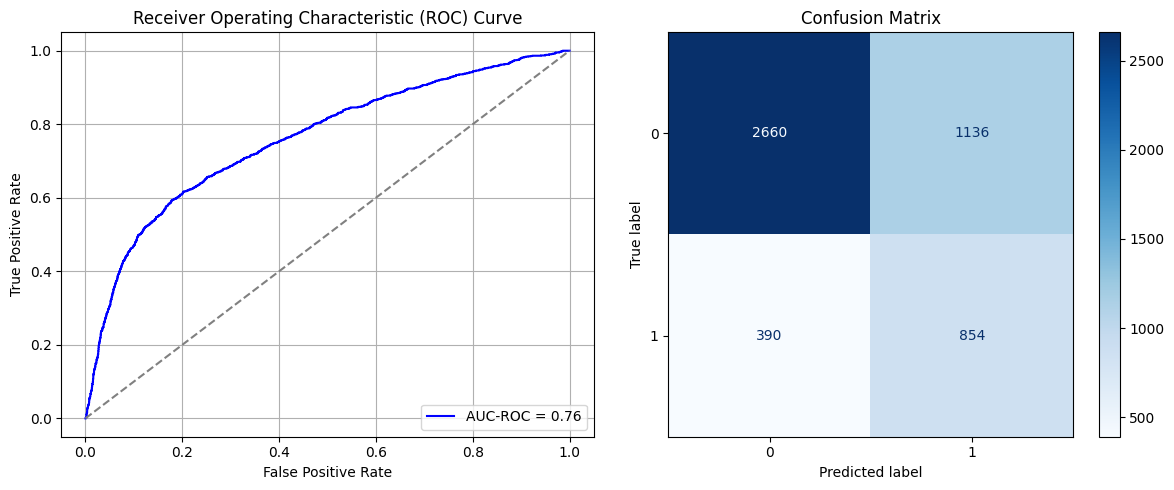

Best threshold based on F1-score: 0.9802082777023315
False Negative Rate: 0.3135048231511254
Time elapsed (performance): 0.7289702250000119
Epoch 1/10


<ipython-input-22-64b595990d04>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6855 - loss: 0.6357 - val_AUC: 0.7481 - val_loss: 0.5839
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7452 - loss: 0.5865 - val_AUC: 0.7605 - val_loss: 0.5755
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7547 - loss: 0.5824 - val_AUC: 0.7704 - val_loss: 0.5688
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7664 - loss: 0.5685 - val_AUC: 0.7697 - val_loss: 0.5793
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7705 - loss: 0.5676 - val_AUC: 0.7797 - val_loss: 0.5610
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7741 - loss: 0.5649 - val_AUC: 0.7818 - val_loss: 0.5619
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7767 - loss: 0.5621 - val_AUC: 0.7845 - val_loss: 0.5580
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7806 - loss: 0.5601 - val_AUC: 0.7837 - val_loss: 0.5582
Epoch 9/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7837 -

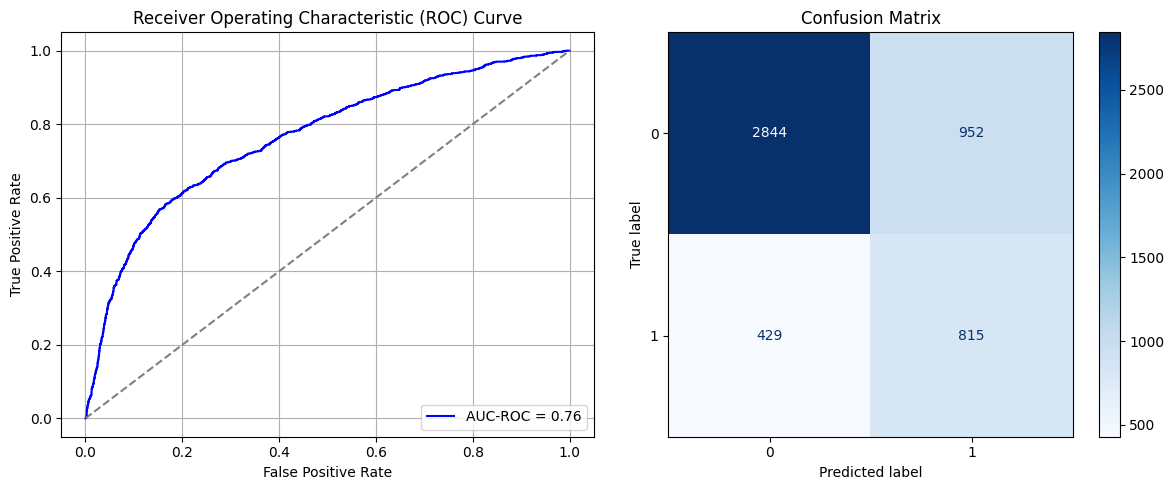

Best threshold based on F1-score: 0.6251645088195801
False Negative Rate: 0.34485530546623794
Time elapsed (performance): 0.7162657519997992


In [44]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = 10
Nsamples = k*(oversample_size-undersample_size)/undersample_size



for i in range(times):
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_S_min_ros = pd.DataFrame()
    data_S_min_ros = data_S_minority.iloc[Row]
    data_S_Sy_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_Sy_ROS = data_S_Sy_ROS.iloc[:, :-1]
    y_S_Sy_ROS = data_S_Sy_ROS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy_ROS, y_S_Sy_ROS, test_size=0.20, random_state=0)
    model_Sy_ROS = create_dnn_model(X_S_train.shape[1])
    result_Sy_ROS = train_and_evaluate(model_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy_ROS = Transductive_TL(model_Sy_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_Sy_ROS)
    FPR.append(result_TL_Sy_ROS[0])
    TNR.append(result_TL_Sy_ROS[1])
    FNR.append(result_TL_Sy_ROS[2])
    TPR.append(result_TL_Sy_ROS[3])
    TL_time.append(result_TL_Sy_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [45]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS2.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    27.803561  0.318493  0.681507  0.317524  0.682476     0.730326
1    34.731907  0.308483  0.691517  0.299839  0.700161     0.725710
2    32.802976  0.209168  0.790832  0.380225  0.619775     0.716130
3    32.677453  0.267387  0.732613  0.346463  0.653537     0.716661
4    33.826883  0.475764  0.524236  0.221865  0.778135     0.716327
5    32.655356  0.343519  0.656481  0.288585  0.711415     2.727137
6    42.098311  0.250000  0.750000  0.338424  0.661576     0.733592
7    38.422541  0.290042  0.709958  0.331994  0.668006     0.740787
8    35.965919  0.299262  0.700738  0.313505  0.686495     0.728970
9    39.298220  0.250790  0.749210  0.344855  0.655145     0.716266
